# Import

In [1]:
from copy import deepcopy
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sns
import spm1d

C:\Users\niels\AppData\Local\Temp\ipykernel_3272\2698582682.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Settings

In [2]:
# Paths
path_root = "D:\\AI"
paths = {"GRN": {"Random Search": "D:\\AI\\Random\\GRN", 
                 "Evolution": "C:\\Users\\niels\\Downloads\\GRN_runs"},
        "CPPN": {"Random Search": "C:\\Users\\niels\\Downloads\\CPPN\\Random Search", 
                "Evolution": "C:\\Users\\niels\\Downloads\\CPPN"},
        "GRN_system": {"Random Search": "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Random",
                "Evolution": "C:\\Users\\niels\\Downloads\\GRN_system_runs"},}
# Mapping for column names
mappings = {'bricks': "Number of Bricks", 'hinges': "Number of Hinges", 'modules': "Modules", 
            'size': "Relative Number of Modules", 'proportion2d': "Proportion2D",
            "proportionNiels": "Proportion2D_adapted", 'single_neighbour_brick_ratio': "Single_Neighbour_Bricks", 
            'single_neighbour_ratio': "Single Neighbours", 'double_neighbour_brick_and_active_hinge_ratio': "Double_Neighbours",
            'maxrel_llimbs': 'Attachment Length Max', 'meanrel_llimbs': 'Attachment Length Mean', 
            'stdrel_llimbs': "Attachment Length Std", 'nlimbs': "Core Attachments",
            'joints': 'Number of Joints', 'joint_brick_ratio': 'Joint-Brick Ratio',
            "surface_area": "Surface Area"}

# Import Data

In [3]:
# Get data
df_exp = pd.DataFrame([])
for algorithm, algodata in paths.items():
    for mode, path in algodata.items():
        for file in os.listdir(path):
            if file.endswith(".csv"):
                print("Processing file: ", file)
                # Load data
                df_new = pd.read_csv(path + "\\" + file)

                # # Concat 
                # df_new.drop(columns=["joints"], inplace=True)
                # df_new = pd.merge(df_new, df_joints, on="id_string", how = "left")
                # df_new.to_csv(path + "\\" + file, index=False)

                # Add algorithm and mode
                df_new["Algorithm"] = algorithm
                df_new["Mode"] = mode

                # Check and select data
                if mode == "Evolution":
                    # Assert that 600 generations are present
                    for exp_id in df_new.loc[:, "experiment_id"].unique():
                        assert len(df_new.loc[df_new["experiment_id"] == exp_id, "generation_index"].unique()) == (1200 + 1)

                    # Assert that all even generations have 100 individuals
                    assert df_new.loc[df_new["generation_index"] % 2 == 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 100
                    # Assert that all uneven generations have 50 individuals
                    assert df_new.loc[df_new["generation_index"] % 2 != 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 50

                elif mode == "Random Search":
                    # Only gen = 0 and offspring
                    df_new = df_new.loc[(df_new.loc[:, "generation_index"] % 2 != 0) | (df_new.loc[:, "generation_index"] == 0), :]
                    df_new["generation_index"] = df_new.loc[:, "generation_index"].values - (df_new.loc[:, "generation_index"].values // 2)
                    
                    # Assert that all experiments have 51 generations
                    for exp_id in df_new.loc[:, "experiment_id"].unique():
                        assert len(df_new.loc[df_new["experiment_id"] == exp_id, "generation_index"].unique()) == 51
                    
                    
                    # Assert that all generations have 50 individuals if not generation 0
                    assert df_new.loc[df_new["generation_index"] != 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 50
                    # Assert that generation 0 has 100 individuals
                    assert df_new.loc[df_new["generation_index"] == 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 100

                # Assert that 20 reps are present
                assert len(df_new.loc[:, "experiment_id"].unique()) == 20

                # Append to existing data
                df_exp = pd.concat([df_exp, df_new], ignore_index=True)

# Rename columns
df_exp = df_exp.rename(columns=mappings)

Processing file:  GRN_Random_Search.csv
Processing file:  GRN_Evolution_Morphology_Fitness.csv
Processing file:  CPPN_Random_Search.csv
Processing file:  CPPN_Evolution_Morphology_Fitness.csv
Processing file:  mrGRN_Random_Search.csv
Processing file:  mrGRN_Evolution_Morphology_Fitness.csv


In [4]:
# Load Random Data
path2random = "C:\\Users\\niels\\Downloads\\Random_runs"

# Get data
df_random = pd.DataFrame([])
for file in os.listdir(path2random):
    if ("morphological_measures_" in file) and (file.endswith(".csv")):
        df_random_new = pd.read_csv(path2random + "\\" + file)

        # # Concat 
        # df_random_new.drop(columns=["joints"], inplace=True)
        # df_random_new = pd.merge(df_random_new, df_joints, on="id_string", how = "left")
        # df_random_new.to_csv(path2random + "\\" + file, index=False)
        
        assert df_random_new["count"].sum() == 60000
        df_random = pd.concat([df_random, df_random_new], ignore_index=True)

# Rename columns
df_random = df_random.rename(columns=mappings)
df_random["Algorithm"] = "Random"

# Concatenate data
df_exp = pd.concat([df_exp, df_random], ignore_index=True)

# Transform Data

In [5]:
# Get maximal symmetry
df_exp["Symmetry_incl_max"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].max(axis = 1)
df_exp["Symmetry_excl_max"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].max(axis = 1)
# Get median symmetry
df_exp["Symmetry_incl_median"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].median(axis = 1)
df_exp["Symmetry_excl_median"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].median(axis = 1)
# Get summation symmetry
df_exp["Symmetry_incl_sum"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].sum(axis = 1) / 4
df_exp["Symmetry_excl_sum"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].sum(axis = 1) / 4

# Get standard deviation symmetry
df_exp["Symmetry_incl_std"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].std(axis = 1)
df_exp["Symmetry_excl_std"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].std(axis = 1)

# Transform number of limbs
df_exp["Core Attachments"] = df_exp["Core Attachments"] / 4

# Statistics

In [ ]:
column = "Number of Joints"
run = 0

# Select data
df = df_exp.loc[df_exp["Mode"] == "Evolution", :]
df = df.loc[df["generation_index"] == run, :]
column_data = df.groupby(["Algorithm", "experiment_id", "generation_index"])[column].median()

# Kruksal Wallis
from scipy.stats import kruskal
res = kruskal(column_data.loc["CPPN"], column_data.loc["GRN"], column_data.loc["GRN_system"])
print("Kruskal Wallis result: ", res)
# Posthoc
import scikit_posthocs as sp
# Perform the Dunn test
dunn_result = sp.posthoc_dunn([column_data.loc["CPPN"], column_data.loc["GRN"], 
                               column_data.loc["GRN_system"]], p_adjust = "bonferroni")
print("Dunn test result:")
print(dunn_result)


# Fitness

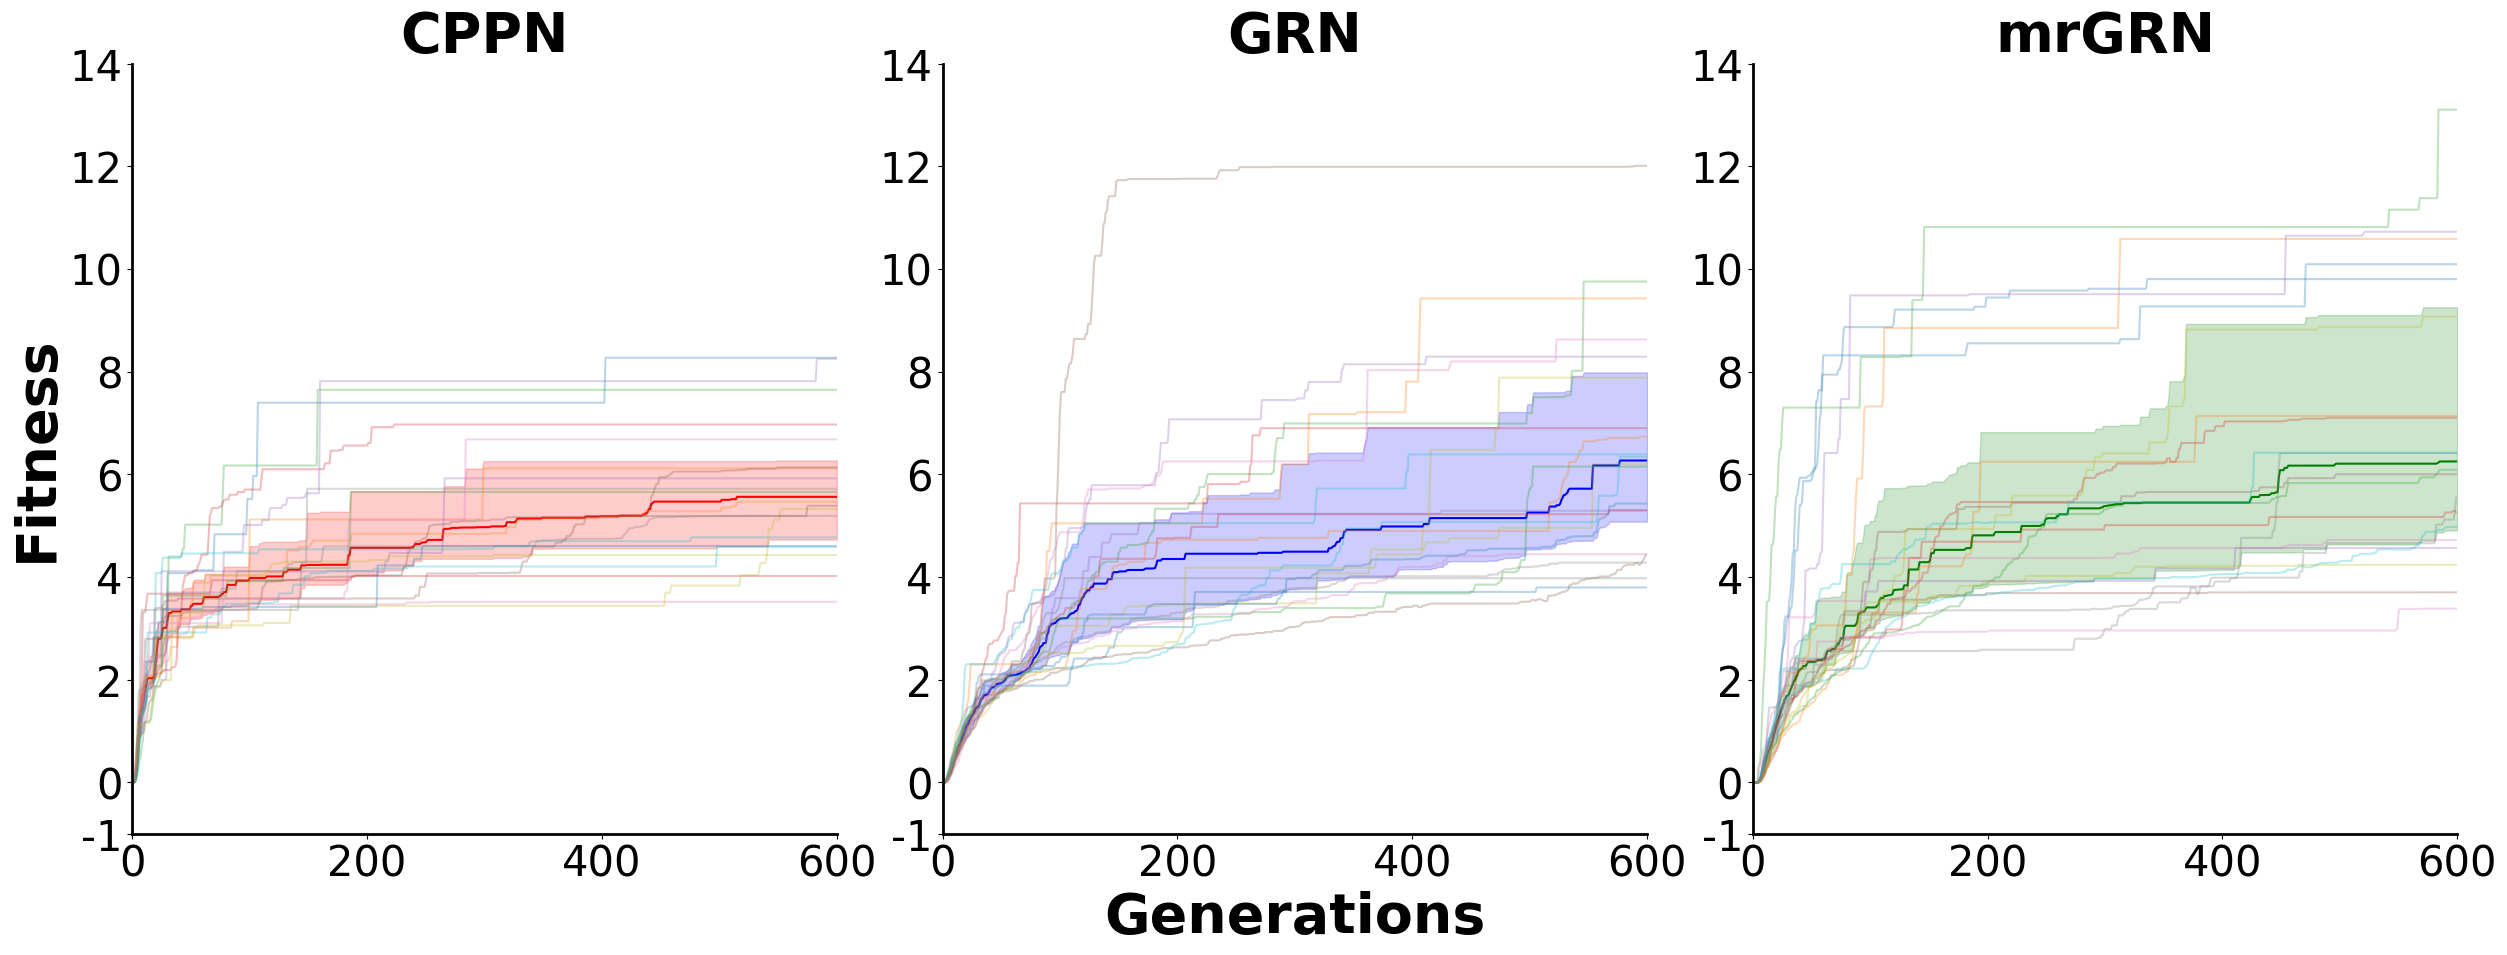

In [6]:
# Initialize subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
plt.subplots_adjust(wspace = 0.15)
colors = ["red", "blue", "green"]

# Save data
medians = {}

# Plot
for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]):
    # Get data of algo
    df = df_exp.loc[df_exp["Algorithm"] == algo, :]
    df = df.loc[df["Mode"] == "Evolution", :]

    # Only even
    df = df.loc[df["generation_index"] % 2 == 0, :]
    df["generation_index"] /= 2

    # Get median per experiment
    fitnesses = df.groupby(["experiment_id", "generation_index"])["fitness"].median()
    medians[algo] = fitnesses
    #fitnesses = df.groupby(["experiment_id", "generation_index"])["fitness"].quantile(0.75)
    # Get median, 1q and 3q over experiments
    fitness_median = fitnesses.groupby(["generation_index"]).median().reset_index()
    fitness_1q = fitnesses.groupby(["generation_index"]).quantile(0.25).reset_index()
    fitness_3q = fitnesses.groupby(["generation_index"]).quantile(0.75).reset_index()

    # Plot
    algo_label = algo if algo != "GRN_system" else "mrGRN"
    axs[ialgo].plot(np.arange(0, 601), fitness_median["fitness"].values, label = algo_label, color = colors[ialgo])
    axs[ialgo].fill_between(np.arange(0, 601), fitness_1q["fitness"].values, fitness_3q["fitness"].values, 
                            alpha = 0.2, color = colors[ialgo])
    
    for exp in fitnesses.index.get_level_values(0).unique():
        axs[ialgo].plot(fitnesses[fitnesses.index.get_level_values(0) == exp].values, "-", alpha = 0.3)
    
    # Set limits
    axs[ialgo].set_ylim([-1, 14])
    axs[ialgo].set_xlim([0, 600])

    # Set font size of tick labels
    axs[ialgo].tick_params(axis='both', which='major', labelsize=30)
    axs[ialgo].tick_params(axis='both', which='minor', labelsize=30)

    # Remove tick indicators
    if ialgo != 0:
        axs[ialgo].set_yticks([])

    # Remove axes
    axs[ialgo].spines['top'].set_visible(False)
    axs[ialgo].spines['right'].set_visible(False)

    # Set thicker spines
    axs[ialgo].spines['top'].set_linewidth(2)
    axs[ialgo].spines['bottom'].set_linewidth(2)
    axs[ialgo].spines['left'].set_linewidth(2)
    axs[ialgo].spines['right'].set_linewidth(2)

    # Set labels
    if ialgo == 0:
        axs[ialgo].set_ylabel("Fitness", fontweight = "bold", fontsize = 40)
    axs[ialgo].set_yticks([-1, 0, 2, 4, 6, 8, 10, 12, 14], [-1, 0, 2, 4, 6, 8, 10, 12, 14])
    if ialgo == 1:
        axs[ialgo].set_xlabel("Generations", fontweight = "bold", fontsize = 40)
    
    # Set title
    axs[ialgo].set_title(algo_label, fontweight = "bold", fontsize = 40)


plt.show()



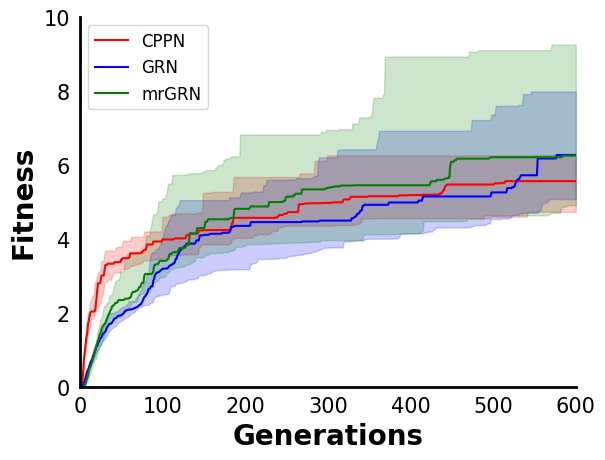

In [40]:
# Colors
colors = ["red", "blue", "green"]

for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]):
    # Get data
    median = medians[algo].groupby("generation_index").median().reset_index()
    lwb = medians[algo].groupby("generation_index").quantile(0.25).reset_index()
    upb = medians[algo].groupby("generation_index").quantile(0.75).reset_index()
    # Plot
    plt.plot(np.arange(0, 601), median["fitness"].values, label = algo if algo != "GRN_system" else "mrGRN",
             color = colors[ialgo])
    plt.fill_between(np.arange(0, 601), lwb["fitness"].values, upb["fitness"].values, alpha = 0.2,
                        color = colors[ialgo])

    # Set limits
    plt.ylim([0, 10])
    plt.xlim([0, 600])

    # Set font size of tick labels
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left = False, right = False,
                    labelsize=15)

    # Remove axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Set thicker spines
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)

    # Set labels
    plt.ylabel("Fitness", fontweight = "bold", fontsize = 20)
    plt.yticks([0, 2, 4, 6, 8, 10], [0, 2, 4, 6, 8, 10])
    plt.xlabel("Generations", fontweight = "bold", fontsize = 20)

    
plt.legend(fontsize = 12, loc = "upper left")
plt.show()

# 3-4 GRN better than mrGRN

Processing combination:  ['CPPN', 'GRN', 'GRN_system']


C:\Users\niels\AppData\Local\Temp\ipykernel_16684\2209562613.py:33: UserWarning: 

  F = spm1d.stats.anova1(Y, A.flatten(), equal_var = False)


2
53
Processing combination:  ('CPPN', 'GRN')
2
88
Processing combination:  ('CPPN', 'GRN_system')
1
22
Processing combination:  ('GRN', 'GRN_system')


c:\Users\niels\OneDrive\Documenten\GitHub\revolve2\.venv\lib\site-packages\spm1d\stats\_datachecks.py:204: UserWarning: 

  checker.check()
C:\Users\niels\AppData\Local\Temp\ipykernel_16684\2209562613.py:37: UserWarning: 

  F = spm1d.stats.anova1(Y, A.flatten(), equal_var = False)


3
4


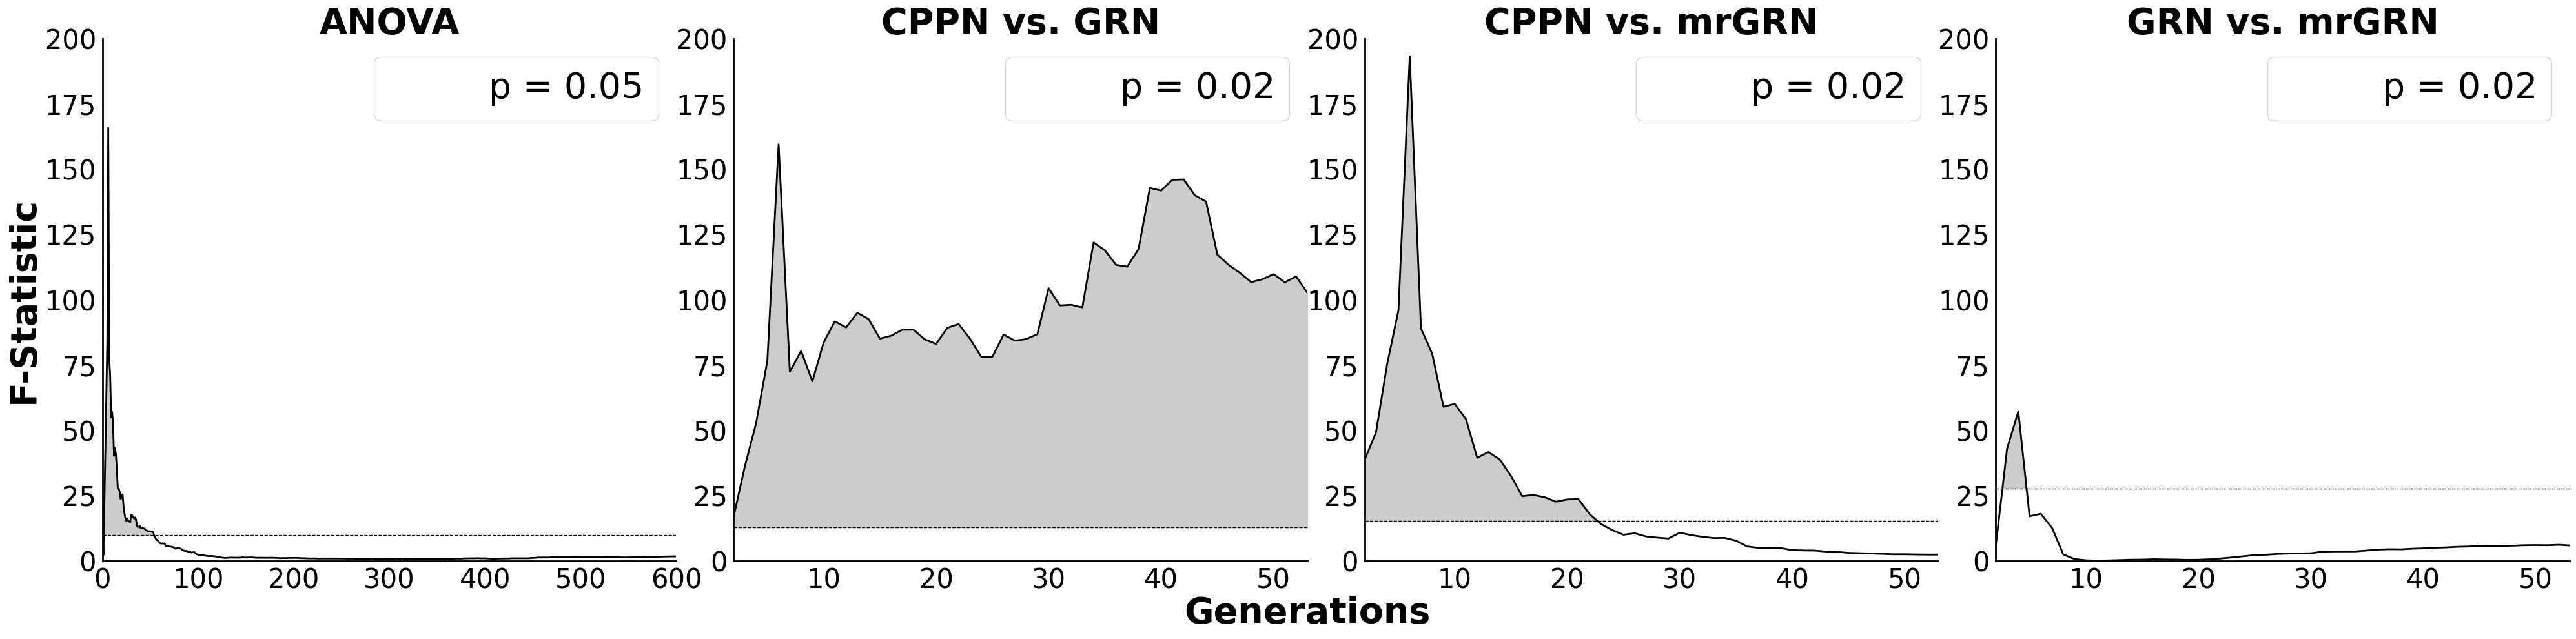

In [26]:
items = ["CPPN", "GRN", "GRN_system"]
names = {"CPPN": "CPPN", "GRN": "GRN", "GRN_system": "mrGRN"}
labels = {"CPPN": 1, "GRN": 2, "GRN_system": 3}

# Get p-critical
alpha = 0.05
nTests = 3
p_critical = spm1d.util.p_critical_bonf(alpha, nTests)

# Generate all 2-element combinations
combinations2 = list(combinations(items, 2))
# Combine
items = [items] + combinations2

# Initialize figure
fig, axs = plt.subplots(1, 4, figsize=(40, 10))

for icombination, combination in enumerate(items):
    print("Processing combination: ", combination)
    for algo in combination:
        values = medians[algo].unstack().values
        # Save
        if algo == combination[0]:
            Y = deepcopy(values)
            A = np.ones((values.shape[0], 1))
        else:
            Y = np.append(Y, values, axis = 0)
            A = np.append(A, np.ones((values.shape[0], 1)) * labels[algo], axis = 0)
    
    # Perform Test
    if icombination == 0:
        # Perform ANOVA
        F = spm1d.stats.anova1(Y, A.flatten(), equal_var = False)
        Fi = F.inference(alpha = alpha)
    else:
        # Perform t-test
        F = spm1d.stats.anova1(Y, A.flatten(), equal_var = False)
        Fi = F.inference(alpha = p_critical)

    # Add horizontal line
    axs[icombination].axhline(y = Fi.zstar, color = "black", linestyle = "--", alpha = 0, linewidth = 2,
                              label = f"p = {alpha if icombination == 0 else p_critical:.2f}")
    Fi.plot(ax = axs[icombination])
    # Remove tick indicators, but not the labels
    axs[icombination].tick_params(axis='y', which='both', left=False, right=False, labelleft=True)
    axs[icombination].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    # Remove axes
    axs[icombination].spines['top'].set_visible(False)
    axs[icombination].spines['right'].set_visible(False)
    # Set labels
    if icombination == 0:
        axs[icombination].set_ylabel("F-Statistic", fontweight = "bold", fontsize = 40)
    else:
        axs[icombination].set_ylabel(" ", fontweight = "bold", fontsize = 40)
    if icombination == 1:
        # At right side
        axs[icombination].text(1, -0.1, "Generations",
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation=0,
                    transform=axs[icombination].transAxes,
                    fontweight = "bold", fontsize = 40) 
                               
    else:
        axs[icombination].set_xlabel(" ", fontweight = "bold", fontsize = 40)

    if icombination == 0:
        axs[icombination].set_title("ANOVA", fontweight = "bold", fontsize = 40)
        axs[icombination].set_xlim(0, 600)
        min_x = np.where(Fi.z >= Fi.zstar)[0].min()
        max_x = np.where(Fi.z >= Fi.zstar)[0].max()
    else:
        axs[icombination].set_title(names[combination[0]] + " vs. " + 
                                names[combination[1]], fontweight = "bold", fontsize = 40)
        axs[icombination].set_xlim(min_x, max_x)
    print(np.where(Fi.z >= Fi.zstar)[0].min())
    print(np.where(Fi.z >= Fi.zstar)[0].max())
    # Set x limits
    axs[icombination].set_ylim(0, 200)

    # Set thicker spines
    axs[icombination].spines['left'].set_linewidth(2)
    axs[icombination].spines['bottom'].set_linewidth(2)

    # Set xlabel and ylabel font size
    axs[icombination].tick_params(axis='both', which='major', labelsize=30)

    # Legend
    axs[icombination].legend(fontsize = 40)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.1, hspace = 0.3)
plt.show()

# HeatMap

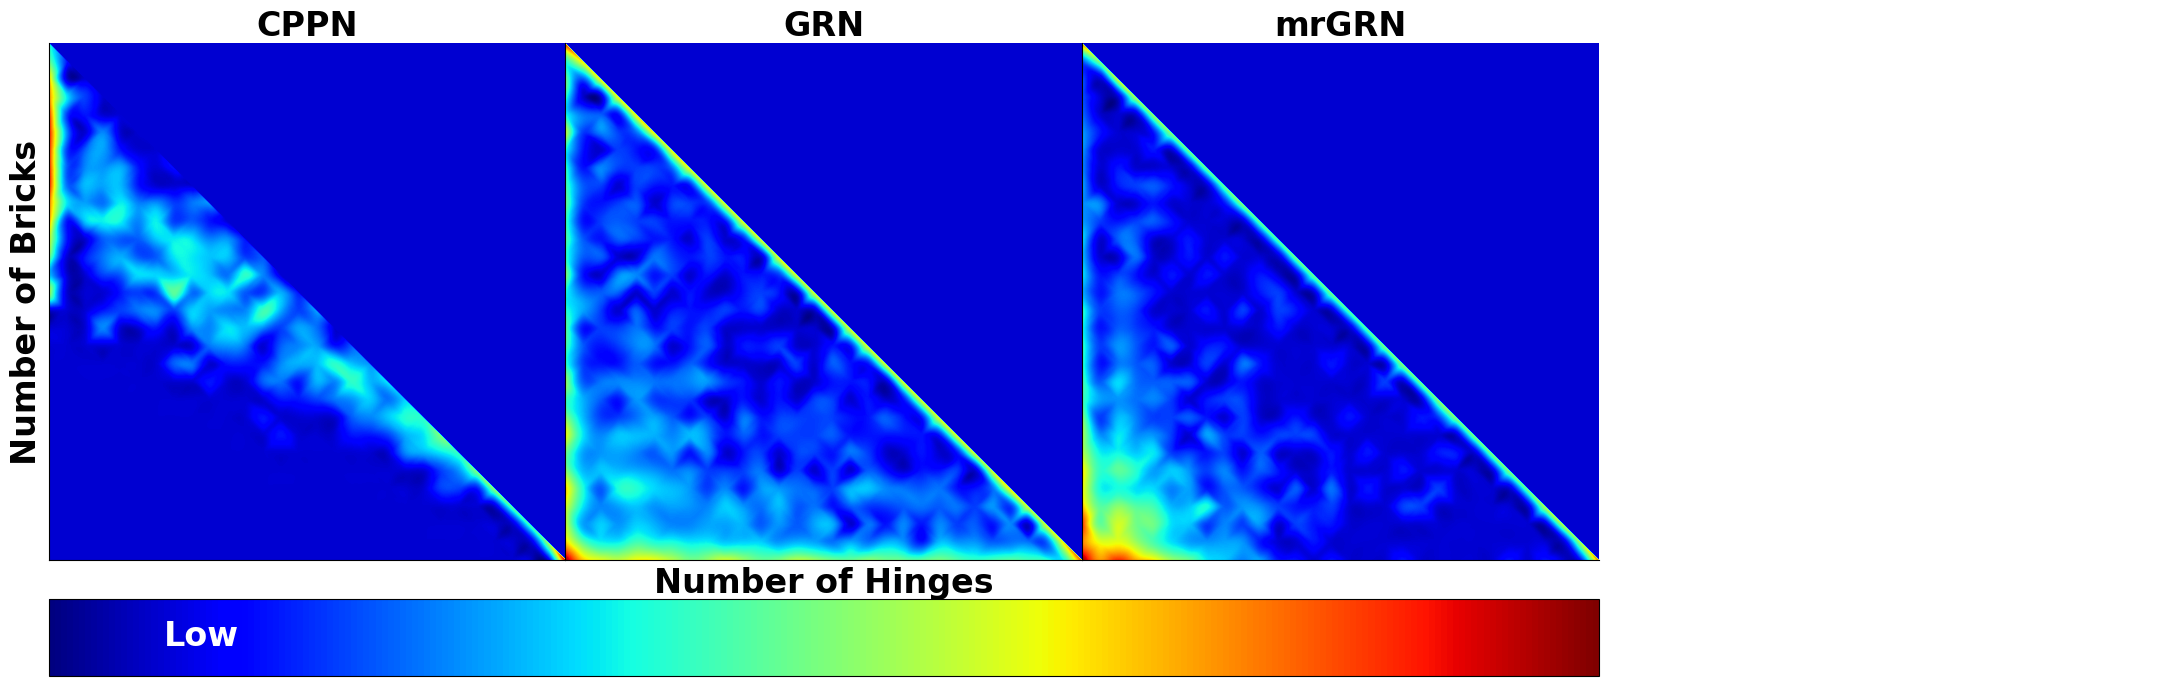

In [22]:
# Settings
col1 = "Number of Hinges"
col2 = "Number of Bricks"
logarithmic = True#False#True
unique = False #False

# Initialize subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
plt.subplots_adjust(wspace = 0)

for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]): # "Random", 
    # Normalize data
    df_transf = (df_exp.loc[:, [col1, col2]] - df_exp.loc[:, [col1, col2]].min(axis = 0)) / (df_exp.loc[:, [col1, col2]].max(axis = 0) - df_exp.loc[:, [col1, col2]].min(axis = 0))
    # Get data of algorithm
    df = df_exp.loc[df_exp["Algorithm"] == algo]
    # Get data of mode
    if algo == "Random":
        pass#df = df.sample(30 * 60000, weights = "count", replace = True)
    else:
        df = df.loc[df["Mode"] == "Random Search"]
        #df = df.loc[df["Mode"] == "Evolution"]#.sample(10000)#, weights = "count")
        # Select pop = 0 and uneven
        df = df.loc[np.logical_or(df["generation_index"] % 2 != 0, df["generation_index"] == 0), :]


    # Get all points in dataset
    points = (df.loc[:, [col1, col2]] - df_exp.loc[:, [col1, col2]].min(axis = 0)) / (df_exp.loc[:, [col1, col2]].max(axis = 0) - df_exp.loc[:, [col1, col2]].min(axis = 0))

    # Get values for each point
    if algo == "Random":
        if unique:
            points["values"] = df.groupby([col1, col2]).transform("size") # Unique counts
        else:
            points["values"] = df.groupby([col1, col2])["count"].transform("sum") # Nonunique counts
    else:
        if unique:
            points["values"] = df.drop_duplicates(["id_string"]).groupby([col1, col2]).transform("size") 
        else:
            points["values"] = df.groupby([col1, col2]).transform("size")


    # Drop duplicates
    points = points.drop_duplicates([col1, col2])

    # Add non-existing points to dataset as 0
    dict2add = {col1: [], col2: [], "values": []}
    added = []
    for key in df_transf.loc[:, [col1, col2]].groupby([col1, col2]).groups.keys():
        list_key = list(key)
        if list_key not in points.loc[:, [col1, col2]].values.tolist():
            if list_key not in added:
                dict2add[col1].append(list_key[0])
                dict2add[col2].append(list_key[1])
                dict2add["values"].append(0)
                added.append(list_key)

    # Append to dataset
    points_new = pd.concat([points, pd.DataFrame(dict2add)], ignore_index=True)
        
    # Get values
    values = points_new["values"].values
    if logarithmic:
        values = np.log(values + 1) # Logarithmic scale
    coordinates = points_new.loc[:, [col1, col2]].values

    # Creat a meshgrid
    mins = coordinates.min(axis = 0)
    maxs = coordinates.max(axis = 0)
    grid_x, grid_y = np.mgrid[mins[0]:maxs[0]:1000j, mins[1]:maxs[1]:1000j]

    # Interpolate
    grid_z0 = griddata(coordinates, values, (grid_x, grid_y), method='cubic', fill_value = 0) # nearest, linear, cubic

    # Plot
    extent = (mins[0] - 0.05, maxs[0] + 0.05, mins[1] - 0.05, maxs[1] + 0.05)
    cmap = "jet"
    if ialgo == 0:
        i = axs[ialgo].imshow(grid_z0.T, extent = extent, cmap = cmap, origin='lower')
    else: axs[ialgo].imshow(grid_z0.T, extent = extent, cmap = cmap, origin='lower')

    #plt.scatter(coordinates[:, 0], coordinates[:, 1], c = "k")
    if ialgo == 1:
        axs[ialgo].set_xlabel(col1, fontsize = 24, fontweight = "bold", )
        #axs[ialgo].xaxis.set_label_coords(1.05, -0.025)
    if ialgo == 0:
        axs[ialgo].set_ylabel(col2, fontsize = 24, fontweight = "bold")
    if algo != "GRN_system":
        axs[ialgo].set_title(algo, fontsize = 24, fontweight = "bold")
    else:
        axs[ialgo].set_title("mrGRN", fontsize = 24, fontweight = "bold")

    # Remove tick indicators
    axs[ialgo].set_xticks([])
    axs[ialgo].set_yticks([])

    # Remove axes
    axs[ialgo].spines['top'].set_visible(False)
    axs[ialgo].spines['right'].set_visible(False)

    #plt.plot(points[col1], points[col2], 'o', markeredgecolor='grey', markerfacecolor='none', markersize = 5)
cbar = plt.colorbar(i, orientation = "horizontal", ax = [axs[0], axs[1], axs[2]], pad = 0.025)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])

for j, lab in {0.01: "Low", 12: "High"}.items():
    cbar.ax.text(j, 0.4, lab, fontweight = "bold", fontsize = 24, color = "white")

plt.show()

# Plot Data over Time

C:\Users\niels\AppData\Local\Temp\ipykernel_14780\643111557.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ialgo, icolgroup].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_14780\643111557.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ialgo, icolgroup].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_14780\643111557.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ialgo, icolgroup].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_14780\643111557.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ialgo, icolgroup].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_14780\643111557.py:63: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[ialgo, icolgroup].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_1

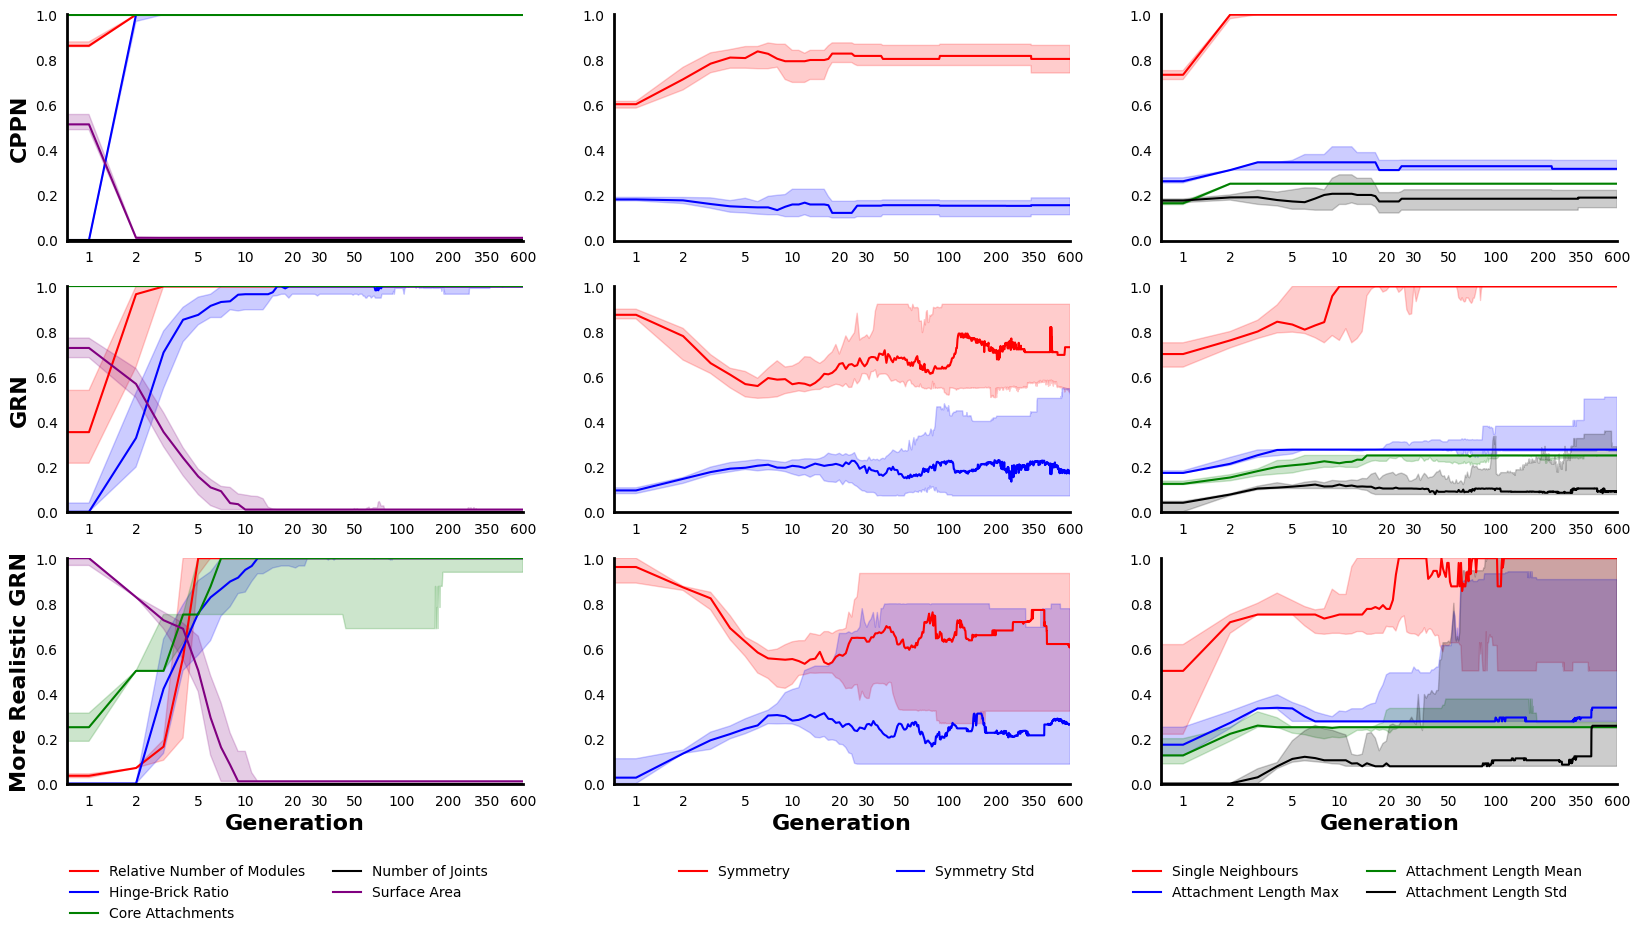

In [12]:
# Settings
columns = ["Relative Number of Modules", "Joint-Brick Ratio", "Core Attachments", "Single Neighbours",
                "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std", "Number of Joints",
                "Surface Area", 'Symmetry_incl_sum', "Symmetry_incl_std",
                ]
colgroups = [[0, 1, 2, 7, 8], [9, 10], [3, 4, 5, 6]]
colors = ["red", "blue", "green", "black", "purple"]

# Initialize Subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 10))

# Loop through encodings
for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]):
    # Get data
    df = df_exp.loc[:,  columns + ["experiment_id", "generation_index", "Mode", "Algorithm"]]

    # Normalize for each column except experiment_id, generation_index, Mode, Algorithm
    for col in columns:
        if col not in ["experiment_id", "generation_index", "Mode", "Algorithm"]:
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    # Get algo and only evolution data
    df = df.loc[df["Algorithm"] == algo]
    df = df.loc[df["Mode"] == "Evolution"]
    df.drop(columns = ["Algorithm", "Mode"], inplace=True)

    # Select only even generations
    df = df.loc[df["generation_index"] % 2 == 0]
    df["generation_index"] = df["generation_index"] // 2

    # ---- Plot
    for icolgroup, colgroup in enumerate(colgroups):
        for icol, col in enumerate([columns[col] for col in colgroup]):
            # Average over experiments
            median_per_exp = df.groupby(["experiment_id", "generation_index"]).median().reset_index()
            median = median_per_exp.groupby("generation_index").median().reset_index()
            fq = median_per_exp.groupby("generation_index").quantile(0.25).reset_index()
            lq = median_per_exp.groupby("generation_index").quantile(0.75).reset_index()
            # Plot
            if col not in ["Joint-Brick Ratio", "Symmetry_incl_sum", "Symmetry_incl_std"]:
                label = col
            elif col == "Joint-Brick Ratio":
                label = "Hinge-Brick Ratio"
            elif col == "Symmetry_incl_sum":
                label = "Symmetry                  "
            elif col == "Symmetry_incl_std":
                label = "Symmetry Std"
            ax[ialgo, icolgroup].plot(median["generation_index"], median[col], label = label, color = colors[icol])
            ax[ialgo, icolgroup].fill_between(median["generation_index"], fq[col], lq[col], alpha = 0.2, color = colors[icol])

        # Log x-scale
        ax[ialgo, icolgroup].set_xscale("log")
        # Set xtick labels
        ax[ialgo, icolgroup].set_xticks([1, 2, 5, 10, 20, 30, 50, 100, 200, 350, 600], [1, 2, 5, 10, 20, 30, 50, 100, 200, 350, 600])
        
        # Set thicker spines
        ax[ialgo, icolgroup].spines['top'].set_linewidth(2)
        ax[ialgo, icolgroup].spines['bottom'].set_linewidth(2)
        ax[ialgo, icolgroup].spines['left'].set_linewidth(2)
        ax[ialgo, icolgroup].spines['right'].set_linewidth(2)

        # Set limits
        ax[ialgo, icolgroup].set_xlim(0, 600)
        ax[ialgo, icolgroup].set_ylim(-0.0025, 1.0025)

        # Set labels
        if icolgroup == 0:
            if algo != "GRN_system":
                title = algo
            else: title = "More Realistic GRN"
            ax[ialgo, icolgroup].set_ylabel(title, fontsize = 16, fontweight = "bold")
        if ialgo == 2:
            ax[ialgo, icolgroup].set_xlabel("Generation", fontsize = 16, fontweight = "bold")

        # Remove ticks but keep labels
        ax[ialgo, icolgroup].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

        # Remove axes
        ax[ialgo, icolgroup].spines['top'].set_visible(False)
        ax[ialgo, icolgroup].spines['right'].set_visible(False)

        # Plot legend
        if ialgo == 2:
            ax[ialgo, icolgroup].legend(frameon = False, bbox_to_anchor=(0.95, -0.3), ncol = 2)
        

# Adjust space and Show
#plt.subplots_adjust(hspace = 1)

# plt.text(0, 0.66, "GRN")
# plt.text(0, 1, "More Realistic GRN")
plt.show()
    


C:\Users\niels\AppData\Local\Temp\ipykernel_3272\4249560651.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, col].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\4249560651.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, col].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\4249560651.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, col].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\4249560651.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, col].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\4249560651.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, col].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\4249560651.py:70: UserWarning: Attem

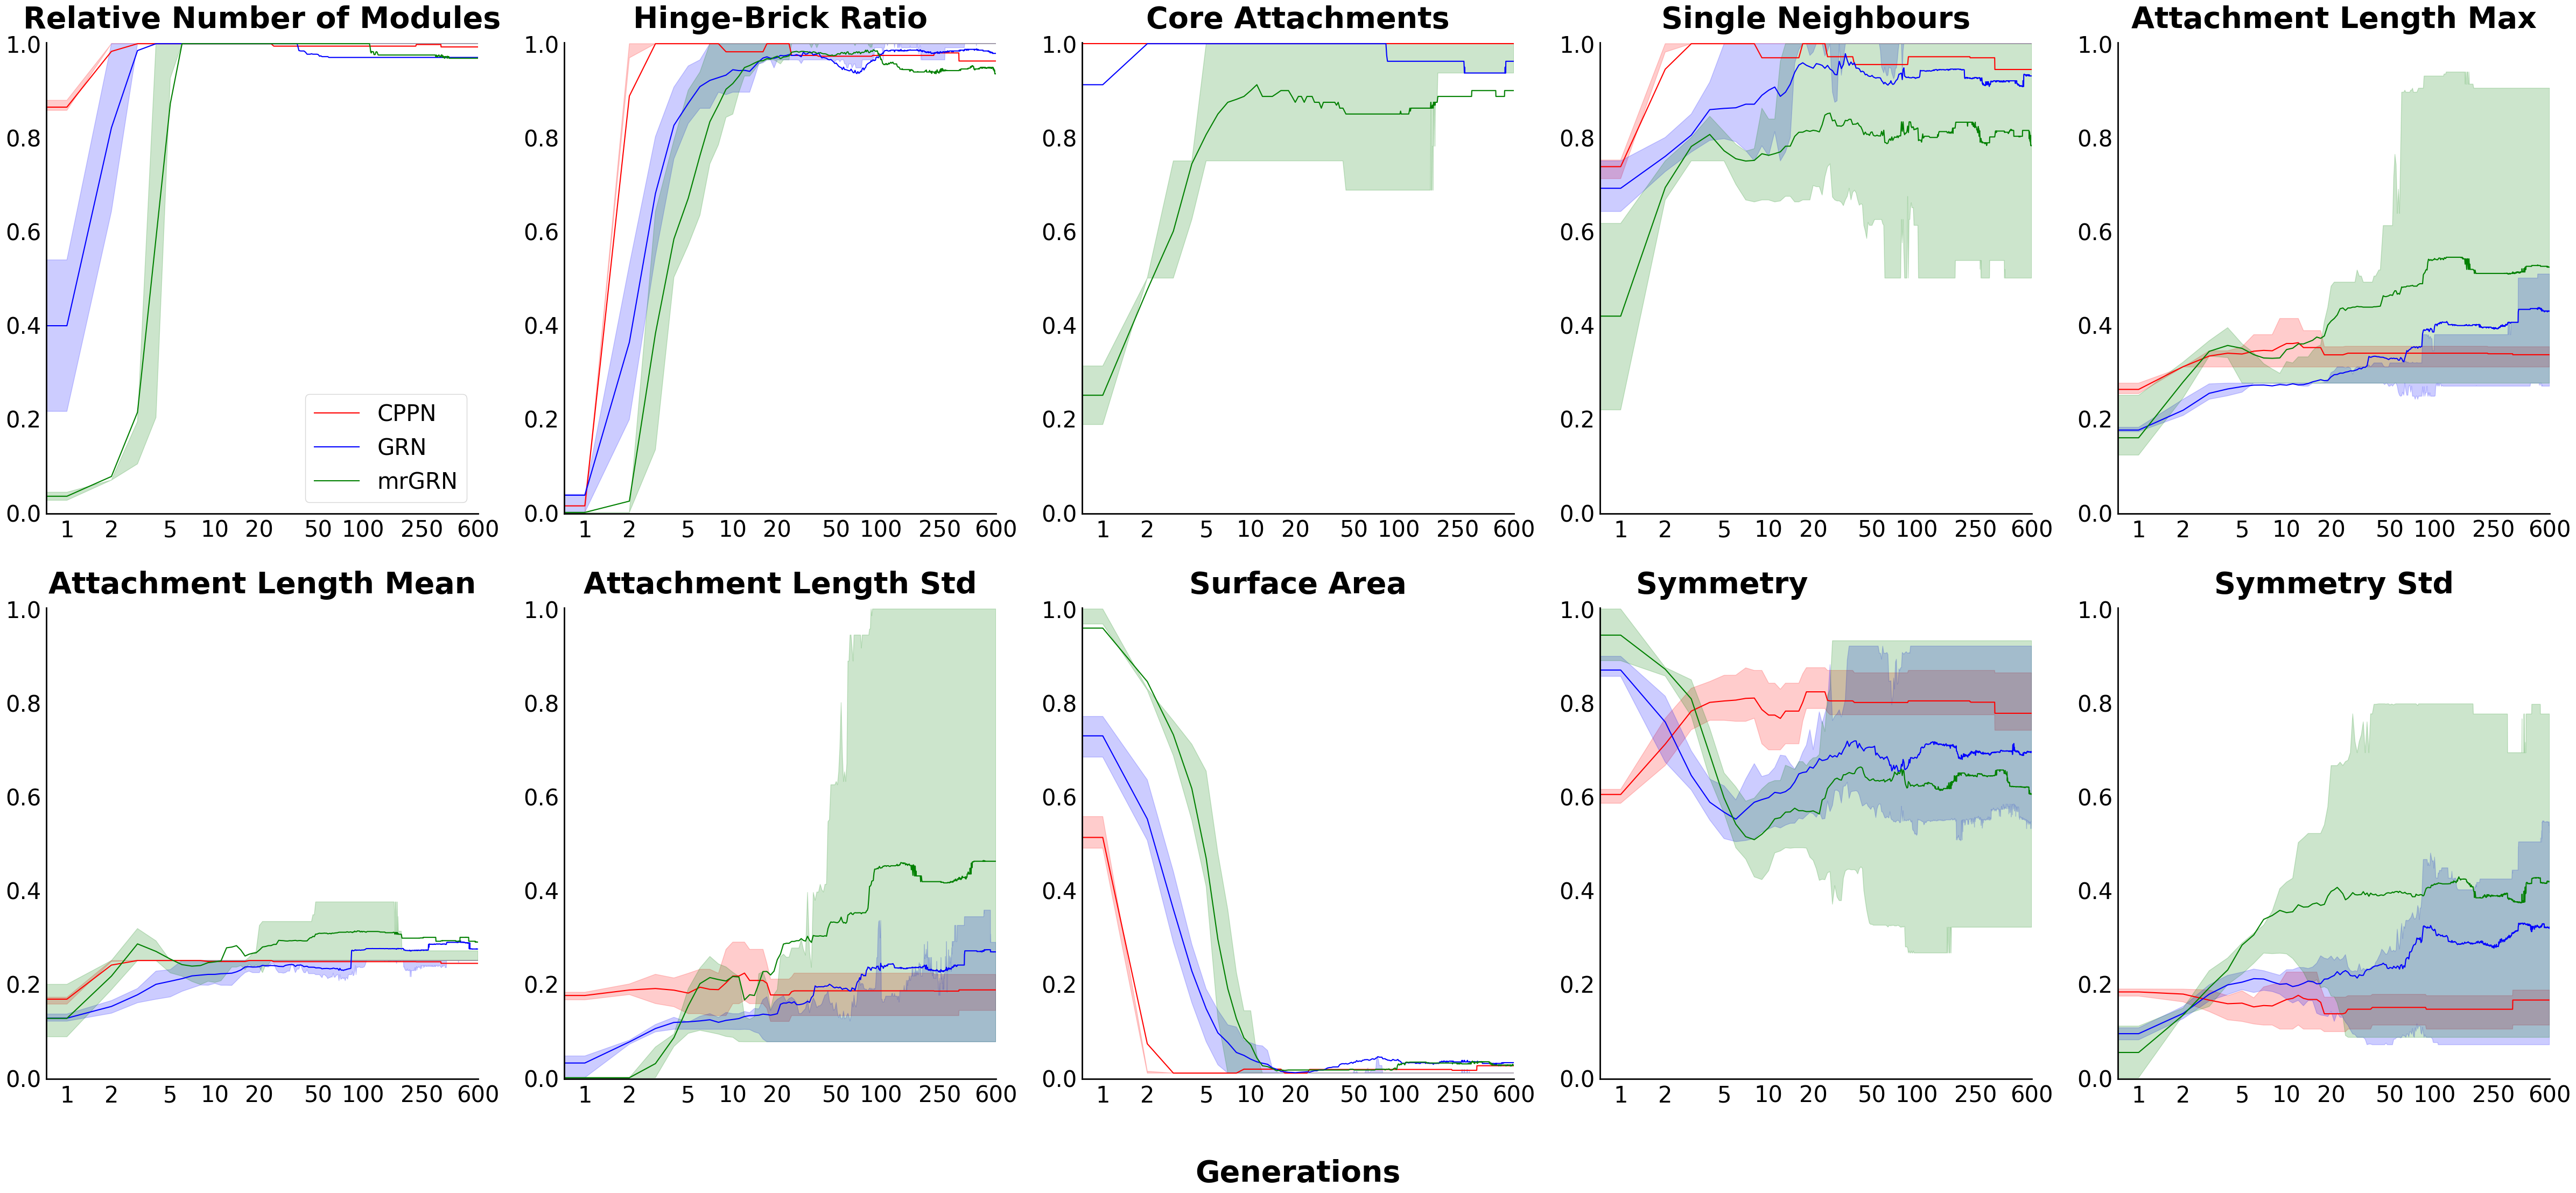

In [41]:
# Settings
columns = ["Relative Number of Modules", "Joint-Brick Ratio", "Core Attachments", "Single Neighbours",
                "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std",
                "Surface Area", 'Symmetry_incl_sum', "Symmetry_incl_std",
                ]
colors = ["red", "blue", "green"]

# Initialize Subplots
fig, ax = plt.subplots(2, 5, figsize=(60, 25))


# Get data 
df_sub = df_exp.loc[:,  columns + ["experiment_id", "generation_index", "Mode", "Algorithm"]]

# Normalize for each column except experiment_id, generation_index, Mode, Algorithm
for col in columns:
    if col not in ["experiment_id", "generation_index", "Mode", "Algorithm"]:
        df_sub[col] = (df_sub[col] - df_sub[col].min()) / (df_sub[col].max() - df_sub[col].min())

# Select only even generations
df_sub = df_sub.loc[df_sub["generation_index"] % 2 == 0]
df_sub["generation_index"] = df_sub["generation_index"] // 2

# Loop through columns
for icol, colname in enumerate(columns):
    # Get indices
    row = icol // 5
    col = icol % 5
    # Loop through encodings
    algos = ["CPPN", "GRN", "GRN_system"]
    for ialgo, algo in enumerate(algos):
        # Get algo and only evolution data
        df = df_sub.loc[df_sub["Algorithm"] == algo]
        df = df.loc[df["Mode"] == "Evolution"]
        df.drop(columns = ["Algorithm", "Mode"], inplace=True)

        # Average over experiments
        median_per_exp = df.groupby(["experiment_id", "generation_index"]).median().reset_index()
        median = median_per_exp.groupby("generation_index").median().reset_index()
        fq = median_per_exp.groupby("generation_index").quantile(0.25).reset_index()
        lq = median_per_exp.groupby("generation_index").quantile(0.75).reset_index()
        # Plot
        if colname not in ["Joint-Brick Ratio", "Symmetry_incl_sum", "Symmetry_incl_std"]:
            label = colname
        elif colname == "Joint-Brick Ratio":
            label = "Hinge-Brick Ratio"
        elif colname == "Symmetry_incl_sum":
            label = "Symmetry                  "
        elif colname == "Symmetry_incl_std":
            label = "Symmetry Std"
        ax[row, col].plot(median["generation_index"], median[colname], label = algo if algo != "GRN_system" else "mrGRN", color = colors[ialgo])
        ax[row, col].fill_between(median["generation_index"], fq[colname], lq[colname], alpha = 0.2, color = colors[ialgo])

        # Set title
        if ialgo == 0:
            ax[row, col].set_title(label, fontsize = 40, fontweight = "bold", pad = 20)

    # Log x-scale
    ax[row, col].set_xscale("log")
    # Set xtick labels
    ax[row, col].set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 600], [1, 2, 5, 10, 20, 50, 100, 250, 600])
    
    # Set thicker spines
    ax[row, col].spines['top'].set_linewidth(2)
    ax[row, col].spines['bottom'].set_linewidth(2)
    ax[row, col].spines['left'].set_linewidth(2)
    ax[row, col].spines['right'].set_linewidth(2)

    # Set limits
    ax[row, col].set_xlim(0, 600)
    ax[row, col].set_ylim(-0.0025, 1.0025)

    # Remove ticks but keep labels
    ax[row, col].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                             labelsize = 30)

    # Remove axes
    ax[row, col].spines['top'].set_visible(False)
    ax[row, col].spines['right'].set_visible(False)

    # Plot legend with personalized labels
    if (row == 0) and (col == 0):
        ax[row, col].legend(fontsize = 30)

# Add text below last row in the middle
ax[1, 2].text(0.5, -0.2, "Generations", fontweight = "bold", fontsize = 40, ha = "center", va = "center", transform = ax[1, 2].transAxes)

# Adjust space and Show
plt.subplots_adjust(hspace = 0.2)

# plt.text(0, 0.66, "GRN")
# plt.text(0, 1, "More Realistic GRN")
plt.show()
    


# Violin Plots non-evolution Data

C:\Users\niels\AppData\Local\Temp\ipykernel_16760\2712847638.py:65: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data4violin, x = "column_label", y = "Variable", split=True, hue = "Type", gap=0, inner="quart",
C:\Users\niels\AppData\Local\Temp\ipykernel_16760\2712847638.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[ialgo].set_yticklabels(["" for tick in ax[ialgo].get_yticks()], fontsize = 20, fontweight = 'bold')
C:\Users\niels\AppData\Local\Temp\ipykernel_16760\2712847638.py:65: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data4violin, x = "column_label", y = "Variable", split=True, hue = "Type", gap=0, inner="quart",
C:\Users\niels\AppData\Local\Temp\ipykernel_16760\2712847638.

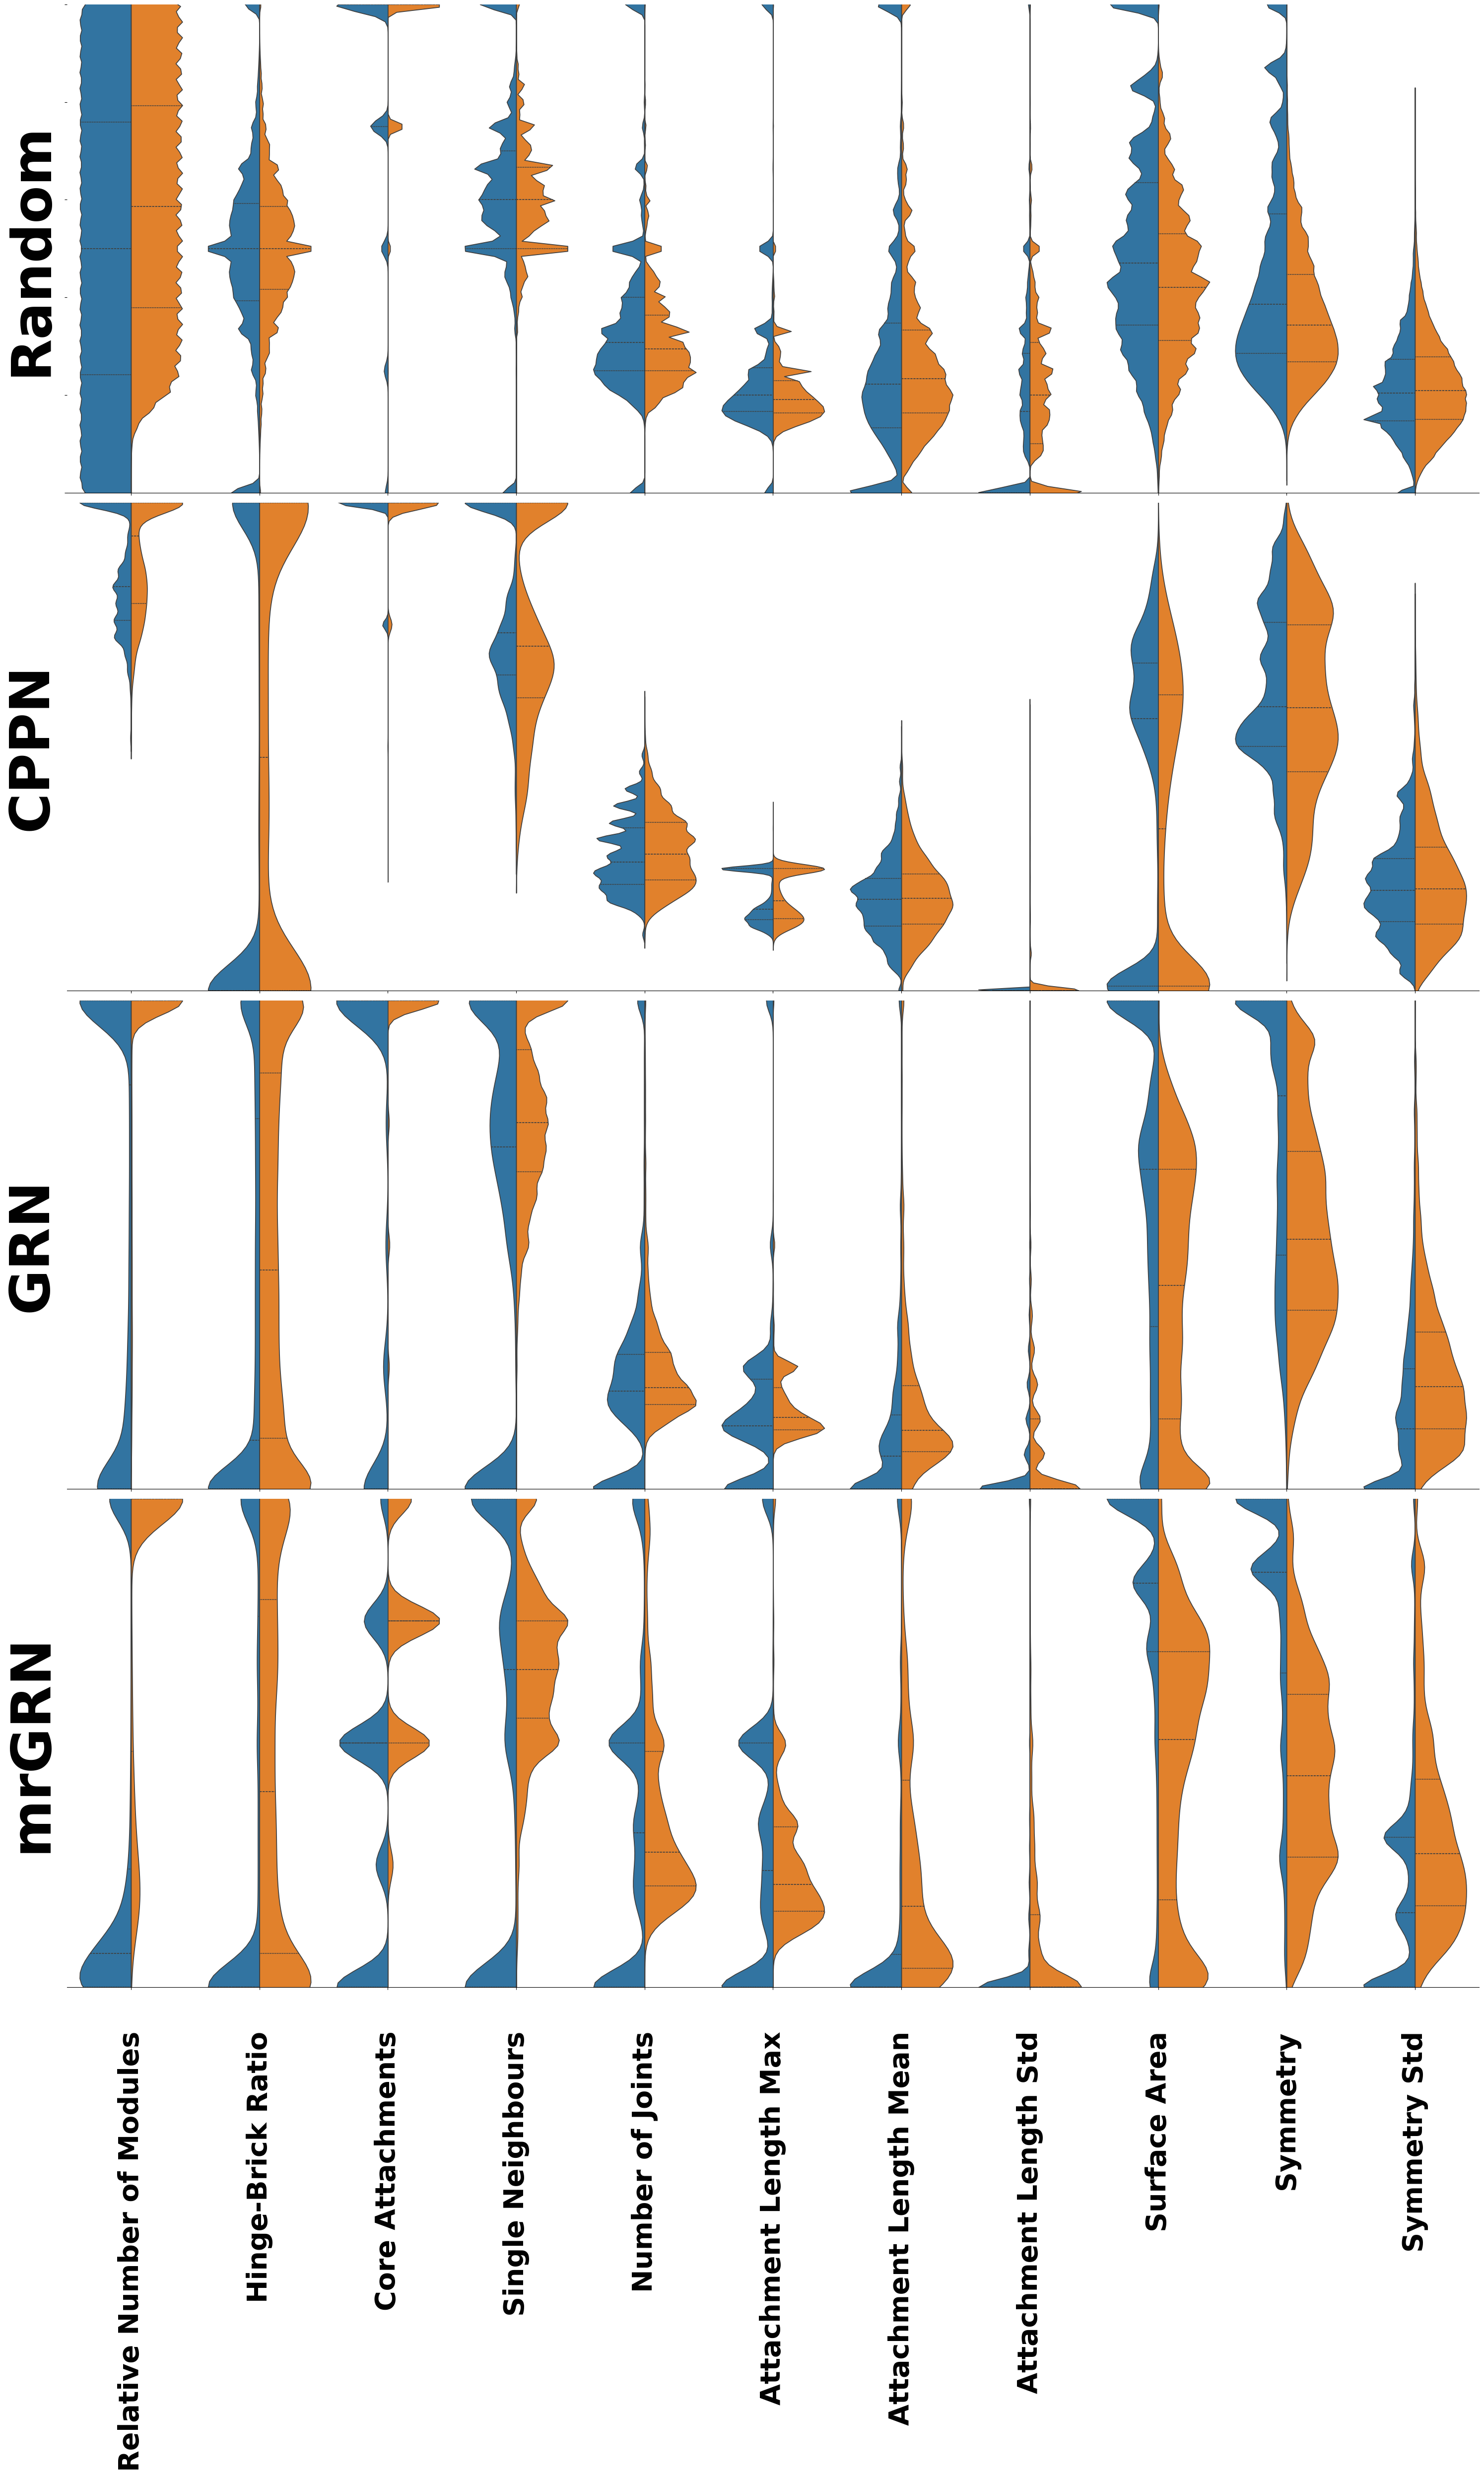

In [10]:
mode = "Random Search"
# Initialize
if mode == "Evolution":
    fig, ax = plt.subplots(3, 1, figsize=(30, 30))
else:
    fig, ax = plt.subplots(4, 1, figsize=(30, 50))
plt.subplots_adjust(hspace=1)

# for mode in ["Evolution", "Random Search"]:
# Drop evolution data
df_exp.loc[df_exp["Algorithm"] == "Random", "Mode"] = "Random Search"
df_exp2 = df_exp.loc[df_exp["Mode"] == mode, :]

if mode == "Evolution":
    df_exp2 = df_exp2.loc[df_exp2["generation_index"] == 1200, :]

# Append random data n times
rows = []
temporarydf = df_exp2.loc[df_exp2["Algorithm"] == "Random", :]
temporarydf = temporarydf.loc[temporarydf["count"] > 1, :]

for irow, row in temporarydf.iterrows():
    if row["count"] != 1:
        rows += [row] * int(row["count"] - 1)
        
repeated_df = pd.DataFrame(rows).reset_index(drop=True)
df_exp2 = pd.concat([df_exp2, repeated_df], axis=0, ignore_index=True)

# ---- Violin plots
if mode == "Evolution":
    algos = ["CPPN", "GRN", "GRN_system"]
else:
    algos = ["Random", "CPPN", "GRN", "GRN_system"]


for ialgo, algo in enumerate(algos):
    # Get data for violin plot
    data4violin = []
    for col in ["Relative Number of Modules", "Joint-Brick Ratio", "Core Attachments", "Single Neighbours",
                "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std", "Number of Joints",
                "Surface Area", 'Symmetry_incl_sum', "Symmetry_incl_std",
                ]:

        # Select subset of data --> unique bodies or all? + column
        for type_run in ["All", "Unique"]:
            if type_run == "Unique":
                sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index"]]
            else:
                sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, [col, "generation_index"]]
  
            # Transform
            sub_df[col] = (sub_df[col] - df_exp[col].min()) / (df_exp[col].max() - df_exp[col].min())
            # Append
            sub_df.rename(columns={col: "Variable"}, inplace=True)
            sub_df["column_label"] = col
            sub_df["Type"] = type_run
            data4violin.append(sub_df)
    
    # Concat dfs
    data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

    # Group data
    # Plot
    sns.violinplot(data4violin, x = "column_label", y = "Variable", split=True, hue = "Type", gap=0, inner="quart",
                   scale = "width", ax = ax[ialgo])
    ax[ialgo].set_xlabel("")
    ax[ialgo].set_ylabel("")
    
    if ialgo == 0:
        # ax[ialgo].set_xticklabels(["Relative Number of Modules", "Hinge-Brick Ratio", "Core Attachments", 
        #             "Single Neighbours", "Number of Joints", 
        #             "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std",
        #             "Surface Area", 'Symmetry', "Symmetry Std",
        #             ], rotation = 90, fontsize = 40, fontweight = 'bold')
        # ax[ialgo].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, pad = 60,
        #                       left = False)
        ax[ialgo].set_xticklabels([])
    elif (ialgo == 3) or (ialgo == 2 and mode == "Evolution"): 
        ax[ialgo].set_xticklabels(["Relative Number of Modules", "Hinge-Brick Ratio", "Core Attachments", 
                    "Single Neighbours", "Number of Joints", 
                    "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std",
                    "Surface Area", 'Symmetry', "Symmetry Std",
                    ], rotation = 90, fontsize = 40, fontweight = 'bold')
        ax[ialgo].tick_params(pad = 60, left = False)
    else:
        ax[ialgo].set_xticklabels([])
        ax[ialgo].tick_params(pad = 60, left = False)

    ax[ialgo].set_ylim(0, 1)
    ax[ialgo].set_yticklabels(["" for tick in ax[ialgo].get_yticks()], fontsize = 20, fontweight = 'bold')
    #ax[ialgo].set_yticklabels([tick.round(2) for tick in ax[ialgo].get_yticks()], fontsize = 20, fontweight = 'bold')
    # if algo != "GRN_system":
    #     ax[ialgo].set_title(algo, fontsize = 40, fontweight = 'bold', pad = 30, y= 1.0, loc = "center")
    # else:
    #     ax[ialgo].set_title("mrGRN", fontsize = 40, fontweight = 'bold', pad = 30, y= 1.0, loc = "center")
    ax[ialgo].text(-0.025, 0.5, algo if algo != "GRN_system" else "mrGRN", fontsize = 80, fontweight = 'bold', ha = "center", 
                   va = "center", transform = ax[ialgo].transAxes, rotation = 90)
    
    # Remove right and top spines
    sns.despine(top = True, right = True, left = True)
    ax[ialgo].legend().remove()
    plt.tight_layout()
    #plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search" + f"\\{type_run}\\{col}.png")
    #plt.close()
plt.show()

# Line Heat Map

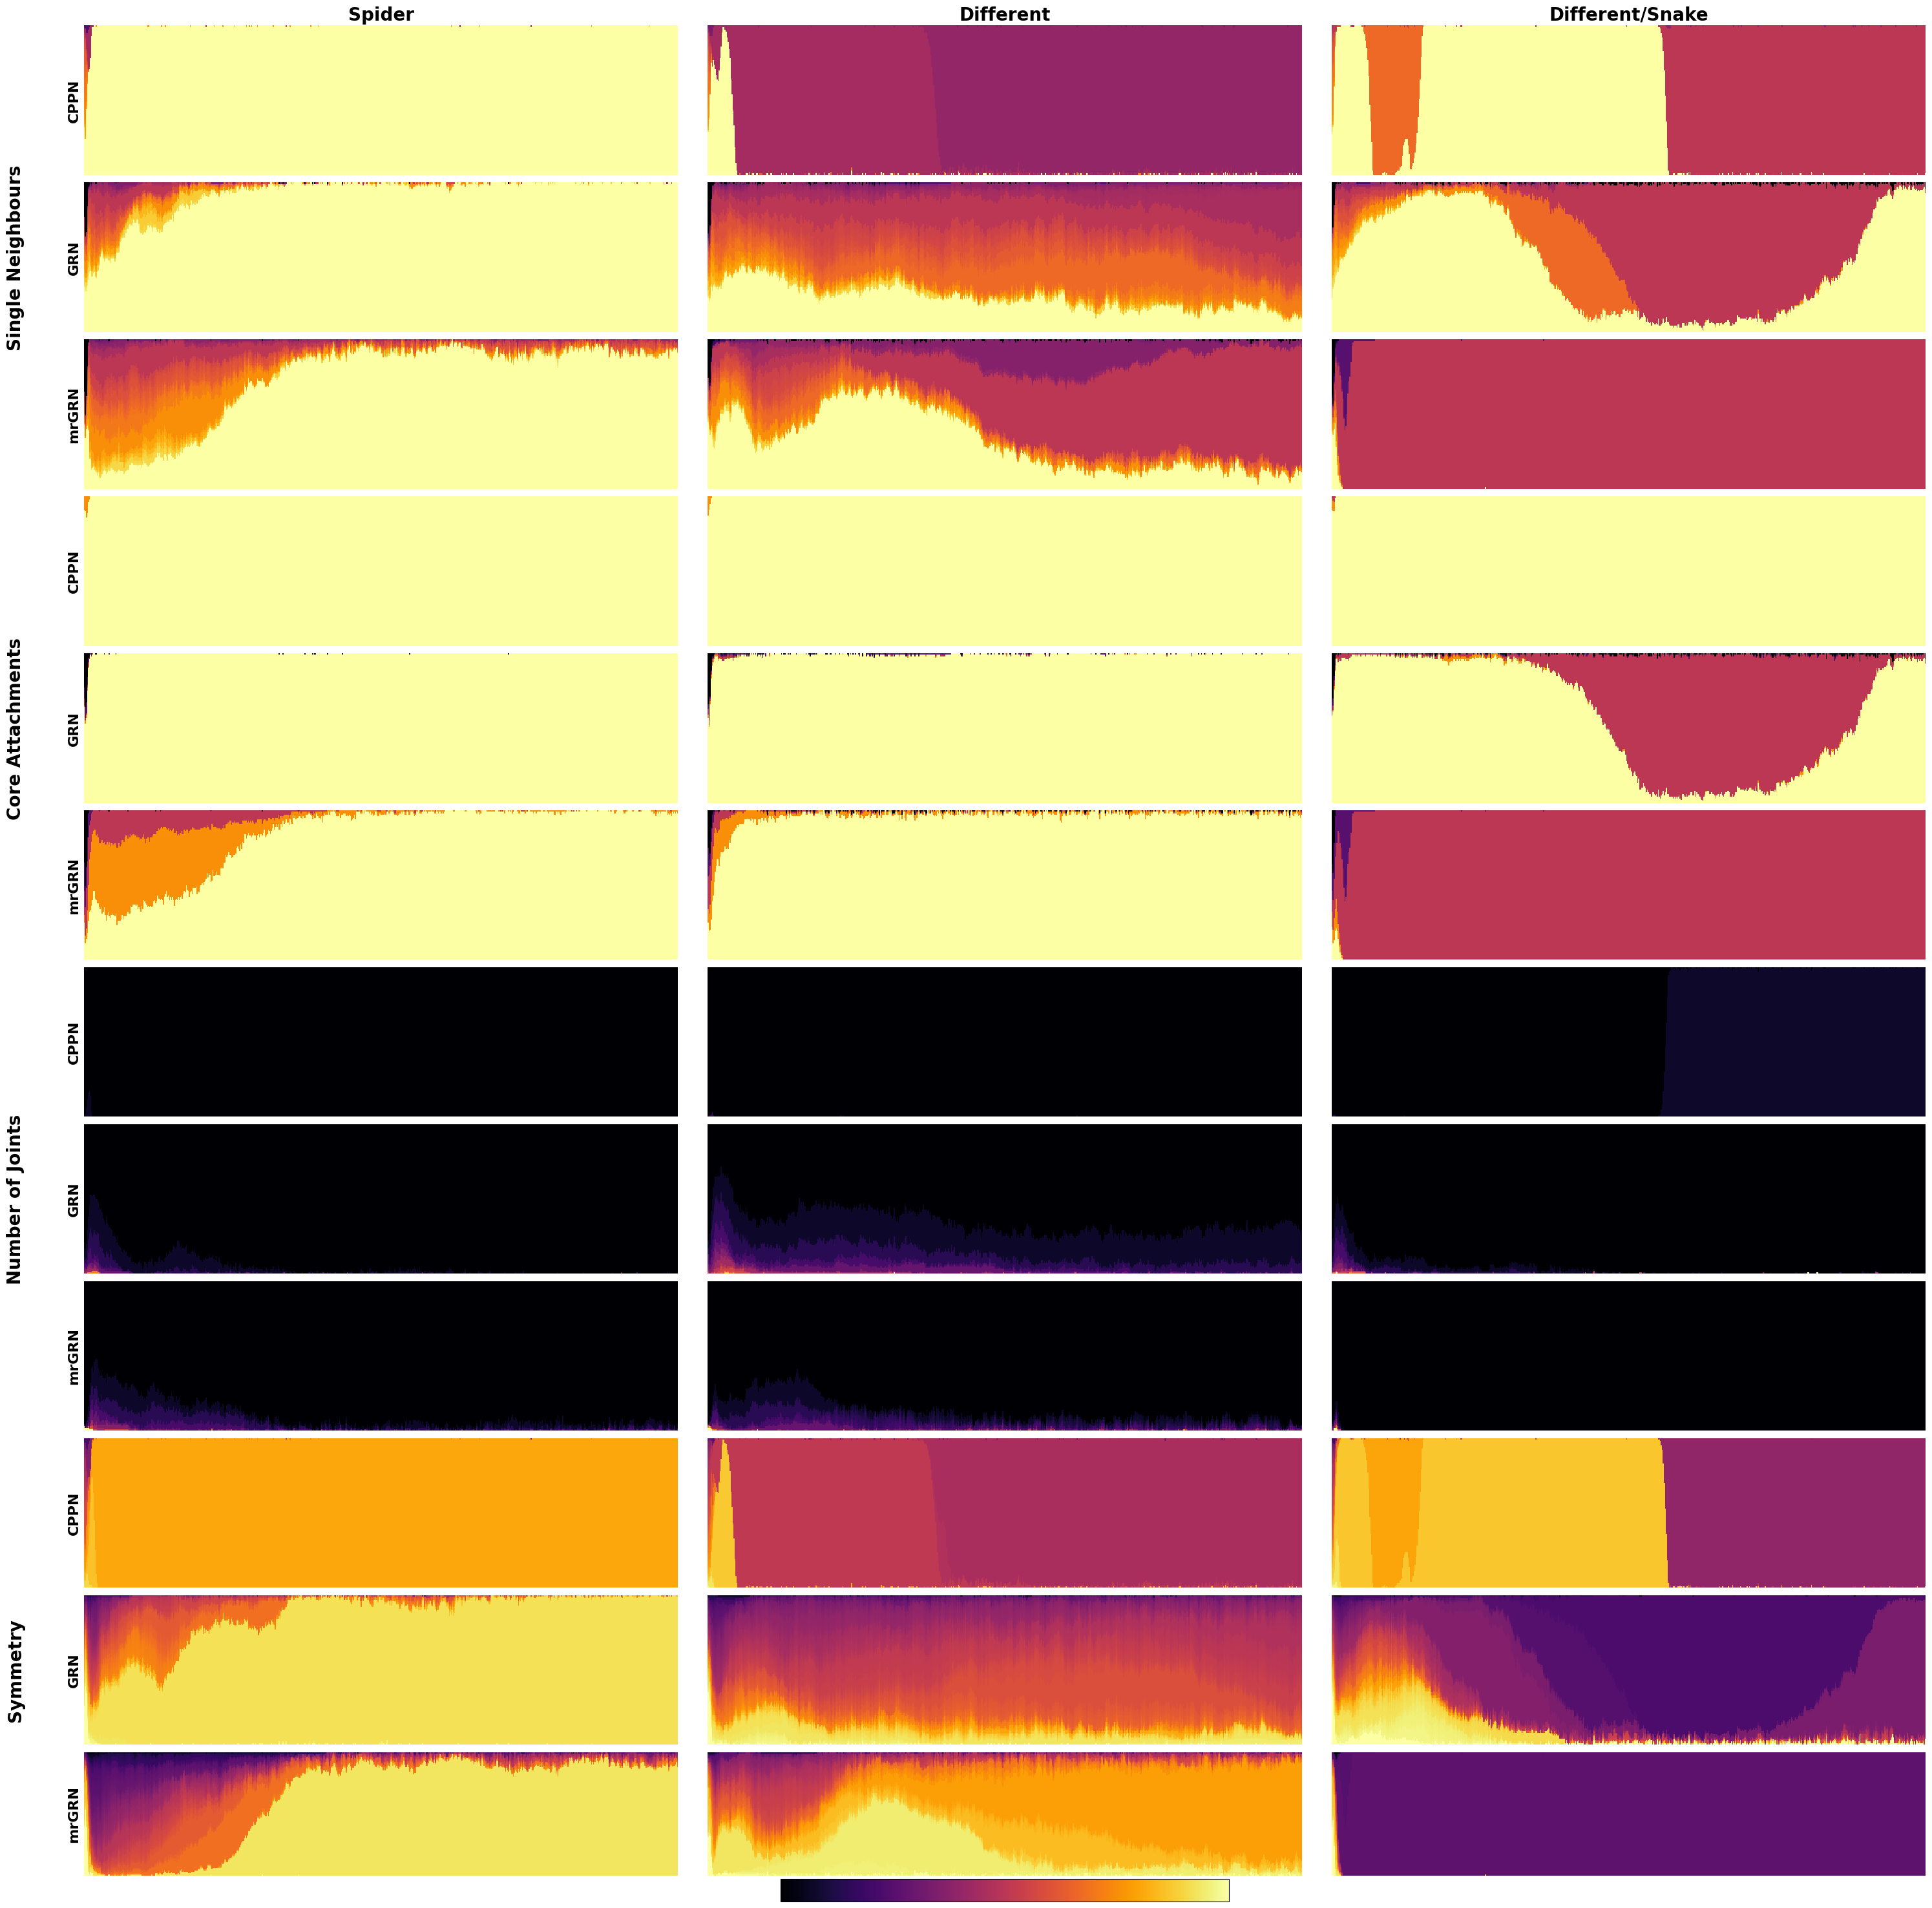

In [92]:
algo_label = ["CPPN", "GRN", "mrGRN"]

# Initialize subplots
fig, ax = plt.subplots(12, 3, figsize=(30, 30))

# Experiments
experiments = {"CPPN": [1, 6, 18], "GRN": [17, 6, 13], "GRN_system": [4, 5, 16]}


for ialgo, algo in enumerate(list(experiments.keys())):
    # CPPN spiders: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20]
    # GRN snakes: [13, 2, 5, 19, 1]
    # GRN_system snakes: [16, 6, 3, 14, 1, 23, 15]
    # Initialize subfigure
    for iexp, experiment in enumerate(experiments[algo]):
        for mode in ["Evolution"]:
            # Select data
            df2 = df_exp.loc[df_exp["Mode"] == mode, :]
            df2 = df2.loc[df_exp["Algorithm"] == algo, :]
            df2 = df2.loc[df2["experiment_id"] == experiment, :]

            if mode == "Evolution":
                # Select only even generations
                df2 = df2.loc[df2["generation_index"] % 2 == 0, :]
                df2.loc[:, "generation_index"] = (df2.loc[:, "generation_index"] / 2).astype(int)
            else:
                pass

            for icol, col in enumerate([columns[_] for _ in [3, 2, 7, 9]]):
                # Get a column for each row according to rank within generation based on col
                df2["rank"] = df2.groupby("generation_index")[col].rank(method='first', ascending=True)
                df2pivot = df2.pivot(index = "rank", columns = "generation_index", values = col)
                # Create the heatmap plot
                heat = sns.heatmap(df2pivot, 
                                cmap='inferno', 
                                linewidths=0, 
                                linecolor='white', vmin = df_exp[col].min(), vmax = df_exp[col].max(),
                                ax = ax[icol * 3 + ialgo, iexp])
                
                # Set the axis labels and title
                heat.set_xlabel('', fontsize=16, fontweight = 'bold')
                if iexp == 0:
                    heat.set_ylabel(algo_label[ialgo], fontsize=16, fontweight = 'bold', rotation = 90)
                else:
                    heat.set_ylabel('', fontsize=16, fontweight = 'bold')
                # heat.set_xlabel('Generations', fontsize=16, fontweight = 'bold')
                # heat.set_ylabel("Robots", fontsize=16, fontweight = 'bold')
                if (ialgo == 1) and (iexp == 0):
                    if col != "Symmetry_incl_sum":
                        label_x = col
                    else:
                        label_x = "Symmetry"

                    ax[icol * 3 + ialgo, iexp].text(-0.1, 0.5, label_x, 
                            transform=ax[icol * 3 + ialgo, iexp].transAxes, fontsize=20, fontweight = 'bold', 
                            verticalalignment='center', horizontalalignment='right', rotation=90)
                if (icol == 0) and (ialgo == 0):
                    if iexp == 0:
                        ax[icol * 3 + ialgo, iexp].set_title("Spider", fontsize=20, fontweight = 'bold')
                    elif iexp == 1:
                        ax[icol * 3 + ialgo, iexp].set_title("Different", fontsize=20, fontweight = 'bold')
                    elif iexp == 2:
                        ax[icol * 3 + ialgo, iexp].set_title("Different/Snake", fontsize=20, fontweight = 'bold')

                # # Set x-axis ticks
                if mode == "Evolution":
                    heat.set_xticks([0, 100, 200, 300, 400, 500, 600])
                    heat.set_xticklabels([0, 100, 200, 300, 400, 500, 600])
                else:
                    heat.set_xticks([0, 10, 20, 30, 40, 50])
                    heat.set_xticklabels([0, 10, 20, 30, 40, 50])

                # Remove y-axis ticks
                heat.set_yticks([])

                # Adjusting the plot layout
                plt.tight_layout()

                # Remove tick indicators and labels
                heat.set_yticks([])
                heat.set_xticks([])

                # Remove colorbar
                heat.collections[0].colorbar.remove()

                if (icol == 3) and (iexp == 2) and (ialgo == 2):
                    quadmesh = heat.get_children()[0]
                    i = cm.ScalarMappable(norm=quadmesh.norm, cmap=quadmesh.cmap)
                # Save the plot
                #plt.savefig(f"{path_root}\\Plots\\HeatMap\\Line\\{mode}\\{algo}\\{col}.png")
                #plt.close()
# Adjust space between subplots
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)

# Create a color bar
cbar = plt.colorbar(i, orientation = "horizontal", ax = [ax[11, 0], ax[11, 1], ax[11, 2]], pad = 0.025)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])

# for j, lab in {0.01: "Low", 12: "High"}.items():
#     cbar.ax.text(j, 0.5, lab, fontweight = "bold", fontsize = 16, color = "white")
# Plot
plt.show()

# Population Diversity

Processing:  CPPN
Processing:  GRN
Processing:  GRN_system


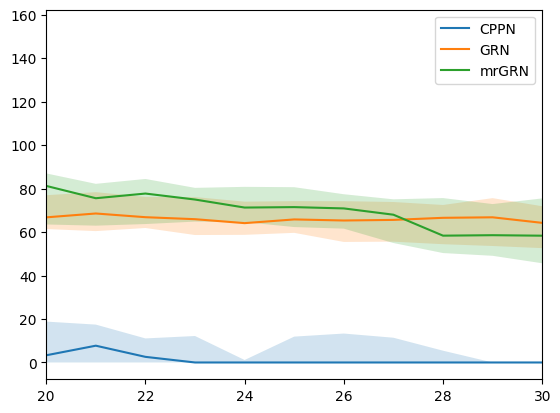

In [46]:
def squared_distances(group):
    # Get points
    points = group.values
    
    if mode == "within":
        # Get distances    
        diff = points[:, np.newaxis] - points[np.newaxis, :]
    elif mode == "between":
        # Get experiment id and generation index
        info = df.loc[group.index[0], ["experiment_id", "generation_index"]]
        # Get previous generation
        prev_gen = max([info["generation_index"] - 1, 0])
        # Create boolean mask
        mask = np.logical_and(df["generation_index"] == prev_gen, df["experiment_id"] == info["experiment_id"])
        
        # Get distances
        diff = points[:, np.newaxis] - df.loc[mask, group.name].values[np.newaxis, :]

    squared_distances = np.sum(np.sum(diff ** 2))
    return squared_distances

# Settings
mode = "within"
best = False
columns = ["Relative Number of Modules", "Joint-Brick Ratio", "Core Attachments", "Single Neighbours",
                "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std", "Number of Joints",
                "Surface Area", 'Symmetry_incl_sum', "Symmetry_incl_std",
                ]

# Initialize
data = {"CPPN": [], "GRN": [], "GRN_system": []}
medians = {"CPPN": [], "GRN": [], "GRN_system": []}

for algo in ["CPPN", "GRN", "GRN_system"]:
    print("Processing: ", algo)
    # Get data
    df = df_exp.loc[df_exp["Mode"] == "Evolution", :]
    df = df.loc[df["Algorithm"] == algo, :]

    if best == True:
        df = df.loc[df["generation_index"] % 10 == 0, :]
        df["generation_index"] /= 10
    else:
        df = df.loc[df["generation_index"] % 2 == 0, :]
        df["generation_index"] /= 2

    # Only retain most fit robot per generation per experiment
    if best == True:
        assert mode == "between", "Best robot can only be selected for comparison between generations."
        df = df.loc[df.groupby(["experiment_id", "generation_index"])["fitness"].idxmax(), :]


    # Normalize data
    for col in columns:
        if col not in ["experiment_id", "generation_index", "Mode", "Algorithm"]:
            df[col] = (df[col] - df_exp[col].min()) / (df_exp[col].max() - df_exp[col].min())


    # Get Distance
    values = df.groupby(["experiment_id", "generation_index"])[columns].agg(squared_distances)
    
    # Add total distance over columns
    values["total"] = np.sqrt(values.sum(axis = 1))
    medians[algo] = values["total"]

    # Get square root of all columns
    for col in columns:
        values[col] = np.sqrt(values[col])

    # Get median, 1q and 3q over experiments
    median = values.groupby(["generation_index"]).median().reset_index()
    fq = values.groupby(["generation_index"]).quantile(0.25).reset_index()
    lq = values.groupby(["generation_index"]).quantile(0.75).reset_index()

    # Store data
    data[algo] += [median, fq, lq]

    column = "total"
    plt.plot(median["generation_index"], median[column], label = algo if algo != "GRN_system" else "mrGRN")
    plt.fill_between(median["generation_index"], fq[column], lq[column], alpha = 0.2)



plt.legend()
plt.xlim(20, 30)
plt.show()


C:\Users\niels\AppData\Local\Temp\ipykernel_3272\1827574275.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, colval].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\1827574275.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, colval].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\1827574275.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, colval].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\1827574275.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, colval].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\1827574275.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row, colval].set_xlim(0, 600)
C:\Users\niels\AppData\Local\Temp\ipykernel_3272\1827574275.py:24: Use

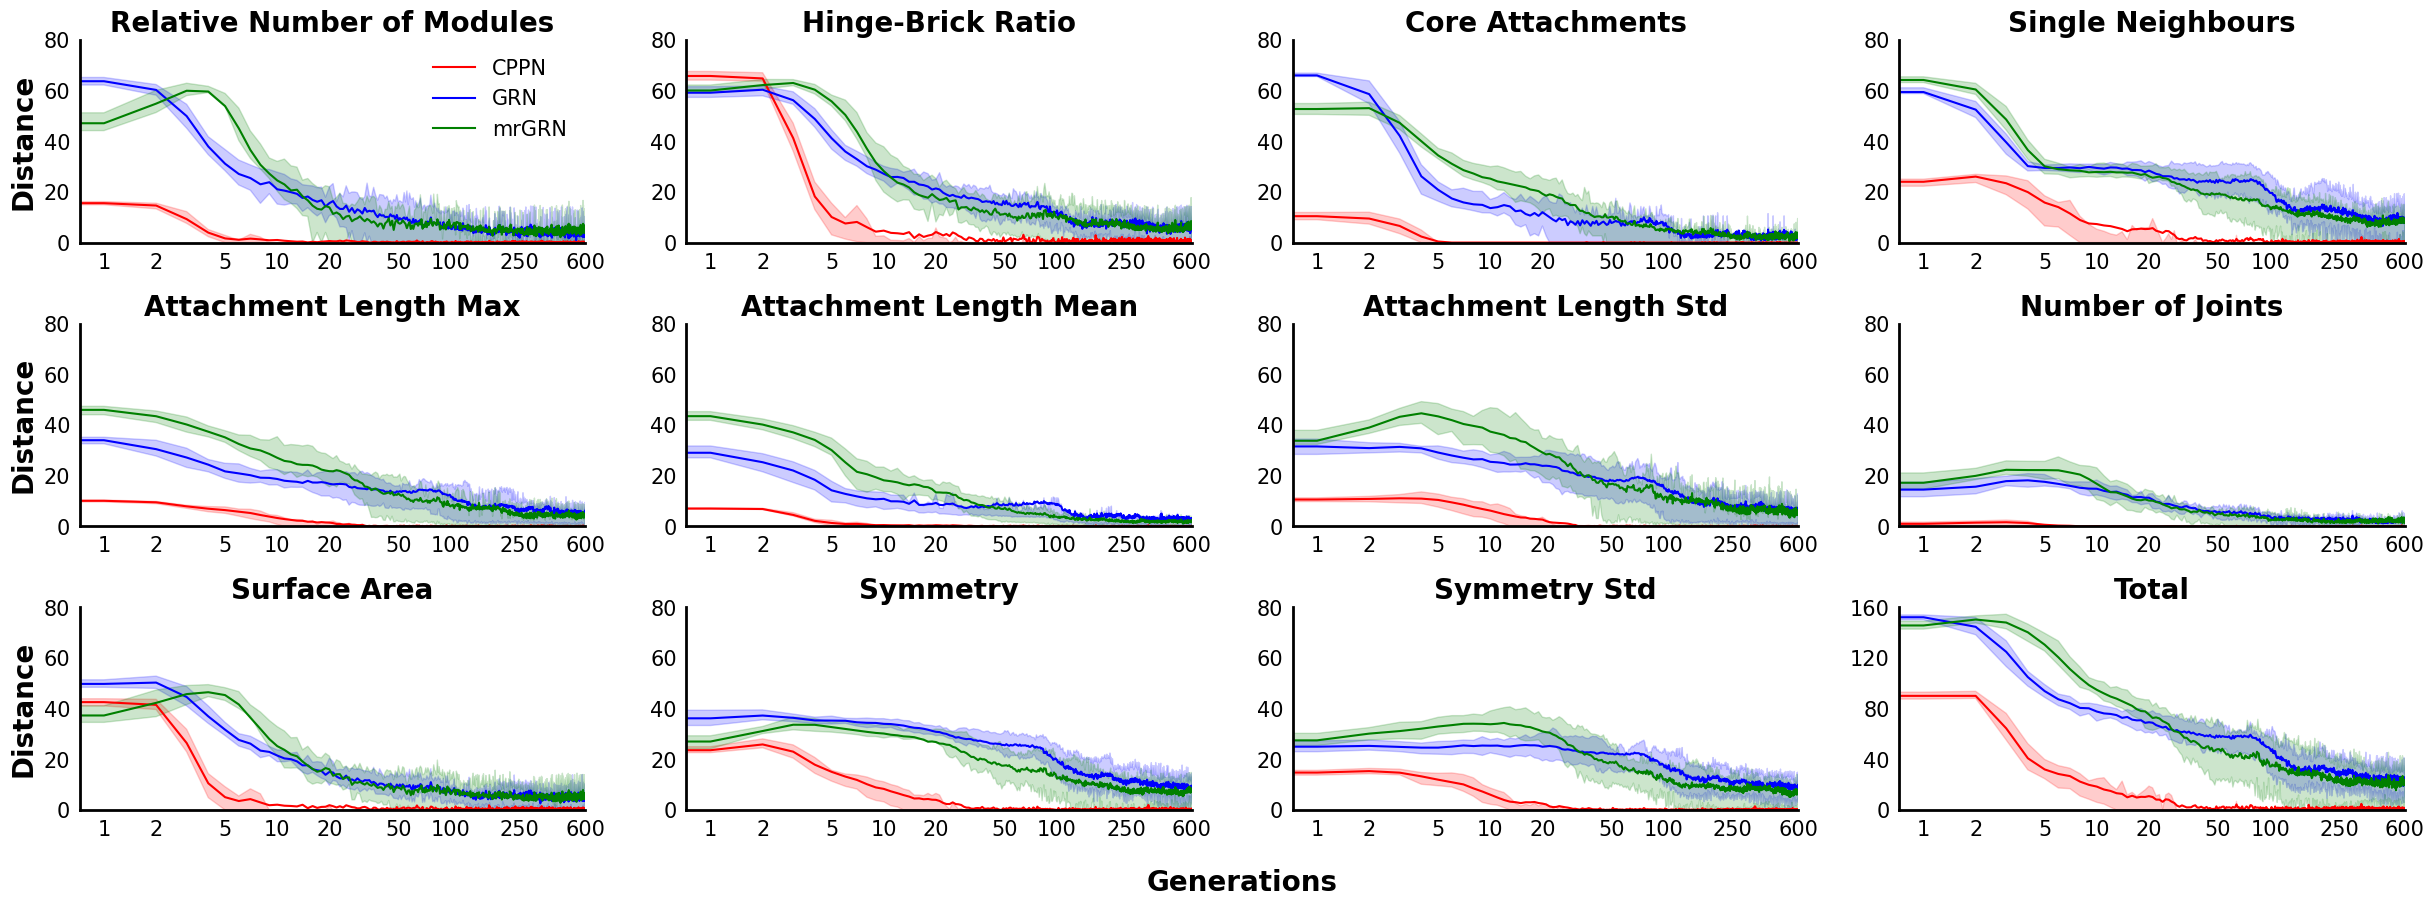

In [43]:
# Settings
colors = ["red", "blue", "green"]
# Intialize
fig, ax = plt.subplots(3, 4, figsize=(30, 10))
plt.subplots_adjust(hspace = 0.4)

for icol, col in enumerate(columns + ["total"]):
    row = icol // 4
    colval = icol % 4
    for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]):
        median = data[algo][0]
        fq = data[algo][1]
        lq = data[algo][2]
        # plot
        ax[row, colval].plot(median["generation_index"], median[col], label = algo if algo != "GRN_system" else "mrGRN",
                             color = colors[ialgo])
        ax[row, colval].fill_between(median["generation_index"], fq[col], lq[col], alpha = 0.2, color = colors[ialgo])


        # Log x-scale
        ax[row, colval].set_xscale("log")
        
        # Axes
        ax[row, colval].set_xlim(0, 600)
        ax[row, colval].set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 600], [1, 2, 5, 10, 20, 50, 100, 250, 600])
        
        if col == "total":
            ax[row, colval].set_ylim(0, 160)
            ax[row, colval].set_yticks([0, 40, 80, 120, 160])
        else:
            ax[row, colval].set_ylim(0, 80)
            ax[row, colval].set_yticks([0, 20, 40, 60, 80])
        
        # Remove minor and major ticks
        ax[row, colval].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                                    labelsize = 15)
        #ax[row, colval].set_xticks([])
        #ax[row, colval].set_yticks([])
        if (ialgo == 0) and (colval == 0):
            ax[row, colval].set_ylabel("Distance", fontsize = 20, fontweight = "bold")

        # Remove spines
        ax[row, colval].spines['top'].set_visible(False)
        ax[row, colval].spines['right'].set_visible(False)

        # Thicker spines
        ax[row, colval].spines['left'].set_linewidth(2)
        ax[row, colval].spines['bottom'].set_linewidth(2)
        


    # Title
    if col not in ["total", "Symmetry_incl_sum", "Symmetry_incl_std", "Joint-Brick Ratio"]:
        ax[row, colval].set_title(col, fontsize = 20, fontweight = "bold")
    elif col == "Symmetry_incl_sum":
        ax[row, colval].set_title("Symmetry", fontsize = 20, fontweight = "bold")
    elif col == "Symmetry_incl_std":
        ax[row, colval].set_title("Symmetry Std", fontsize = 20, fontweight = "bold")
    elif col == "total":
        ax[row, colval].set_title("Total", fontsize = 20, fontweight = "bold")
    elif col == "Joint-Brick Ratio":
        ax[row, colval].set_title("Hinge-Brick Ratio", fontsize = 20, fontweight = "bold")
    
    # Legend
    if (row == 0) and (colval == 0):
        ax[row, colval].legend(frameon = False, fontsize = 15)

# Add xlabel at middle bottom of graph
#ax[0, 1].text(1.1, -0.4, "Generations", fontsize = 20, fontweight = "bold", transform=ax[0, 1].transAxes, ha = "center")
#ax[1, 1].text(1.1, -0.4, "Generations", fontsize = 20, fontweight = "bold", transform=ax[1, 1].transAxes, ha = "center")
ax[2, 1].text(1.1, -0.4, "Generations", fontsize = 20, fontweight = "bold", transform=ax[2, 1].transAxes, ha = "center")

# Set legend + color
#ax[0, 0].text(0.1, 0.85, "Legend", fontsize = 20, fontweight = "bold", transform=ax[0, 0].transAxes)
# ax[0, 0].text(0.1, 0.7, "- CPPN", fontsize = 20, fontweight = "bold", color = "red", transform=ax[0, 0].transAxes)
# ax[0, 0].text(0.1, 0.6, "- GRN", fontsize = 20, fontweight = "bold", color = "blue", transform=ax[0, 0].transAxes)
# ax[0, 0].text(0.1, 0.5, "- mrGRN", fontsize = 20, fontweight = "bold", color = "green", transform=ax[0, 0].transAxes)

# # Remove axes
# ax[0, 0].axis("off")



plt.show()

# Niches Mean

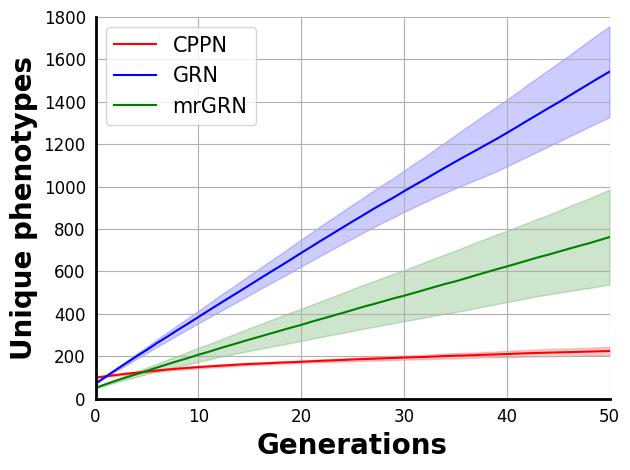

In [20]:
def get_accumulated_phenotypes(df):
    accumulated = [0]
    database = []
    for gen in df["generation_index"].unique():
        # Get unique phenotypes in generation
        unique_phenotypes = df.loc[df_exp["generation_index"] == gen, "id_string"].unique().tolist()
        # Amount not in database
        not_in_db = len(set(unique_phenotypes) - set(database))
        # Add to accumulated
        accumulated.append(accumulated[-1] + not_in_db)
        # Add to database
        database = list(set(database) | set(unique_phenotypes))
    return accumulated


# ---- For all experiments separately: Random Search
for mode in ["Random Search"]:
    for algo in ["CPPN", "GRN", "GRN_system"]:
        accdata = []
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]

        # Get accumulated phenotypes
        for exp in df_exp2["experiment_id"].unique():
            accdata.append(get_accumulated_phenotypes(df_exp2.loc[df_exp["experiment_id"] == exp])[1:])

        # Plot
        if algo == "GRN_system":
            color = "green"
            plt.plot(np.mean(accdata, axis = 0), "-", label = "mrGRN", color = color)
        elif algo == "GRN":
            color = "blue"
            plt.plot(np.mean(accdata, axis = 0), "-", label = "GRN", color = color)
        else:
            color = "red"
            plt.plot(np.mean(accdata, axis = 0), "-", label = "CPPN", color = color)
        plt.fill_between(range(len(accdata[0])), np.mean(accdata, axis = 0) - np.std(accdata, axis = 0), 
                         np.mean(accdata, axis = 0) + np.std(accdata, axis = 0), alpha = 0.2, color = color)
    
    # Set labels and title
    plt.xlabel("Generations", fontsize = 20, fontweight = 'bold')
    plt.ylabel("Unique phenotypes", fontsize = 20, fontweight = 'bold')
    #plt.title(f"Unique Phenotypes over Time", fontsize = 16, fontweight = 'bold')

    # Set xlimit
    plt.xlim(0, 50)
    plt.ylim(0, 1800)

    # Remove upper and right spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # Remove minor ticks
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())
    plt.gca().yaxis.set_minor_locator(plt.NullLocator())
    # Remove ticks but keep labels
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                    labelsize = 12)

    # Set thicker spines
    ax = plt.gca()
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Plot grid, tight layout and legend
    plt.grid()
    plt.tight_layout()
    plt.legend(fontsize = 15)

    #plt.savefig(f"{path_root}\\Plots\\Niches\\{mode}" + f"\\accumulated phenotypes median.png")
    plt.show()
    #plt.close()

# Niches Total

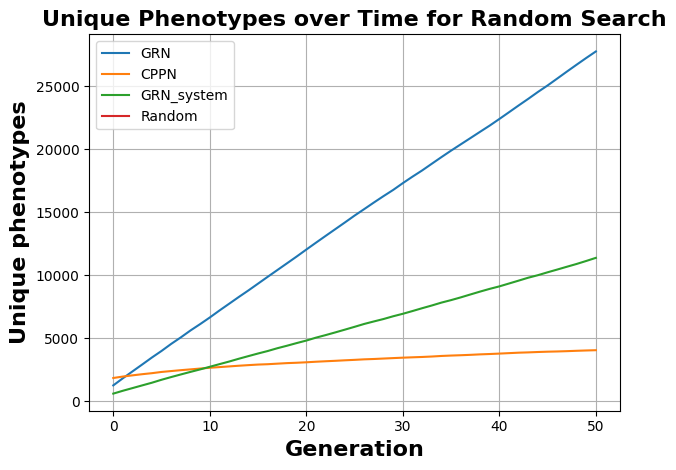

In [11]:
# ---- For all experiments together
for mode in ["Random Search"]:
    for algo in df_exp["Algorithm"].unique():
        accdata = []
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]
        # Get accumulated phenotypes
        accdata = get_accumulated_phenotypes(df_exp2)[1:]
        # Plot
        plt.plot(accdata, "-", label = algo)

    plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Unique phenotypes", fontsize = 16, fontweight = 'bold')
    plt.title(f"Unique Phenotypes over Time for {mode}", fontsize = 16, fontweight = 'bold')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f"{path_root}\\Plots\\Niches\\{mode}" + f"\\accumulated phenotypes total.png")
    #plt.close()
    plt.show()

# Niches Sorted

C:\Users\niels\AppData\Local\Temp\ipykernel_16760\1717160578.py:92: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ref_array[np.abs(ref_array - max_x).argmin() + 1])
C:\Users\niels\AppData\Local\Temp\ipykernel_16760\1717160578.py:93: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ref_array[np.abs(ref_array - max_y).argmin() + 1])


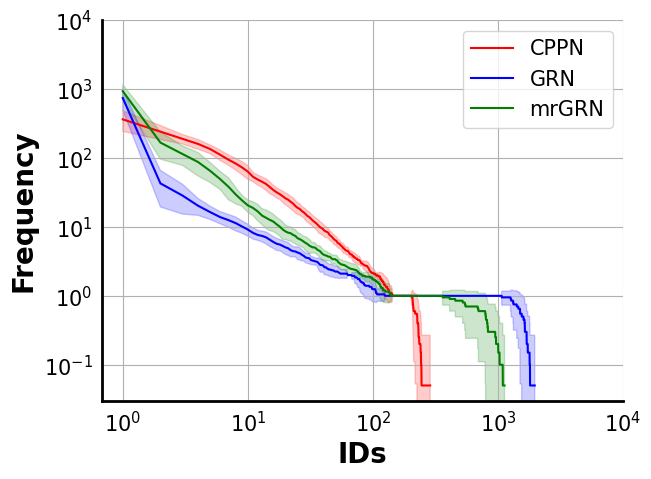

In [19]:
# Settings
meanwise = True#False

# Initialize
max_x = 0
max_y = 0

for type_scale in ["log"]:
    for algo in ["CPPN", "GRN", "GRN_system"]:
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == "Random Search", :]
        # Initialize storage
        storage = []

        # Get data
        if meanwise:
            for exp in df_exp2["experiment_id"].unique():
                # Select experiment
                df_exp3 = df_exp2.loc[df_exp2["experiment_id"] == exp, :]       
                # Get counts of id_strings, sort by count and plot
                phenotype_counts = df_exp3["id_string"].value_counts()
                phenotype_counts.sort_values(ascending = False, inplace = True)
                storage.append(phenotype_counts.values.tolist())
        else:
            df_exp3 = deepcopy(df_exp2)
            # Get counts of id_strings, sort by count and plot
            phenotype_counts = df_exp2["id_string"].value_counts()
            phenotype_counts.sort_values(ascending = False, inplace = True)
            storage.append(phenotype_counts.values.tolist())

        # ----- Plot
        # Color and Dash
        if algo == "CPPN":
            color = "r"
            dash = "-"
        elif algo == "GRN":
            color = "b"
            dash = "-"
        else:
            color = "green"
            dash = "-"
        
        # Adapt Length of data
        if meanwise:
            max_length = 0
            for arr in storage:
                if len(arr) > max_length:
                    max_length = len(arr)
            for iarr, arr in enumerate(storage):
                if len(arr) < max_length:
                    storage[iarr] = arr + [0] * (max_length - len(arr))

        # Convert to numpy array
        storage = np.array(storage)
        mean_data = np.mean(storage, axis = 0)
        std_data = np.std(storage, axis = 0)

        # Plot
        if meanwise:
            if algo == "GRN_system":
                plt.plot(np.arange(1, len(mean_data) + 1), mean_data, dash, color = color, label = "mrGRN")
            else:
                plt.plot(np.arange(1, len(mean_data) + 1), mean_data, dash, color = color, label = algo)
            plt.fill_between(range(1, mean_data.shape[0] + 1), mean_data - std_data, mean_data + std_data, alpha = 0.2, color = color)
        else:
            if algo == "GRN_system":
                plt.plot(np.arange(1, len(mean_data) + 1), mean_data, dash, color = color, label = "mrGRN")
            else:
                plt.plot(np.arange(1, len(mean_data) + 1), mean_data, dash, color = color, label = algo)   
            # Add arrow
            xloc = (mean_data.shape[0] - 1)
            logdistance = (np.log(xloc + 1) - np.log(xloc - 1))
            plt.arrow(xloc, 1, 0, 9,
                    head_width = 0.3 / logdistance, head_length = 3, fc = color, ec = color, linestyle = dash)
            plt.text(xloc, 20, algo if algo != "GRN_system" else "mrGRN", fontsize = 15, color = "k", ha = "center",
                     rotation = 90)

        # ---- Save max values
        if mean_data.shape[0] > max_x:
            max_x = mean_data.shape[0]
        if max(np.mean(storage, axis = 0)) > max_y:
            max_y = max(mean_data)
    
    plt.xlabel("IDs", fontsize = 20, fontweight = 'bold')
    plt.ylabel("Frequency", fontsize = 20, fontweight = 'bold')
    plt.xscale(type_scale)
    plt.yscale(type_scale)

    # Get closest to max x and max y
    ref_array = np.array([0, 10, 100, 1000, 10000, 100000])
    plt.xlim(0, ref_array[np.abs(ref_array - max_x).argmin() + 1])
    plt.ylim(0, ref_array[np.abs(ref_array - max_y).argmin() + 1])
    #plt.savefig(f"{path_root}\\Plots\\Niches\\Random Search" + f"\\phenotype counts_{type_scale}_{algo}.png")
    plt.legend(fontsize = 15)
    plt.grid()
    plt.tight_layout()
    # Remove upper and right spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # Remove minor ticks
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())
    plt.gca().yaxis.set_minor_locator(plt.NullLocator())
    # Remove ticks but keep labels
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                    labelsize = 15)

    # Set thicker spines
    ax = plt.gca()
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    plt.show()


# Bodies to Grid

In [71]:
from develop_from_string import get_body
from itertools import product
from revolve2.modular_robot.body.v2 import ActiveHingeV2, BrickV2
from revolve2.modular_robot.body.base._core import Core
from revolve2.modular_robot.body.v2._attachment_face_core_v2 import AttachmentFaceCoreV2


def create_plot(grid, z = 0):
    """Goal:
        Create a plot of the robot.
    -------------------------------------------------------
    Input:
        grid: The grid of the robot
    -------------------------------------------------------
    Output:
        A plot of the robot."""
    # Create a copy
    newgrid = deepcopy(grid)
    
    # Fill the new grid
    for x, y in product(range(grid.shape[0]), range(grid.shape[1])):
        if type(grid[x, y, z + 1]) == BrickV2:
            newgrid[x, y, z] = 3
        elif type(grid[x, y, z + 1]) == ActiveHingeV2:
            newgrid[x, y, z] = 2
        elif type(grid[x, y, z + 1]) == AttachmentFaceCoreV2:
            newgrid[x, y, z] = 1
        elif type(grid[x, y, z + 1]) == Core:
            newgrid[x, y, z] = 1
        else:
            newgrid[x, y, z] = 0
    
    return newgrid[:, :, z].astype(int)

def string2grid(string):
    # Get max_parts
    splitted = string.split("|")
    max_parts = int(splitted[0])
    # Only core? or should we get the building plan?
    if max_parts == 1:
        dict_coord = None
    elif len(splitted) == 2:
        # ---- Get coordinate data
        substring = splitted[1]
        substring_split = substring.split("-")
        # Fill dictionary with building plan
        # --> {poslin: ["B" or "H", {attachment_point: rotation_index}]}
        dict_coord = {}
        i = 0
        while (i != len(substring_split)) and (substring_split[i] != ""):
            # Linear coordinate
            coord = int(substring_split[i])
            # Information for that coordinate (type, attachment points and orientations)
            info = substring_split[i + 1]
            # Set type of module (Brick or Hinge)
            dict_coord[coord] = []
            dict_coord[coord].append(info[0])
            # Set attachment points and orientations
            if len(info[1:]) > 1:
                dict_coord[coord].append({})
                for j in range(int((len(info) - 1) / 2)):
                    dict_coord[coord][1][int(info[1 + int(j * 2)])] = int(info[1 + (int(j * 2) + 1)])
            else:
                dict_coord[coord].append({})
            # Increase i
            i += 2
    
    # ---- Develop body
    body = get_body(max_parts, dict_coord)

    # ---- Get Grid
    grid, core_grid_position, id_string = body.to_grid(ActiveHingeV2, BrickV2)
    assert string == id_string, "Error in string to grid conversion"

    # ---- Grid to image
    grid = create_plot(grid)
            
    return grid, core_grid_position



# Most Prominent Robots

C:\Users\niels\AppData\Local\Temp\ipykernel_9680\1239039906.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("count", ascending = False, ignore_index = True, inplace = True)


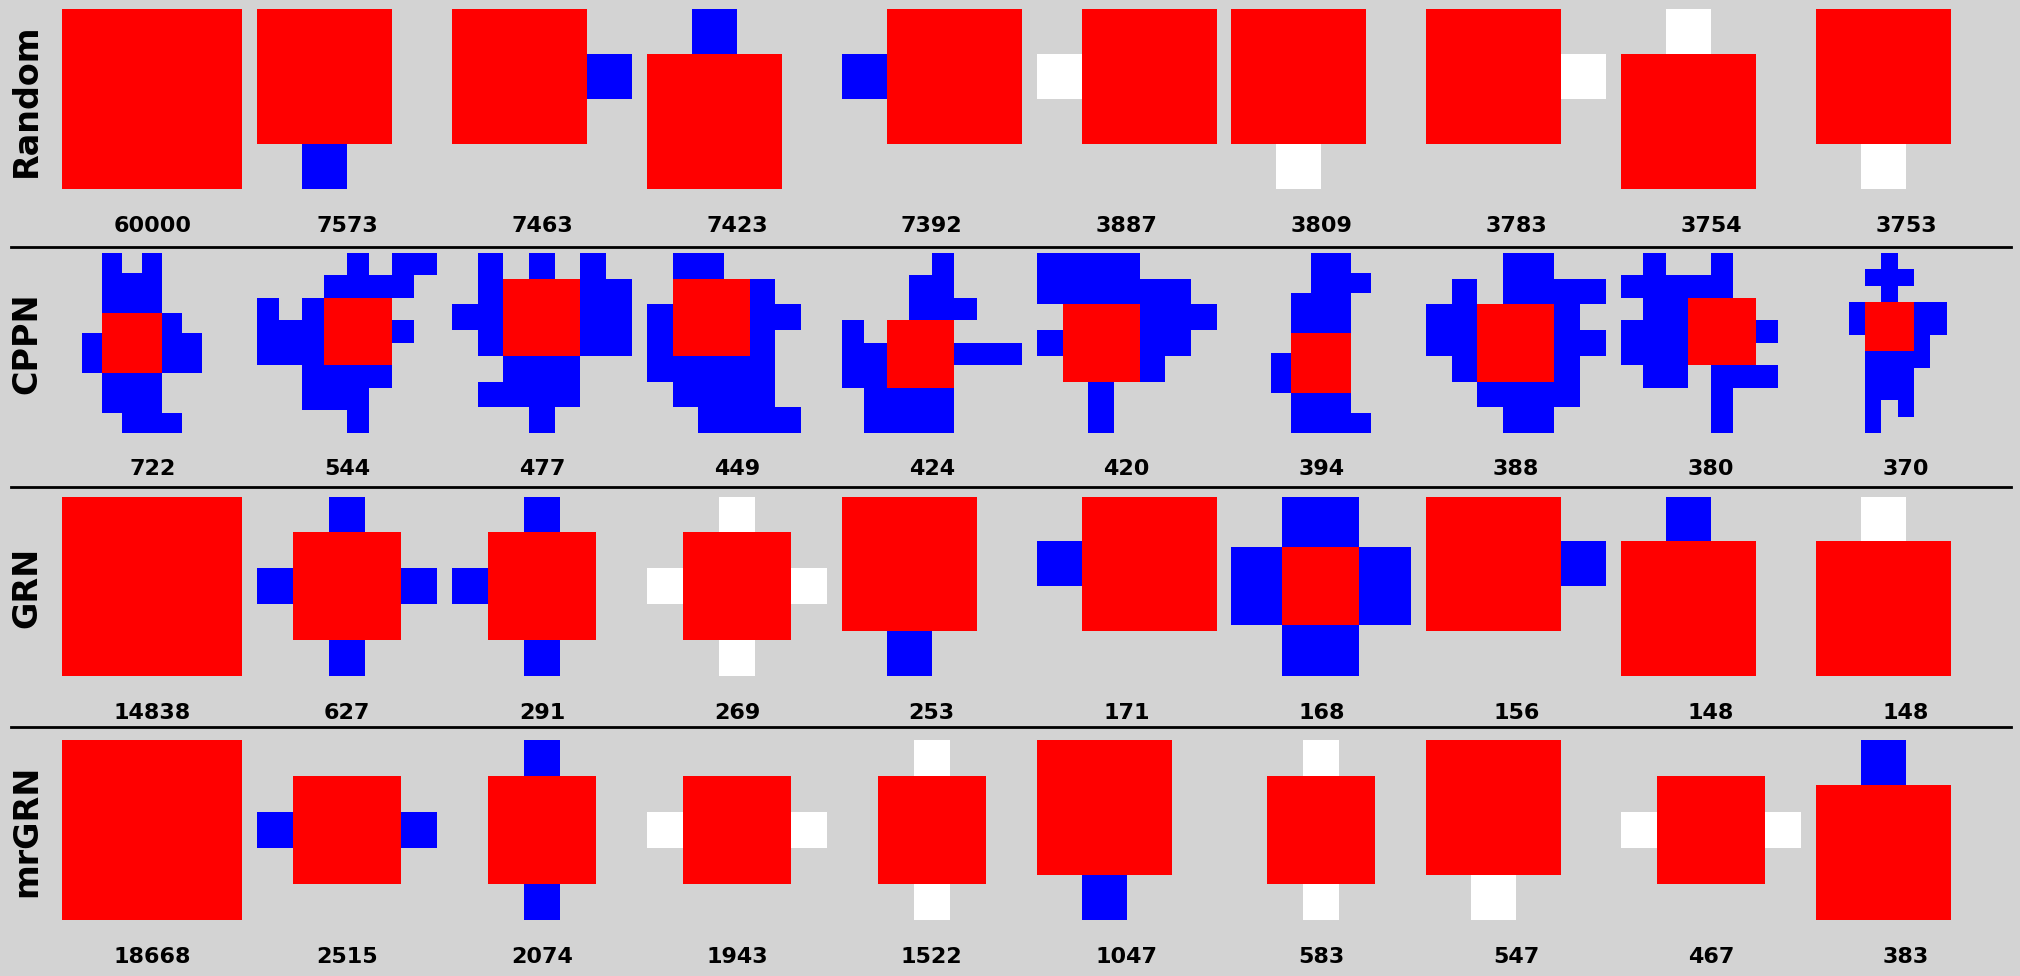

In [72]:
nbodies = 10
nalgos = 4
option = 2
mode = "Random Search"

# Initialize
if option == 1:
    # Option 1
    size = 63
    matrix = np.zeros((nalgos * size + 4, nbodies * size)).astype(int) # (29 * 2) + 3 = 61
    texts = {}
    plt.figure(figsize = (40, 40))
elif option == 2:
    # Option 2
    fig, axs = plt.subplots(nalgos, nbodies, figsize=(20, 10))

# Plot
for ialgo, algo in enumerate(["Random", "CPPN", "GRN", "GRN_system"]):
    # Get data
    df = df_exp.loc[df_exp["Algorithm"] == algo, :]

    # Sort df by count
    if algo == "Random":
        df.sort_values("count", ascending = False, ignore_index = True, inplace = True)
    else:
        df = df.loc[df["Mode"] == mode, :]
        if mode == "Evolution":
            df = df.loc[df["generation_index"] == 1200, :]
        df.loc[:, "count"] = df.groupby("id_string")["id_string"].transform("count").values
        df.drop_duplicates(subset = "id_string", inplace = True)
        df.sort_values("count", ascending = False, ignore_index = True, inplace = True)


    for istring, string in enumerate(df["id_string"][0:nbodies]):
        # Get grid
        grid, core_grid_position = string2grid(string)
        # Fill matrix where center is core_grid_position at 16, 16
        rows, cols = grid.shape

        if option == 1:
            #---- Option 1
            shift1 = (size - (size // 2) + 1) - core_grid_position[0]
            shift2 = (size - (size // 2) + 1) - core_grid_position[1]

            matrix[ialgo *size + shift1:ialgo * size + shift1 + rows, 
                istring * size + shift2:istring * size + shift2 + cols] = grid
            # Save text
            texts[(ialgo * size + size, istring * size + (size // 2) + 1)] = int(df["count"][istring])
        elif option == 2:
            # ---- Option 2
            # Convert grid to square
            size = max(rows, cols)
            grid = np.pad(grid, ((int(np.floor((size - rows) / 2)), int(np.ceil((size - rows) / 2))), 
                                 (int(np.floor((size - cols) / 2)), int(np.ceil((size - cols) / 2)))), 
                                 mode = "constant", constant_values = 0)
            # Color map
            cmap = plt.cm.colors.ListedColormap(['lightgrey', 'red', 'white', 'blue'])
            # Normalize
            norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
            # Plot
            axs[ialgo, istring].imshow(grid, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal")
            # Remove ticks
            axs[ialgo, istring].set_xticks([])
            axs[ialgo, istring].set_yticks([])
            # Remove spines
            axs[ialgo, istring].spines['top'].set_visible(False)
            axs[ialgo, istring].spines['right'].set_visible(False)
            axs[ialgo, istring].spines['left'].set_visible(False)
            axs[ialgo, istring].spines['bottom'].set_visible(False)
            # Plot title
            if istring == 0:
                axs[ialgo, istring].text(-0.2, 0.5, algo if algo != "GRN_system" else "mrGRN", fontsize = 24, fontweight = 'bold', ha = "center", va = "center",
                                         rotation = 90, transform = axs[ialgo, istring].transAxes)
            # Plot xlabel
            axs[ialgo, istring].text(0.5, -0.2, int(df["count"][istring]), fontsize = 16, fontweight = 'bold', 
                                     ha = "center", va = "center", transform = axs[ialgo, istring].transAxes)

# Finish plot
if option == 1:
    #---- Option 1
    # Create a custom colormap with 4 colors
    cmap = plt.cm.colors.ListedColormap(['lightgrey', 'red', 'white', 'blue'])

    # Create a normalized color map
    norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
    # Plot the matrix
    plt.imshow(matrix, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )
    # Add text
    for key, value in texts.items():
        plt.text(key[1], key[0], str(value), fontsize = 20, color = "black", ha = "center", va = "center")
    # Set tick labels
    plt.yticks(np.arange((size // 2), (size // 2) + nalgos * size, size), ["Random", "CPPN", "GRN", "mrGRN"], rotation = 90,
               fontsize = 20, fontweight = 'bold', va = "center")
    plt.xticks(np.arange((size // 2), (size // 2) + nbodies * size, size), "",
               fontsize = 20, fontweight = 'bold')
    # Remove tick indicators
    plt.tick_params(axis='both', which='both', length=0)
    # Remove axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    # Set transparent background
    plt.gca().patch.set_alpha(0)
    plt.margins(0)

elif option == 2:
    # ---- Option 2
    plt.subplots_adjust(hspace = 0.6, wspace = 0.6)
    # Background color
    fig.patch.set_facecolor('lightgrey')

    # Create a horizontal line crossing the whole plot
    import matplotlib.lines as mlines
    line1 = mlines.Line2D([0, 1], [0.24, 0.24], color='k', linewidth=2, transform=fig.transFigure)
    line2 = mlines.Line2D([0, 1], [0.48, 0.48], color='k', linewidth=2, transform=fig.transFigure)
    line3 = mlines.Line2D([0, 1], [0.72, 0.72], color='k', linewidth=2, transform=fig.transFigure)

    # Add the line to the figure
    fig.add_artist(line1)
    fig.add_artist(line2)
    fig.add_artist(line3)

    # Remove margins
    plt.tight_layout()
    plt.margins(0)

plt.show()



In [72]:
def plot4bodies(df, nbodies, path4plots):
    """Goal:
        Code to plot the bodies. By setting df["count"] to 
        a column we can also get those values as text in 
        the plot.
    -------------------------------------------------------
    Input:
        df: The dataframe with the bodies
        nbodies: The number of bodies to plot in one plot
        path4plots: The path to save the plots"""
    # ---- Initialize
    assert np.sqrt(nbodies) % 1 == 0, "Number of bodies should be a square number"
    matrix = np.zeros((int(np.sqrt(nbodies) * 61) + 1, int(np.sqrt(nbodies) * 61) + 1)).astype(int) # (29 * 2) + 3 = 61
    texts = {}

    # ---- Plot
    tot_bodies = 0
    while tot_bodies < df.shape[0]:
        matrix *= 0
        plt.figure(figsize = (100, 100))
        for istring, string in enumerate(df["id_string"][tot_bodies:tot_bodies + nbodies]):
            row = int(istring // np.sqrt(nbodies))
            col = int(istring % np.sqrt(nbodies))
            # Get grid
            grid, core_grid_position = string2grid(string)
            # Fill matrix where center is core_grid_position at 16, 16
            rows, cols = grid.shape
            shift1 = 31 - core_grid_position[0] # 31 modules --> 0:30
            shift2 = 31 - core_grid_position[1]

            matrix[row * 61 + shift1:row * 61 + shift1 + rows, 
                col * 61 + shift2:col * 61 + shift2 + cols] = grid
            # Save text
            texts[(row * 61 + 55, col * 61 + 30)] = int(df["count"][tot_bodies + istring])
            

        # Create a custom colormap with 4 colors
        cmap = plt.cm.colors.ListedColormap(['lightgrey', 'red', 'white', 'blue'])

        # Create a normalized color map
        norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
        # Plot the matrix
        plt.imshow(matrix, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )
        # Add text
        for key, value in texts.items():
            plt.text(key[1], key[0], str(value), fontsize = 20, color = "black", ha = "center", va = "center")
        # Set tick labels
        plt.yticks(np.arange(30, 30 + int(np.sqrt(nbodies)) * 61, 61), 
                ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"], 
                rotation = 90, fontsize = 20, fontweight = 'bold', va = "center")

        plt.xticks(np.arange(30, 30 + nbodies * 61, 61), "",
                fontsize = 20, fontweight = 'bold')


        # Remove tick indicators
        plt.tick_params(axis='both', which='both', length=0)
        # Remove axes
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        # Set transparent background
        plt.gca().patch.set_alpha(0)
        plt.margins(0)

        plt.savefig(path4plots + f"{tot_bodies}-{tot_bodies + nbodies}.png")
        plt.close()

        # Increase tot_bodies
        tot_bodies += nbodies

# Plot Specific Robot

In [ ]:
string = "30|1823-A-1886-A-1887-A01-1950-A01-1951-B11-1952-B20-2014-A01-2016-C40-2018-B-2076-B-2077-A01-2078-B011121-2079-C40-2081-C40-2082-B001020-2083-B-2141-A-2142-A01-2144-C40-2146-B20-2147-B-2204-A-2205-B011121-2206-B001020-2207-B20-2208-B-2269-A01-2270-B-2271-B0111-2272-A-2333-A01-2335-A-2397-A-"
grid, core_grid_position = string2grid(string)

# grid2 = np.concatenate([grid[:, 0:5], grid[:, 6:]], axis = 1)
# grid2[1:4, 3:5] = grid2[0:3, 3:5]
# grid2[5, 4] = 3
# grid2[6, 4] = 0
# grid2[7, 5] = 2
# grid2[6:9, 4] = grid2[6:9, 3]
# grid2[6:9, 3] = 0
# grid2[:, 1:4] = grid2[:, 0:3]
# grid2[:, 0] = 0

# Initialize
plt.figure(figsize = (9, 11))
# Create a custom colormap with 4 colors
cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])
# Create a normalized color map
norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)

# Plot the matrix
plt.imshow(grid, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )
plt.xticks(np.arange(0, 9, 1) - 0.5, "")	
plt.yticks(np.arange(0, 11, 1) - 0.5, "")

# Remove tick indicators
plt.tick_params(axis='both', which='both', length=0)

# Remove axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Set transparent background
plt.gca().patch.set_alpha(0)

plt.grid()
plt.tight_layout()
plt.savefig(f"example_robot3.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

print(df_exp.columns)
print(df_exp.loc[df_exp["id_string"] == string, ['Relative Number of Modules', "Joint-Brick Ratio", "Single Neighbours",
                                                 "Number of Joints", "Attachment Length Max", "Attachment Length Std",
                                                 "Surface Area", "Symmetry_incl_sum", 'Symmetry_incl_std']])

print(df_exp.loc[df_exp["id_string"] == string, ["symmetry_incl1", "symmetry_incl2", "symmetry_incl3", "symmetry_incl4",]])

# Best Robots per Encoding

CPPN
dict_keys([1.0, 15.0, 3.0, 14.0, 17.0, 6.0, 2.0, 5.0, 9.0, 8.0, 13.0, 12.0, 16.0, 18.0, 10.0, 11.0, 20.0, 19.0, 4.0, 7.0])
['+|@', '+|@', '+|@', '+|><', '+|@', 'x|/\\', '+|@', '+|@', '+|@', '+|@', '+|@', '+|><', '+|>< @', 'x|/\\', '+|@', '+|>< @', '+|@', '+|><', '+|@', '+|>< @']
GRN
dict_keys([16.0, 13.0, 2.0, 17.0, 5.0, 19.0, 12.0, 6.0, 14.0, 11.0, 20.0, 7.0, 3.0, 10.0, 9.0, 8.0, 4.0, 15.0, 18.0, 1.0])
['~~|@', '-|!', '-|!', '+|@', '-|!', '-|$', '+|><', 'x|/\\', '+|/\\', 'x|><', '+|><', '+|@', '+|><', '+|>< @', '+|@', 'x|/\\', '+|><', '+|><', 'x|><', '-|@']
GRN_system
dict_keys([16.0, 6.0, 3.0, 14.0, 1.0, 23.0, 5.0, 15.0, 17.0, 25.0, 21.0, 4.0, 19.0, 13.0, 10.0, 9.0, 18.0, 11.0, 20.0, 7.0])
['-|!', '-|!', '-|!', '-|!', '-|!', '-|!', 'x|/\\', '-|$', 'x|><', 'x|()', '~~|%', '+|><', '+|><', 'x|/\\', '+|><', 'x|/\\', '+|>< @', '+|><', 'x|><', '+|><']


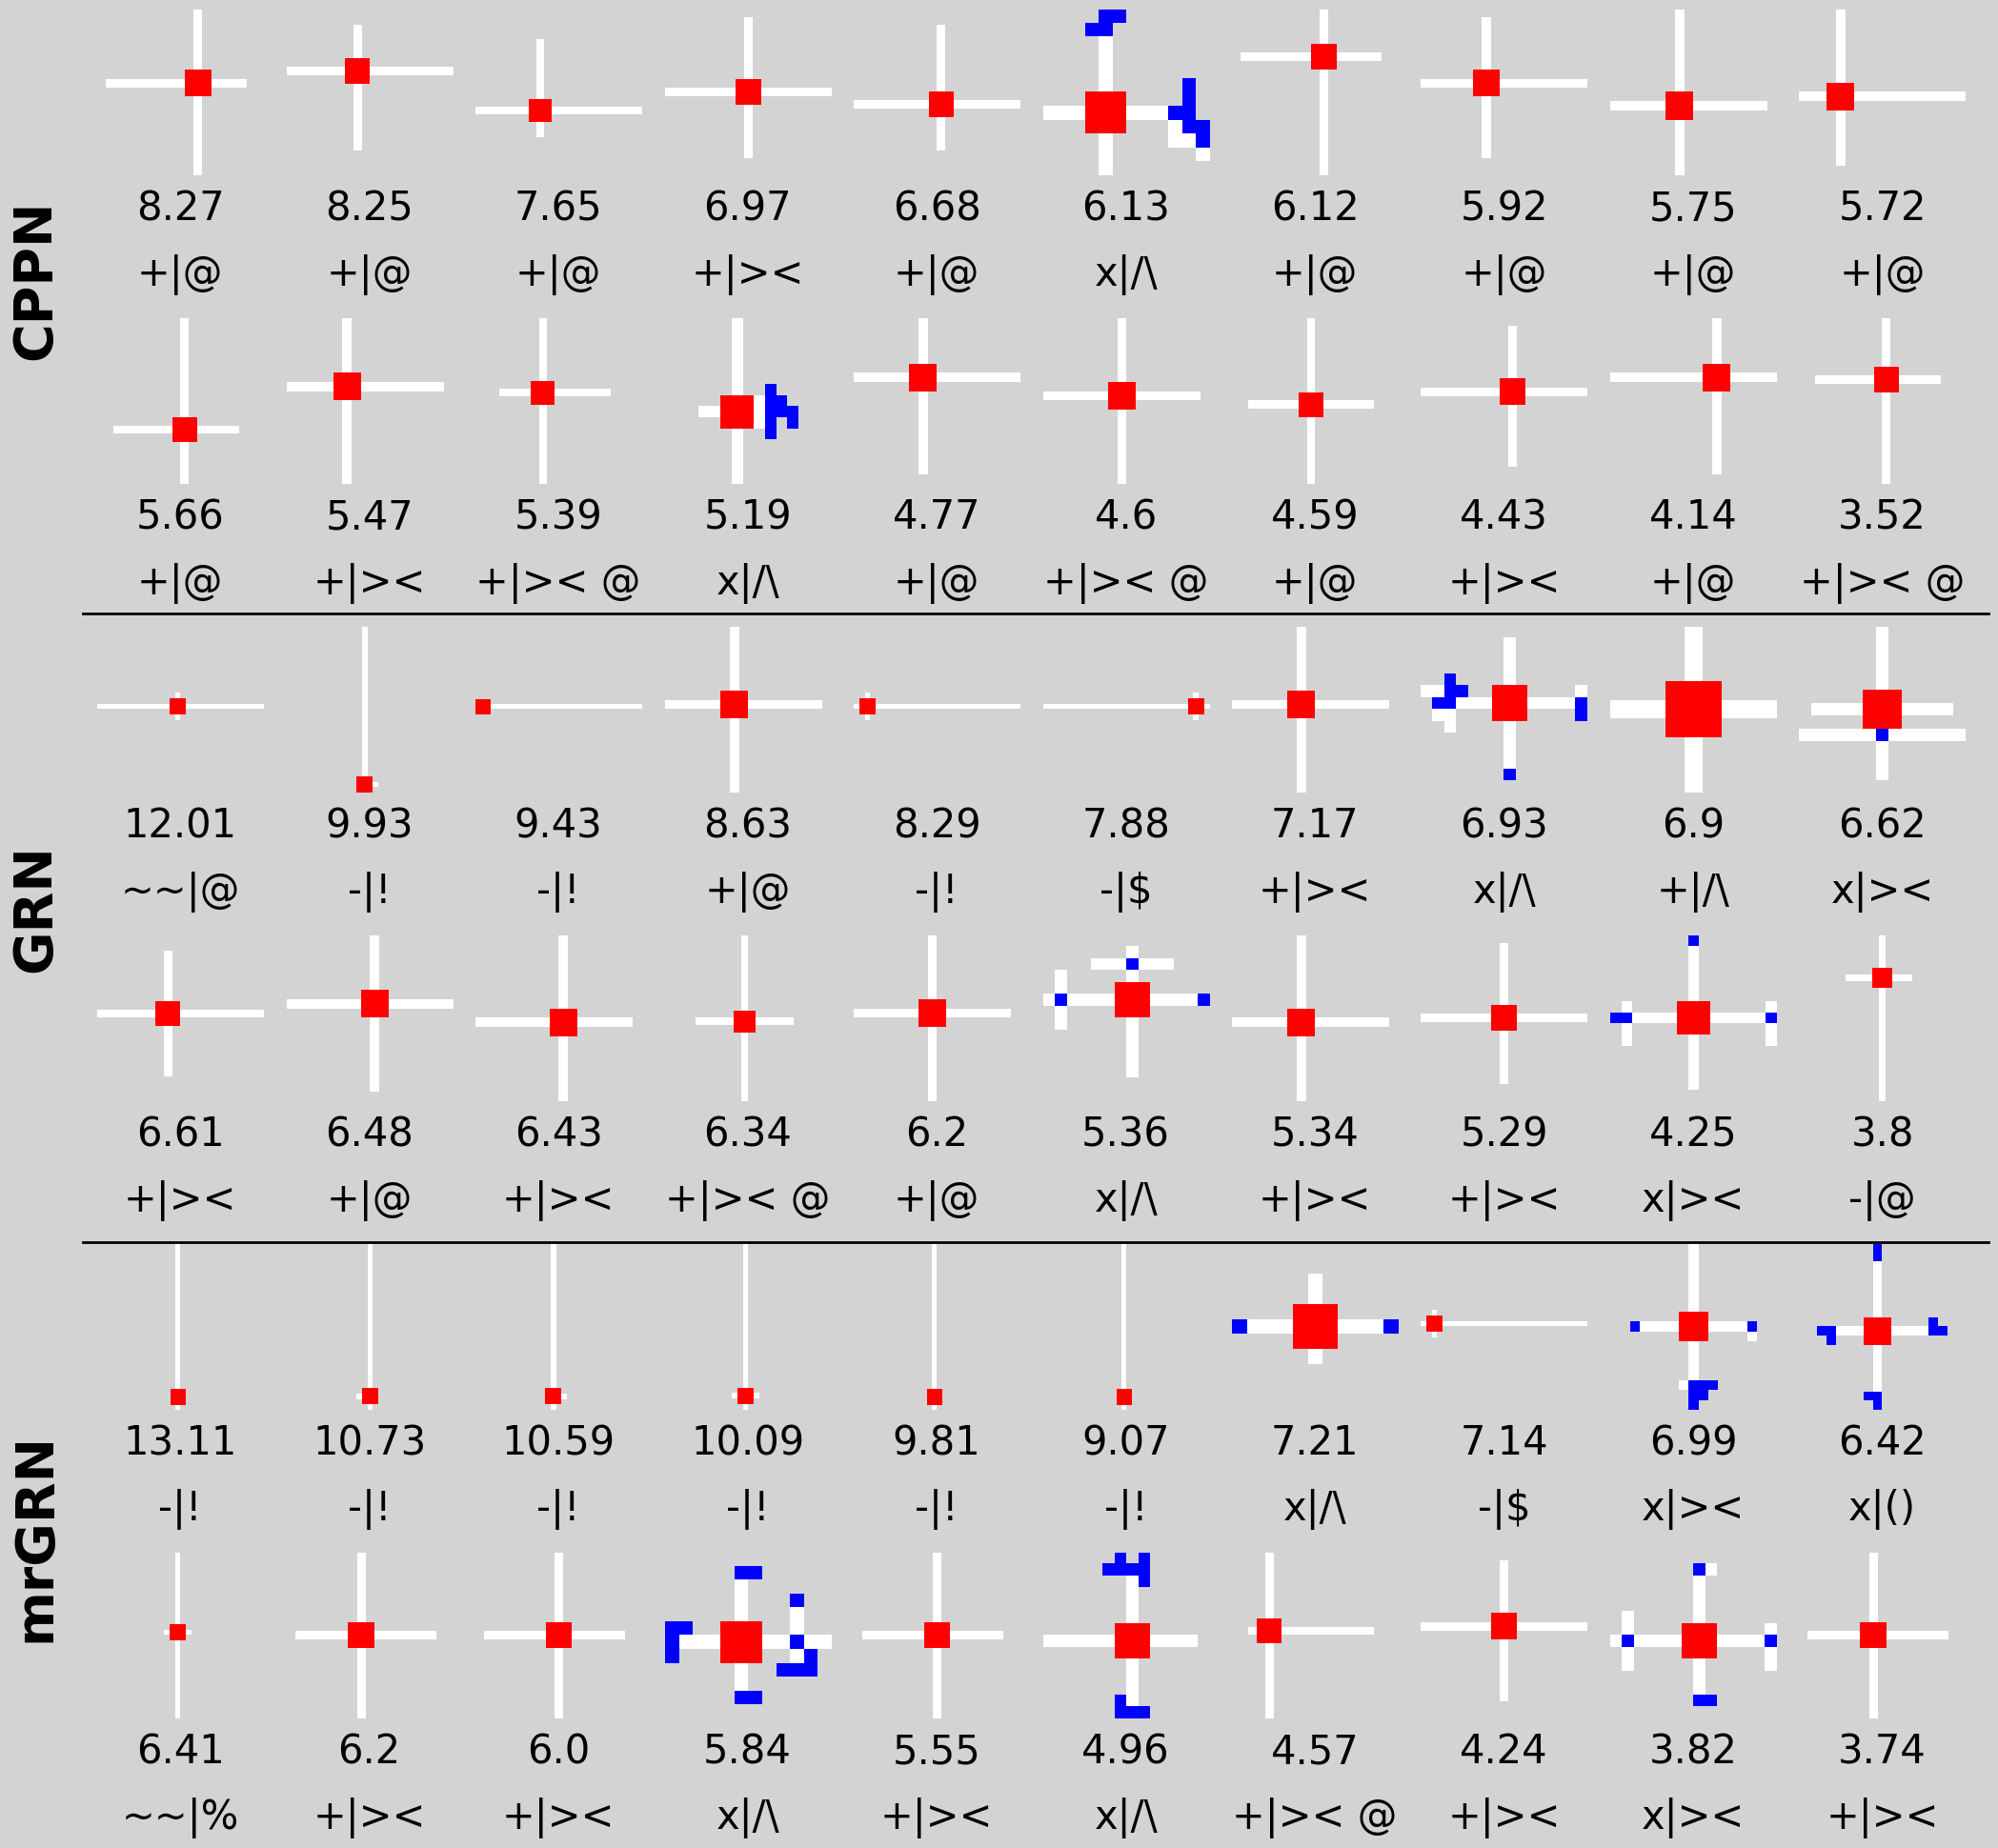

In [118]:
nbodies = 20
nalgos = 3
option = 2
text4behavior = {"CPPN": ["+|@", "+|@", "+|@", "+|><", "+|@", "x|/\\", "+|@",
                          "+|@", "+|@", "+|@", "+|@", "+|><", "+|>< @", "x|/\\",
                          "+|@", "+|>< @", "+|@", "+|><", "+|@", "+|>< @"],
                "GRN": ["~~|@", "-|!", "-|!", "+|@", "-|!", "-|$", 
                        "+|><", "x|/\\", "+|/\\", "x|><", "+|><", "+|@", "+|><", "+|>< @", "+|@",
                        "x|/\\", "+|><", "+|><", "x|><", "-|@"],
                "GRN_system": ["-|!", "-|!", "-|!", "-|!", "-|!", "-|!",
                               "x|/\\", "-|$", "x|><", "x|()", "~~|%", "+|><", "+|><", "x|/\\",
                               "+|><", "x|/\\", "+|>< @", "+|><", "x|><", "+|><"]}

# Initialize
if option == 1:
    matrix = np.zeros((nalgos * 2 *  (61 + 20), int(nbodies / 2 * 61))).astype(int) # (29 * 2) + 3 = 61
    texts = {}
    plt.figure(figsize = (40, 40))
elif option == 2:
    #fig, axs = plt.subplots(nalgos * 2, int(nbodies / 2), figsize=(10, 10))
    fig, axs = plt.subplots(nalgos * 2, 10, figsize=(20, 20))

# Plot
for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]):
    print(algo)
    # Get data
    df = df_exp.loc[df_exp["Algorithm"] == algo, :]
    df = df.loc[df["Mode"] == "Evolution", :]

    # Sort df by fitness
    selected = {}
    for exp in df["experiment_id"].unique():
        # Get maximal fitness and accompanying id_string
        sub_df = df.loc[df["experiment_id"] == exp, :]
        #sub_df = sub_df.loc[sub_df["generation_index"] == 1200, :]
        maxfit = sub_df["fitness"].max()
        id_string = sub_df.loc[sub_df["fitness"] == maxfit, "id_string"].values[0]
        # Add to dictionary
        selected[exp] = (id_string, maxfit)
    
    # Sort by fitness
    selected = dict(sorted(selected.items(), key=lambda item: item[1][1], reverse = True))
    print(selected.keys())
    print(text4behavior[algo])
        
    # Fill matrix
    grids = []
    for istring, experiment in enumerate(list(selected.keys())[0:nbodies]):
        # Get string
        string = selected[experiment][0]
        # Get grid
        grid, core_grid_position = string2grid(string)
        # Fill matrix where center is core_grid_position at 16, 16
        rows, cols = grid.shape

        if option == 1:
            # Option 1
            shift1 = 30 - core_grid_position[0]
            shift2 = 30 - core_grid_position[1]

            if istring < 10:
                matrix[ialgo * 2 * (61 + 20) + shift1:ialgo * 2 * (61 + 20) + shift1 + rows, 
                    istring * 61 + shift2:istring * 61 + shift2 + cols] = grid
                # Save text
                texts[((ialgo * 2) * (61 + 20) + 55, istring * 61 + 30)] = np.around(selected[experiment][1], 2)
            else:
                matrix[(ialgo * 2 + 1) * (61 + 20) + shift1:(ialgo * 2 + 1) * (61 + 20) + shift1 + rows, 
                    (istring - 10) * 61 + shift2:(istring - 10) * 61 + shift2 + cols] = grid
                # Save text
                texts[((ialgo * 2 + 1) * (61 + 20) + 55, (istring - 10) * 61 + 30)] = np.around(selected[experiment][1], 2)
        elif option == 2:
            grids.append(grid)
    
    # ----- Option 2
    if option == 2:
        # Plot figures
        ialgo *= 2
        for istring, grid in enumerate(grids):
            # Get indices
            itext = istring * 1
            experiment = list(selected.keys())[0:nbodies][istring]
            if istring < 10:
                ialgo2 = ialgo * 1
            else: 
                ialgo2 = ialgo + 1
                istring -= 10

            # To square
            rows, cols = grid.shape
            size = max(rows, cols)
            grid = np.pad(grid, ((int(np.floor((size - rows) / 2)), int(np.ceil((size - rows) / 2))), 
                        (int(np.floor((size - cols) / 2)), int(np.ceil((size - cols) / 2)))), 
                        mode = "constant", constant_values = 0)
            # Color map
            cmap = plt.cm.colors.ListedColormap(['lightgrey', 'red', 'white', 'blue'])
            # Normalize
            norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
            # Plot
            axs[ialgo2, istring].imshow(grid, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal")
            # Remove ticks
            axs[ialgo2, istring].set_xticks([])
            axs[ialgo2, istring].set_yticks([])
            # Remove spines
            axs[ialgo2, istring].spines['top'].set_visible(False)
            axs[ialgo2, istring].spines['right'].set_visible(False)
            axs[ialgo2, istring].spines['left'].set_visible(False)
            axs[ialgo2, istring].spines['bottom'].set_visible(False)
            # Plot title
            # if (istring == 0):
            #     axs[ialgo2, istring].text(-0.7, 0.2, algo if algo != "GRN_system" else "mrGRN", fontsize = 30, fontweight = 'bold', ha = "center", va = "center",
            #                              rotation = 90, transform = axs[ialgo2, istring].transAxes)
            # Plot xlabel
            axs[ialgo2, istring].text(0.5, -0.2, np.around(selected[experiment][1], 2), fontsize = 30, 
                                     ha = "center", va = "center", transform = axs[ialgo2, istring].transAxes)
            axs[ialgo2, istring].text(0.5, -0.6, text4behavior[algo][itext], fontsize = 30, 
                                     ha = "center", va = "center", transform = axs[ialgo2, istring].transAxes)
            

if option == 1:
    # Create a custom colormap with 4 colors
    cmap = plt.cm.colors.ListedColormap(['lightgrey', 'red', 'white', 'blue'])

    # Create a normalized color map
    norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
    # Plot the matrix
    plt.imshow(matrix, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )
    # Add text
    for itext, key in enumerate(texts):
        value = texts[key]
        plt.text(key[1], key[0], str(value), fontsize = 15, color = "black", ha = "center", va = "center")
        if itext < 20:
            plt.text(key[1], key[0] + 7, text4behavior["CPPN"][itext], fontsize = 15, color = "black", ha = "center", va = "center")
        elif itext < 40:
            plt.text(key[1], key[0] + 7, text4behavior["GRN"][itext - 20], fontsize = 15, color = "black", ha = "center", va = "center")
        elif itext < 60:
            plt.text(key[1], key[0] + 7, text4behavior["GRN_system"][itext - 40], fontsize = 15, color = "black", ha = "center", va = "center")
        
    # Set tick labels
    # plt.yticks(np.arange((61 + 20), nalgos * 2 *  (61 + 20), 2 * (61 + 20)), ["CPPN", "GRN", "mrGRN"], rotation = 90,
    #         fontsize = 30, fontweight = 'bold', va = "center")
    plt.xticks(np.arange(30, 30 + nbodies * (61 + 20), (61 + 20)), "",
            fontsize = 20, fontweight = 'bold')
    # Horizontal lines
    for i in range(0, 2 * nalgos, 2):
        plt.axhline(i * (61 + 20) - 0.5, color = "black", linewidth = 2)
    # Remove tick indicators
    plt.tick_params(axis='both', which='both', length=0)
    # Remove axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    # Set transparent background
    plt.gca().patch.set_alpha(0)
    plt.margins(0)

elif option == 2:
    # ---- Option 2
    plt.subplots_adjust(hspace = 0.1, wspace = 0)
    # Background color
    fig.patch.set_facecolor('lightgrey')

    # Create a horizontal line crossing the whole plot
    import matplotlib.lines as mlines
    line1 = mlines.Line2D([0, 1], [0.32, 0.32], color='k', linewidth=2, transform=fig.transFigure)
    line2 = mlines.Line2D([0, 1], [0.65, 0.65], color='k', linewidth=2, transform=fig.transFigure)

    # Add the line to the figure
    fig.add_artist(line1)
    fig.add_artist(line2)

    # Add title on left side of plot
    fig.text(-0.025, 0.165, 'mrGRN', ha='center', va='center', rotation=90, fontsize = 40, fontweight = 'bold')
    fig.text(-0.025, 0.495, 'GRN', ha='center', va='center', rotation=90, fontsize = 40, fontweight = 'bold')
    fig.text(-0.025, 0.825, 'CPPN', ha='center', va='center', rotation=90, fontsize = 40, fontweight = 'bold')


    # Remove margins
    plt.tight_layout()
    plt.margins(0)

plt.show()


# Elistist Maps

Processing:  CPPN


C:\Users\niels\AppData\Local\Temp\ipykernel_16824\1476049539.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma_r', ngens)


	Experiment:  1.0
	Experiment:  15.0
	Experiment:  3.00
	Experiment:  14.0
	Experiment:  17.0
	Experiment:  6.00
	Experiment:  2.00
	Experiment:  5.00
	Experiment:  9.00
	Experiment:  8.00
	Experiment:  13.0
	Experiment:  12.0
	Experiment:  16.0
	Experiment:  18.0
	Experiment:  10.0
	Experiment:  11.0
	Experiment:  20.0
	Experiment:  19.0
	Experiment:  4.00
	Experiment:  7.00
Processing:  GRN00


C:\Users\niels\AppData\Local\Temp\ipykernel_16824\1476049539.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma_r', ngens)


	Experiment:  16.0
	Experiment:  13.0
	Experiment:  2.00
	Experiment:  17.0
	Experiment:  5.00
	Experiment:  19.0
	Experiment:  12.0
	Experiment:  6.00
	Experiment:  14.0
	Experiment:  11.0
	Experiment:  20.0
	Experiment:  7.00
	Experiment:  3.00
	Experiment:  10.0
	Experiment:  9.00
	Experiment:  8.00
	Experiment:  4.00
	Experiment:  15.0
	Experiment:  18.0
	Experiment:  1.00
Processing:  GRN_system


C:\Users\niels\AppData\Local\Temp\ipykernel_16824\1476049539.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma_r', ngens)


	Experiment:  16.0
	Experiment:  6.00
	Experiment:  3.00
	Experiment:  14.0
	Experiment:  1.00
	Experiment:  23.0
	Experiment:  5.00
	Experiment:  15.0
	Experiment:  17.0
	Experiment:  25.0
	Experiment:  21.0
	Experiment:  4.00
	Experiment:  19.0
	Experiment:  13.0
	Experiment:  10.0
	Experiment:  9.00
	Experiment:  18.0
	Experiment:  11.0
	Experiment:  20.0
	Experiment:  7.00


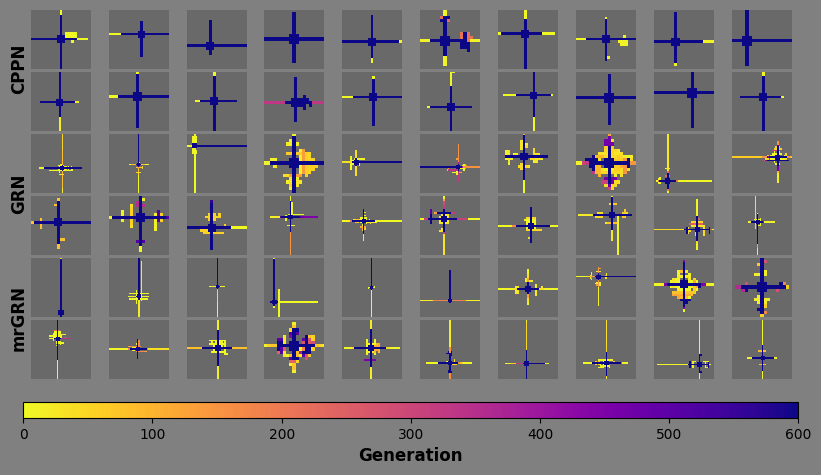

In [125]:
# Initialize
fig, axs = plt.subplots(6, 10, figsize=(10, 6))
ngens = 600

for ialgo, algo in enumerate(["CPPN", "GRN", "GRN_system"]):
    print("Processing: ", algo)
    # Get data
    df = df_exp.loc[df_exp["Algorithm"] == algo, :]
    df = df.loc[df["Mode"] == "Evolution", :]
    # Get most fit robot per generation per experiment
    df = df.loc[df.groupby(["experiment_id", "generation_index"])["fitness"].idxmax(), :]
    # Correct generation index
    df = df.loc[df["generation_index"] % 2 == 0, :]
    df["generation_index"] = df["generation_index"] / 2
    
    # Sort values by maximal fitness
    selected = {}
    for exp in df["experiment_id"].unique():
        # Get maximal fitness and accompanying id_string
        maxfit = df.loc[df["experiment_id"] == exp, "fitness"].max()
        id_string = df.loc[(df["experiment_id"] == exp) & (df["fitness"] == maxfit), "id_string"].values[0]
        # Add to dictionary
        selected[exp] = maxfit
    selected = dict(sorted(selected.items(), key=lambda item: item[1], reverse = True))
    
    # ---- Plot
    # Create colormap range from 0 to 600 + norm
    cmap = plt.cm.get_cmap('plasma_r', ngens)
    norm = plt.cm.colors.Normalize(vmin = 0, vmax = ngens)
    
    ialgo *= 2
    for iexp, exp in enumerate(selected.keys()):
        if iexp == 10:
            ialgo += 1
        iexp = iexp % 10
        print("\tExperiment: ", exp)
        # Initialize matrix
        matrix = np.ones((61, 61), int) * -1
        # Get data
        dfsub = df.loc[df["experiment_id"] == exp, :]
        for igen, generation in enumerate(np.arange(0, ngens + 1, 1)):
            print("\t\tGeneration: ", generation, end = "\r")
            string = dfsub.loc[df["generation_index"] == generation, :]
            string = string.loc[string["experiment_id"] == exp, "id_string"]
            grid, core_grid_position = string2grid(string.values[0])
            grid = np.where(grid == 0, -1, generation)
            grid_nonzero = np.where(grid != -1)
            # Set in grid
            rows, cols = grid.shape
            shift1 = 30 - core_grid_position[0]
            shift2 = 30 - core_grid_position[1]

            matrix[shift1:shift1 + rows, 
            shift2:shift2 + cols][grid_nonzero] = grid[grid_nonzero]

        # ---- Plot
        # Chop subset out of matrix which has non-zero values
        rows, cols = np.where(matrix != -1)
        matrix = matrix[rows.min():rows.max() + 1, cols.min():cols.max() + 1]
        # Pad to square
        size = max(matrix.shape)
        matrix = np.pad(matrix, ((int(np.floor((size - matrix.shape[0]) / 2)), int(np.ceil((size - matrix.shape[0]) / 2))),
                        (int(np.floor((size - matrix.shape[1]) / 2)), int(np.ceil((size - matrix.shape[1]) / 2)))),
                        mode = "constant", constant_values = -1)
        # Handle -1 values
        matrix =  np.ma.masked_where(matrix == -1, matrix)
        # Set -1 to dimgray
        cmap.set_bad(color='dimgray')
        # Plot
        axs[ialgo, iexp].imshow(matrix, cmap = cmap, norm = norm, interpolation = 'none')

        # Label
        if (iexp == 0) and (ialgo % 2 == 0):
            axs[ialgo, iexp].text(-0.2, 0, algo if algo != "GRN_system" else "mrGRN", fontsize = 12, fontweight = 'bold', ha = "center", va = "center",
                                  rotation = 90, transform = axs[ialgo, iexp].transAxes,
                                  color = "k")
        # Remove ticks
        axs[ialgo, iexp].set_xticks([])
        axs[ialgo, iexp].set_yticks([])
        # Remove spines
        axs[ialgo, iexp].spines['top'].set_visible(False)
        axs[ialgo, iexp].spines['right'].set_visible(False)
        axs[ialgo, iexp].spines['left'].set_visible(False)
        axs[ialgo, iexp].spines['bottom'].set_visible(False)

# Adjust
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
# Black background
fig.patch.set_facecolor('gray')

# # Add horizontal lines
# line1 = mlines.Line2D([0, 1], [0.365, 0.365], color='dimgray', linewidth=2, transform=fig.transFigure)
# line2 = mlines.Line2D([0, 1], [0.625, 0.625], color='dimgray', linewidth=2, transform=fig.transFigure)

# # Add the line to the figure
# fig.add_artist(line1)
# fig.add_artist(line2)

# plt.tight_layout()
# plt.margins(0)
# Plot colorbar
cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), ax = axs, orientation = "horizontal", aspect = 50,
                    pad = 0.05)
cbar.set_label("Generation", fontsize = 12, fontweight = 'bold')
plt.show()



In [ ]:
# def pad_grid(grid, core_grid_position):
#     """Goal:
#         Pad the grid with empty modules to create a symmetry grid.
#     ---------------------------------------------------------------------------
#     Input:
#         grid: 
#             The grid of the robot.
#     ---------------------------------------------------------------------------
#     Output:
#         The symmetry grid."""
#     # Get grid shape
#     row, col = grid.shape
#     # Position of core
#     row_offs, col_offs, _ = core_grid_position
#     # Get offsets
#     row_off_top = row_offs - 1 # Minus 1 because of 3 x 3 core block
#     row_off_bottom = (row - 1) - row_offs - 1 # e.g. 0, 1, 2, 3 --> 4 - 1 - 1 - 1 = 1
#     col_off_left = col_offs - 1
#     col_off_right = (col - 1) - col_offs - 1

#     # Creat empty grid
#     diff_off_row = abs(row_off_top - row_off_bottom)
#     diff_off_col = abs(col_off_left - col_off_right)
#     symmetry_grid = np.empty(shape = (row + diff_off_row, col + diff_off_col), dtype = int)
    
#     # Fill with None
#     symmetry_grid.fill(0)
#     # Fill with grid values
#     start_row = 0 if row_off_top >= row_off_bottom else diff_off_row
#     end_row = row if row_off_top >= row_off_bottom else row + diff_off_row
#     start_col = 0 if col_off_left >= col_off_right else diff_off_col
#     end_col = col if col_off_left >= col_off_right else col + diff_off_col
#     symmetry_grid[start_row:end_row, start_col:end_col] = grid[:, :]

#     # Save new core position
#     symmetry_core_coordinates = (start_row + row_offs, start_col + col_offs) 

#     return symmetry_grid, symmetry_core_coordinates


string = df.iloc[1]["id_string"]
grid, core_grid_position = string2grid(string)

# Create a custom colormap with 4 colors
cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])

# Create a normalized color map
norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
# Plot the matrix
plt.imshow(grid, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )

# symmetry_grid, symmetry_core_coordinates = pad_grid(grid, core_grid_position)

# plt.imshow(symmetry_grid)
# plt.grid()

# print(sum(sum(symmetry_grid > 0)))


# print(symmetry_grid)

In [ ]:
# def calculate_symmetry_diag(symmetry_grid, symmetry_core_coordinates, num_modules):
#     """Goal:'
#         Calculate symmetry along the diagonals.
#     ----------------------------------------------------------------------------
#     Input:
#         symmetry_grid: 
#             The symmetry grid.
#         symmetry_core_coordinates:
#             The core coordinates in the symmetry grid.
#     ----------------------------------------------------------------------------
#     Output:
#         * Symmetry along the diagonals including module type
#         * Symmetry along the diagonals excluding module type"""
#     # ---- Initialize
#     diagsyms = [] # Including module type
#     diagsyms_excl = [] # Excluding module type

#     # ---- For all diagonals
#     for diag in [1, -1]: # 1 is from right to left, -1 is from left to right
#         # Initialize
#         num_along_plane = 0
#         num_symmetrical = 0 # Including module type
#         num_symmetrical_excl = 0 # Excluding module type
    
#         # ---- Find start
#         xstart = symmetry_core_coordinates[1]
#         ystart = symmetry_core_coordinates[0]
#         while True:
#             if (((diag == 1) and ((xstart == (symmetry_grid.shape[1] - 1)) or (ystart == 0))) # top right
#                 or
#                 ((diag == -1) and ((xstart == 0) or (ystart == 0)))): # top left
#                 break
#             else:
#                 xstart += diag * 1 # + if from left to right!
#                 ystart -= 1

#         # ---- From core towards left top
#         ypos = ystart
#         xpos = xstart
#         while True:
#             #print(xpos, ypos)
#             if (((diag == 1) and ((xpos < 0) or (ypos > (symmetry_grid.shape[0] - 1)))) # Above left top
#                 or
#                 ((diag == -1) and ((xpos > (symmetry_grid.shape[1] - 1)) or (ypos > (symmetry_grid.shape[0] - 1))))): # Abpve right top
#                 break
#             else:
#                 # Num along plane
#                 if symmetry_grid[ypos, xpos] != 0:
#                     num_along_plane += 1
#                 # Num symmetrical
#                 ypositions = [ypos - (diag * 1), ypos + (diag * 1)] # if from right to left, -1, 1
#                 xpositions = [xpos - 1, xpos + 1]
#                 while True:
#                     if (ypositions[0] < 0) or (ypositions[1] < 0) or (
#                         ypositions[0] > (symmetry_grid.shape[0] - 1)) or (
#                             ypositions[1] > (symmetry_grid.shape[0] - 1)) or (
#                         xpositions[0] < 0) or (xpositions[1] < 0) or (
#                         xpositions[0] > (symmetry_grid.shape[1] - 1)) or (
#                         xpositions[1] > (symmetry_grid.shape[1] - 1)):
#                         break
#                     else:
#                         # # Within core block?
#                         # bool_core = ((xpositions[0] in [symmetry_core_coordinates[1] - 1, symmetry_core_coordinates[1], 
#                         #         symmetry_core_coordinates[1] + 1])

#                         #         and

#                         #         (ypositions[0] in [symmetry_core_coordinates[0] - 1, symmetry_core_coordinates[0],
#                         #                             symmetry_core_coordinates[0] + 1]))
#                         # Check if symmetrical
#                         # First
#                         if (symmetry_grid[ypositions[0], xpositions[0]] != 0) and (
#                             symmetry_grid[ypositions[0], xpositions[0]] ==
#                                 symmetry_grid[ypositions[1], xpositions[1]]):
#                             # if bool_core:
#                             #     pass
#                             # else:
#                             num_symmetrical += 2
#                         # Second (in between)
#                         if (ypositions[0] + 1) < symmetry_grid.shape[0]:
#                             if (symmetry_grid[ypositions[0] + 1, xpositions[0]] != 0):
#                                 print(symmetry_grid[ypositions[0] + 1, xpositions[0]])
#                                 print(symmetry_grid[ypositions[1], xpositions[1] - 1])
#                                 print('------')
#                             if (symmetry_grid[ypositions[0] + 1, xpositions[0]] != 0) and (
#                                 symmetry_grid[ypositions[0] + 1, xpositions[0]] ==
#                                     symmetry_grid[ypositions[1], xpositions[1] - 1]):
#                                 # if bool_core:
#                                 #     pass
#                                 # else:
#                                 print(99999)
#                                 num_symmetrical += 2

                        
#                         if (symmetry_grid[ypositions[0], xpositions[0]] != 0) and (
#                             symmetry_grid[ypositions[1], xpositions[1]] != 0):
#                             # if bool_core:
#                             #     pass
#                             # else:
#                             num_symmetrical_excl += 2

#                         # Adapt positions
#                         ypositions[0] -= (diag * 1) # - if from right to left!
#                         ypositions[1] += (diag * 1) # + if from right to left!
#                         xpositions[0] -= 1
#                         xpositions[1] += 1
#                 # Adapt positions
#                 ypos += 1
#                 xpos -= (diag * 1) # - if from right to left!
#             #print(num_symmetrical)

#         # Calculate difference
#         difference = (num_modules + 2) - num_along_plane # + 2 because of 3 x 3 core block

#         # Assert
#         assert num_symmetrical <= difference
#         assert num_symmetrical_excl <= difference
#         assert num_symmetrical_excl >= num_symmetrical

#         # Calculate the symmetry
#         if difference > 0.0:
#             diagsyms.append(num_symmetrical / difference)
#             diagsyms_excl.append(num_symmetrical_excl / difference)
#         else:
#             diagsyms.append(difference)
#             diagsyms_excl.append(difference)

#     return diagsyms, diagsyms_excl

# calculate_symmetry_diag(symmetry_grid, symmetry_core_coordinates, df.iloc[11]["Modules"])



In [ ]:
storage = {}


for istring, string in enumerate(df_exp.drop_duplicates(subset = "id_string")["id_string"]):
    # Print progress
    print(istring, end = "\r")

    # Get grid
    grid, core_grid_position = string2grid(string)

    # Initialize
    results = []

    # How much on each side from center
    s1 = (grid.shape[0] - 1) - core_grid_position[0]
    s2 = (grid.shape[1] - 1) - core_grid_position[1]
    s3 = core_grid_position[0]
    s4 = core_grid_position[1]

    # Pad new grid with maximum of (s1, s2, s3, s4) at every side
    maxside = max(s1, s2, s3, s4)
    new_grid = np.zeros((maxside * 2 + 1 , maxside * 2 + 1))

    # Place old grid with core at center
    assert (new_grid.shape[0] - 1) % 2 == 0, "New grid should have an odd number of rows"
    middle = int((new_grid.shape[0] - 1) / 2)
    new_grid[maxside - s3:maxside - s3 + grid.shape[0], 
            maxside - s4:maxside - s4 + grid.shape[1]] = grid


    for mode in ["diag1", "diag2", "horizontal", "vertical"]:
        if mode == "diag1":
            # ---- Left top to right bottom diagonal
            # Get lower and upper triangle
            lower = np.tril(new_grid, k = -1)
            upper = np.triu(new_grid, k = 1)
            #upper = np.rot90(np.flipud(upper), 1).astype(int)
            upper = np.transpose(upper)

        elif mode == "diag2":
            # ---- Left bottom to right top diagonal
            # Get lower and upper triangle
            new_grid = np.rot90(new_grid, -1).astype(int)
            lower = np.rot90(np.tril(new_grid, k = -1), 1).astype(int)
            upper = np.rot90(np.triu(new_grid, k = 1), 1).astype(int)
            upper = np.transpose(upper)
            upper = np.fliplr(np.flipud(upper))

        elif mode == "vertical":
            # Around vertical axis
            upper = new_grid[0:maxside, :]
            lower = new_grid[maxside + 1:, :]
            upper = np.flipud(upper)
        elif mode == "horizontal":
            # Around horizontal axis
            upper = new_grid[:, 0:maxside]
            lower = new_grid[:, maxside + 1:]
            upper = np.fliplr(upper)
            # Create a custom colormap with 4 colors
            cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])

        # ---- Symmetry including type
        # Get sum of lower and upper triangle
        equality = np.logical_and((upper == lower), (upper != 0))
        # Calculate symmetry
        counttot = np.sum(upper > 0) + np.sum(lower > 0)
        symmetry = np.sum(equality) * 2 / counttot
        results.append(symmetry)

        # ---- Symmetry excluding type
        equality = np.logical_and((upper > 0), (lower > 0))
        # Calculate symmetry
        symmetry = np.sum(equality) * 2 / counttot
        results.append(symmetry)
    
    # ---- Store values
    storage[string] = results



In [ ]:
df_exp.drop_duplicates(subset = "id_string")["id_string"].to_csv("id_strings.csv", index = False)

Index(['Number of Bricks', 'Number of Hinges', 'Modules',
       'Relative Number of Modules', 'Proportion2D', 'Proportion2D_adapted',
       'Single_Neighbour_Bricks', 'Single Neighbours', 'Double_Neighbours',
       'Attachment Length Max', 'Attachment Length Mean',
       'Attachment Length Std', 'Core Attachments', 'Joint-Brick Ratio',
       'coverage', 'branching', 'Surface Area', 'id_string', 'experiment_id',
       'generation_index', 'individual_index', 'symmetry_incl1',
       'symmetry_excl1', 'symmetry_incl2', 'symmetry_excl2', 'symmetry_incl3',
       'symmetry_excl3', 'symmetry_incl4', 'symmetry_excl4',
       'Number of Joints', 'Algorithm', 'Mode', 'id', 'fitness',
       'mapping_seed', 'count', 'Symmetry_incl_max', 'Symmetry_excl_max',
       'Symmetry_incl_median', 'Symmetry_excl_median', 'Symmetry_incl_sum',
       'Symmetry_excl_sum', 'Symmetry_incl_std', 'Symmetry_excl_std'],
      dtype='object')
30|1434-A-1498-B01-1500-B-1562-A01-1564-A01-1624-B-1625-A01-1626-B0

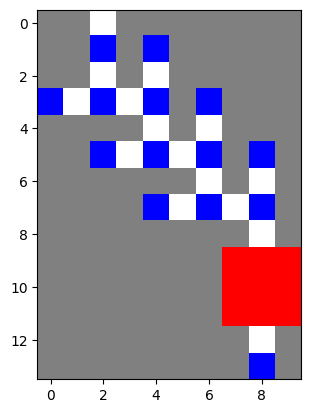

30|2050-A-2051-B01-2052-A01-2053-B01-2054-A01-2055-B01-2056-A01-2057-B01-2058-A01-2059-B01-2060-A01-2061-B01-2062-A01-2063-B01-2064-A01-2065-B01-2066-A01-2067-B01-2068-A01-2069-B01-2070-A01-2071-B01-2072-A01-2073-B01-2074-A01-2075-B01-2076-A01-2077-B01-2078-A01-2079-C41-
5.0
99.0
7478.0
Evolution


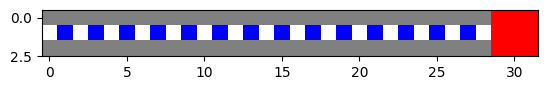

30|2050-A-2051-B01-2052-A01-2053-B01-2054-A01-2055-B01-2056-A01-2057-B01-2058-A01-2059-B01-2060-A01-2061-B01-2062-A01-2063-B01-2064-A01-2065-B01-2066-A01-2067-B01-2068-A01-2069-B01-2070-A01-2071-B01-2072-A01-2073-B01-2074-A01-2075-B01-2076-A01-2077-B01-2078-A01-2079-C41-
5.0
100.0
7478.0
Evolution


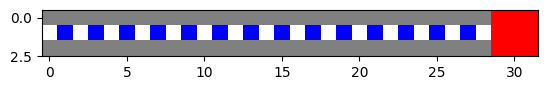

30|2144-C41-2208-A01-2272-B00-2336-A00-2400-B00-2464-A00-2528-B00-2592-A00-2656-B00-2720-A00-2784-B00-2848-A00-2912-B00-2976-A00-3040-B00-3104-A00-3168-B00-3232-A00-3296-B00-3360-A00-3424-B00-3488-A00-3552-B00-3616-A00-3680-B00-3744-A00-3808-B00-3872-A00-3936-B00-4000-A-
11.0
25.0
7478.0
Evolution


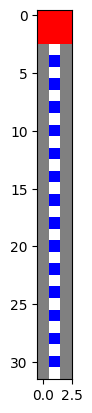

30|1376-B-1440-A01-1504-B01-1568-A01-1632-B01-1696-A01-1760-B01-1824-A01-1888-B01-1952-A01-2016-C41-2081-C41-2082-A01-2083-B01-2084-A01-2085-B01-2086-A01-2087-B01-2088-A01-2089-B01-2090-A-2144-C41-2208-A01-2272-B01-2336-A01-2400-B01-2464-A01-2528-B01-2592-A01-2656-B01-2720-A01-2784-B-
13.0
135.0
7478.0
Evolution


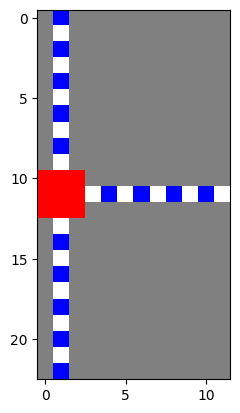

30|1107-A-1108-B11-1172-A01-1236-B11-1237-A01-1238-B11-1302-A01-1366-B11-1367-A01-1368-B11-1432-A01-1496-B11-1497-A01-1498-B11-1562-A01-1626-B11-1627-A01-1628-B11-1692-A01-1756-B11-1757-A01-1758-B11-1822-A01-1886-B11-1887-A01-1888-B11-1952-A01-2016-C41-2144-C40-2208-A00-2272-B-
16.0
147.0
7478.0
Evolution


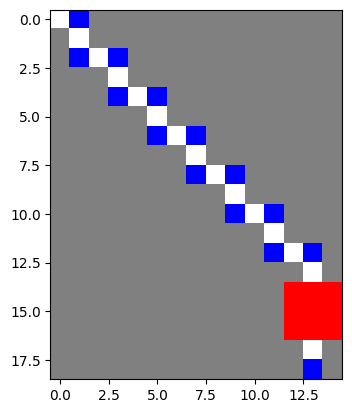

30|2144-C40-2208-A00-2272-B00-2336-A00-2400-B00-2464-A00-2528-B00-2592-A00-2656-B00-2720-A00-2784-B00-2848-A00-2912-B00-2976-A00-3040-B00-3104-A00-3168-B00-3232-A00-3296-B00-3360-A00-3424-B00-3488-A00-3552-B00-3616-A00-3680-B00-3744-A00-3808-B00-3872-A00-3936-B00-4000-A-
21.0
1093.0
7478.0
Evolution


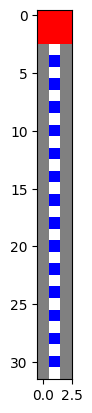

30|2144-C40-2208-A00-2272-B00-2336-A00-2400-B00-2464-A00-2528-B00-2592-A00-2656-B00-2720-A00-2784-B00-2848-A00-2912-B00-2976-A00-3040-B00-3104-A00-3168-B00-3232-A00-3296-B00-3360-A00-3424-B00-3488-A00-3552-B00-3616-A00-3680-B00-3744-A00-3808-B00-3872-A00-3936-B00-4000-A-
21.0
1094.0
7478.0
Evolution


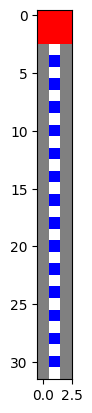

30|1888-B-1952-A01-2016-C41-2144-C41-2208-A01-2272-B0111-2273-A01-2274-B-2336-A01-2398-B-2399-A01-2400-B0111-2464-A01-2528-B0111-2529-A01-2530-B-2592-A01-2654-B-2655-A01-2656-B0111-2720-A01-2784-B0111-2785-A01-2786-B-2848-A01-2910-B-2911-A01-2912-B0111-2976-A01-3040-B01-3104-A-
23.0
713.0
7478.0
Evolution


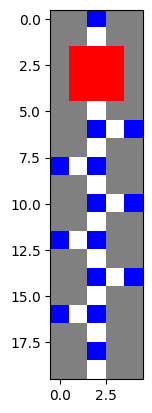

30|1947-B-1948-A01-1949-B1121-1950-A01-1951-B-1953-B-1954-A01-1955-B1121-1956-A01-1957-B-2013-A01-2019-A01-2077-B1121-2078-A01-2079-C41-2081-C41-2082-A01-2083-B1121-2139-A-2141-A01-2147-A01-2203-B1121-2204-A01-2205-B1121-2206-A01-2207-B-2209-B-2210-A01-2211-B1121-2212-A-2267-A-
3.0
337.0
7478.0
Evolution


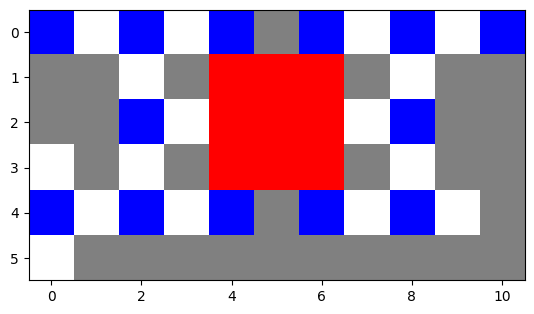

30|1947-B-1948-A01-1949-B1121-1950-A01-1951-B-1953-B-1954-A01-1955-B1121-1956-A01-1957-B-2013-A01-2019-A01-2077-B1121-2078-A01-2079-C41-2081-C41-2082-A01-2083-B1121-2139-A-2141-A01-2147-A01-2203-B1121-2204-A01-2205-B1121-2206-A01-2207-B-2209-B-2210-A01-2211-B1121-2212-A-2267-A-
4.0
27.0
7478.0
Evolution


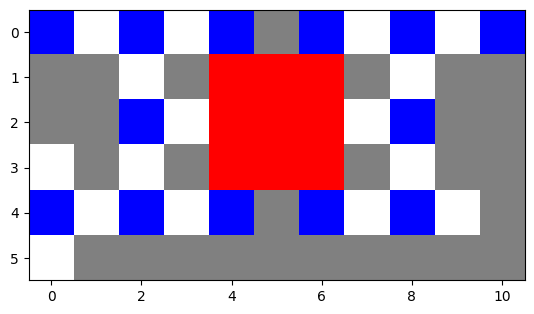

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
0.0
7478.0
Evolution


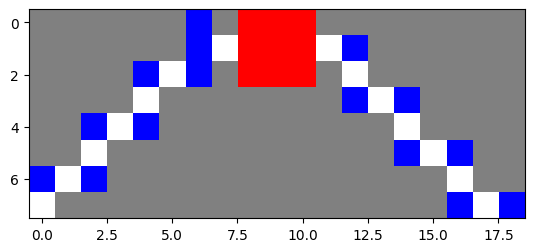

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
2.0
7478.0
Evolution


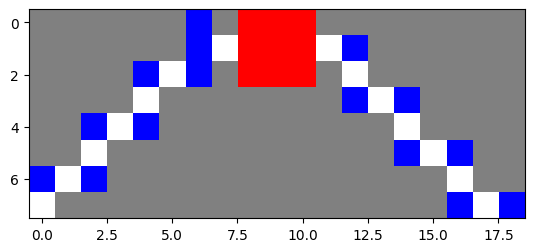

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
4.0
7478.0
Evolution


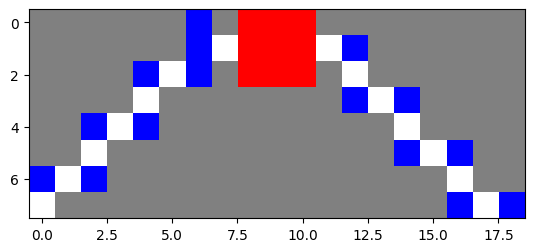

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
6.0
7478.0
Evolution


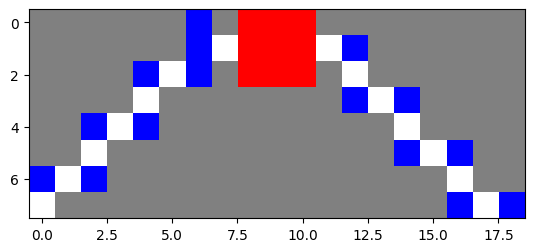

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
8.0
7478.0
Evolution


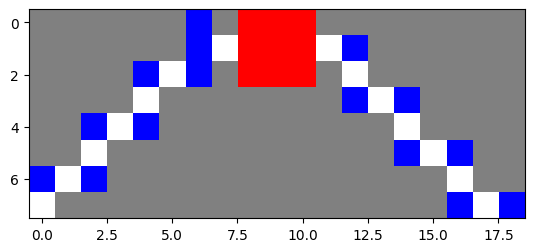

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
10.0
7478.0
Evolution


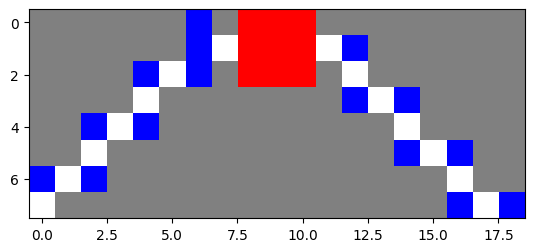

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
12.0
7478.0
Evolution


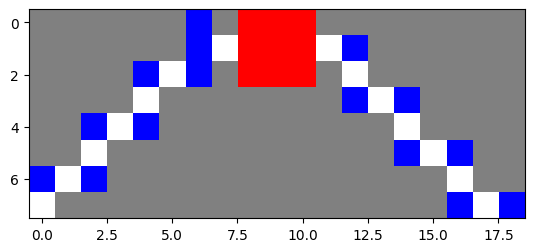

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
14.0
7478.0
Evolution


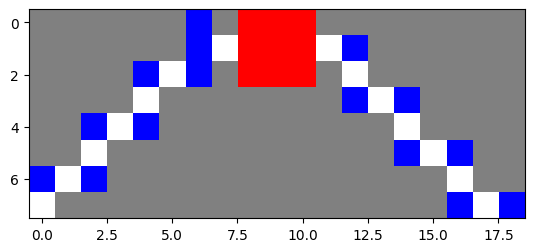

30|2013-B-2077-B1020-2078-A00-2079-C40-2081-C40-2082-A00-2083-B11-2139-B11-2140-A01-2141-B11-2147-A01-2203-A01-2211-B11-2212-A01-2213-B11-2265-B11-2266-A01-2267-B11-2277-A01-2329-A01-2341-B11-2342-A01-2343-B11-2391-B11-2392-A01-2393-B11-2407-A01-2455-A-2471-B11-2472-A01-2473-B-
9.0
16.0
7478.0
Evolution


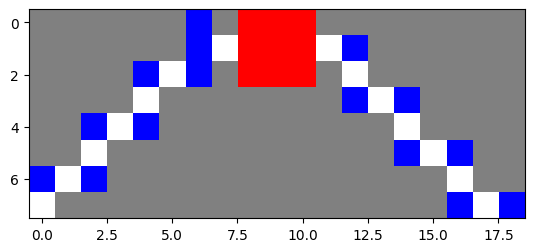

In [44]:
# Get Grn_system
df = df_exp.loc[df_exp["Algorithm"] == "GRN_system", :]
df = df.loc[df["Mode"] == "Evolution", :]
# Sort by number of modules, joints
print(df.columns)
df.sort_values(["Modules", "Number of Joints"], inplace = True, ignore_index = True, ascending = False)

# Plot first 10
for i in range(20):
    string = df.iloc[i]["id_string"]
    print(string)
    print(df.iloc[i]["experiment_id"])
    print(df.iloc[i]["generation_index"])
    print(df.iloc[1].individual_index)
    print(df.iloc[i]["Mode"])
    grid, core_grid_position = string2grid(string)

    # Create a custom colormap with 4 colors
    cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])

    # Create a normalized color map
    norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
    # Plot the matrix
    plt.imshow(grid, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )
    plt.show()


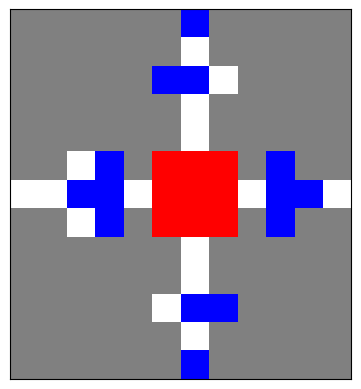

NameError: name 'jhjkl' is not defined

In [32]:
path = "C:\\Users\\niels\\Downloads\\GRN_runs\\GRN vs mrGRN\\GRN\\Notes.txt"

# Create a custom colormap with 4 colors
cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])

# Create a normalized color map
norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)

bodies = {}
with open(path, "r") as f:
    data = f.readlines()

    for line in data:
        if line[0] == "-":
            body = line.split(" ")[1].strip()
            bodies[body] = []
        elif line[0] == "*":
            bodies[body].append(line.split(" ")[1].strip())


# Develop bodies
for body, strings in bodies.items():
    # Initalize subplots
    fig, ax = plt.subplots(1, len(strings), figsize = (5, 5))
    for istring, string in enumerate(strings):
        grid, core_grid_position = string2grid(string)
        ax[istring].imshow(grid, cmap = cmap, norm = norm, aspect = "equal", interpolation = 'none')
        if istring == 0:
            ax[istring].set_title("Original", fontsize = 20, fontweight = 'bold')
        elif istring == 1:
            ax[istring].set_title("GRN", fontsize = 20, fontweight = 'bold')  

    
    plt.show()

        
    

# Plot Robots GRN Gene with mrGRN

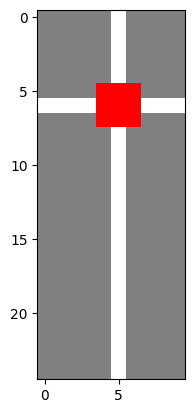

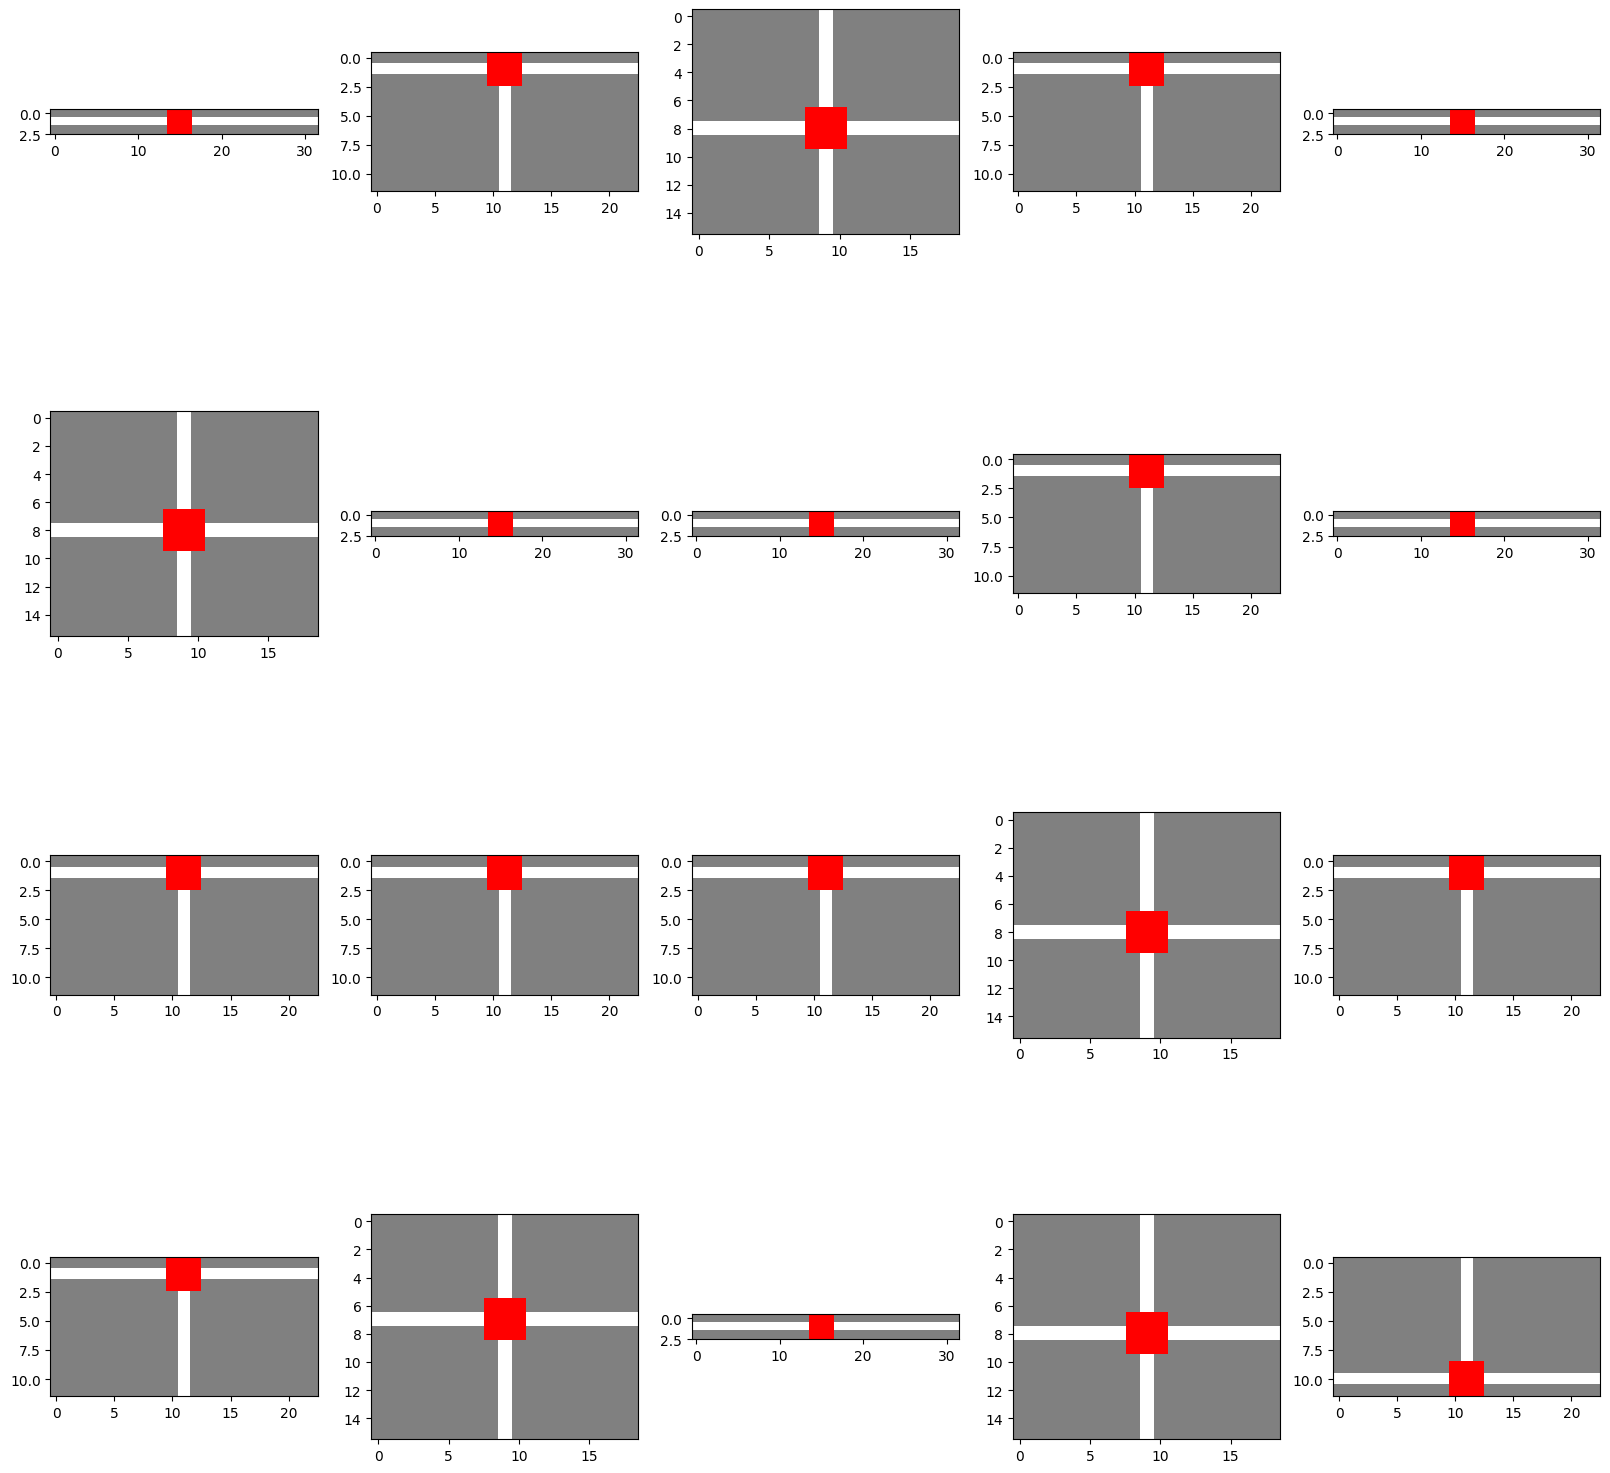

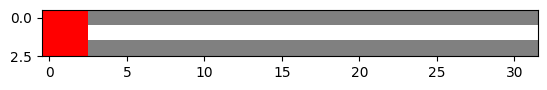

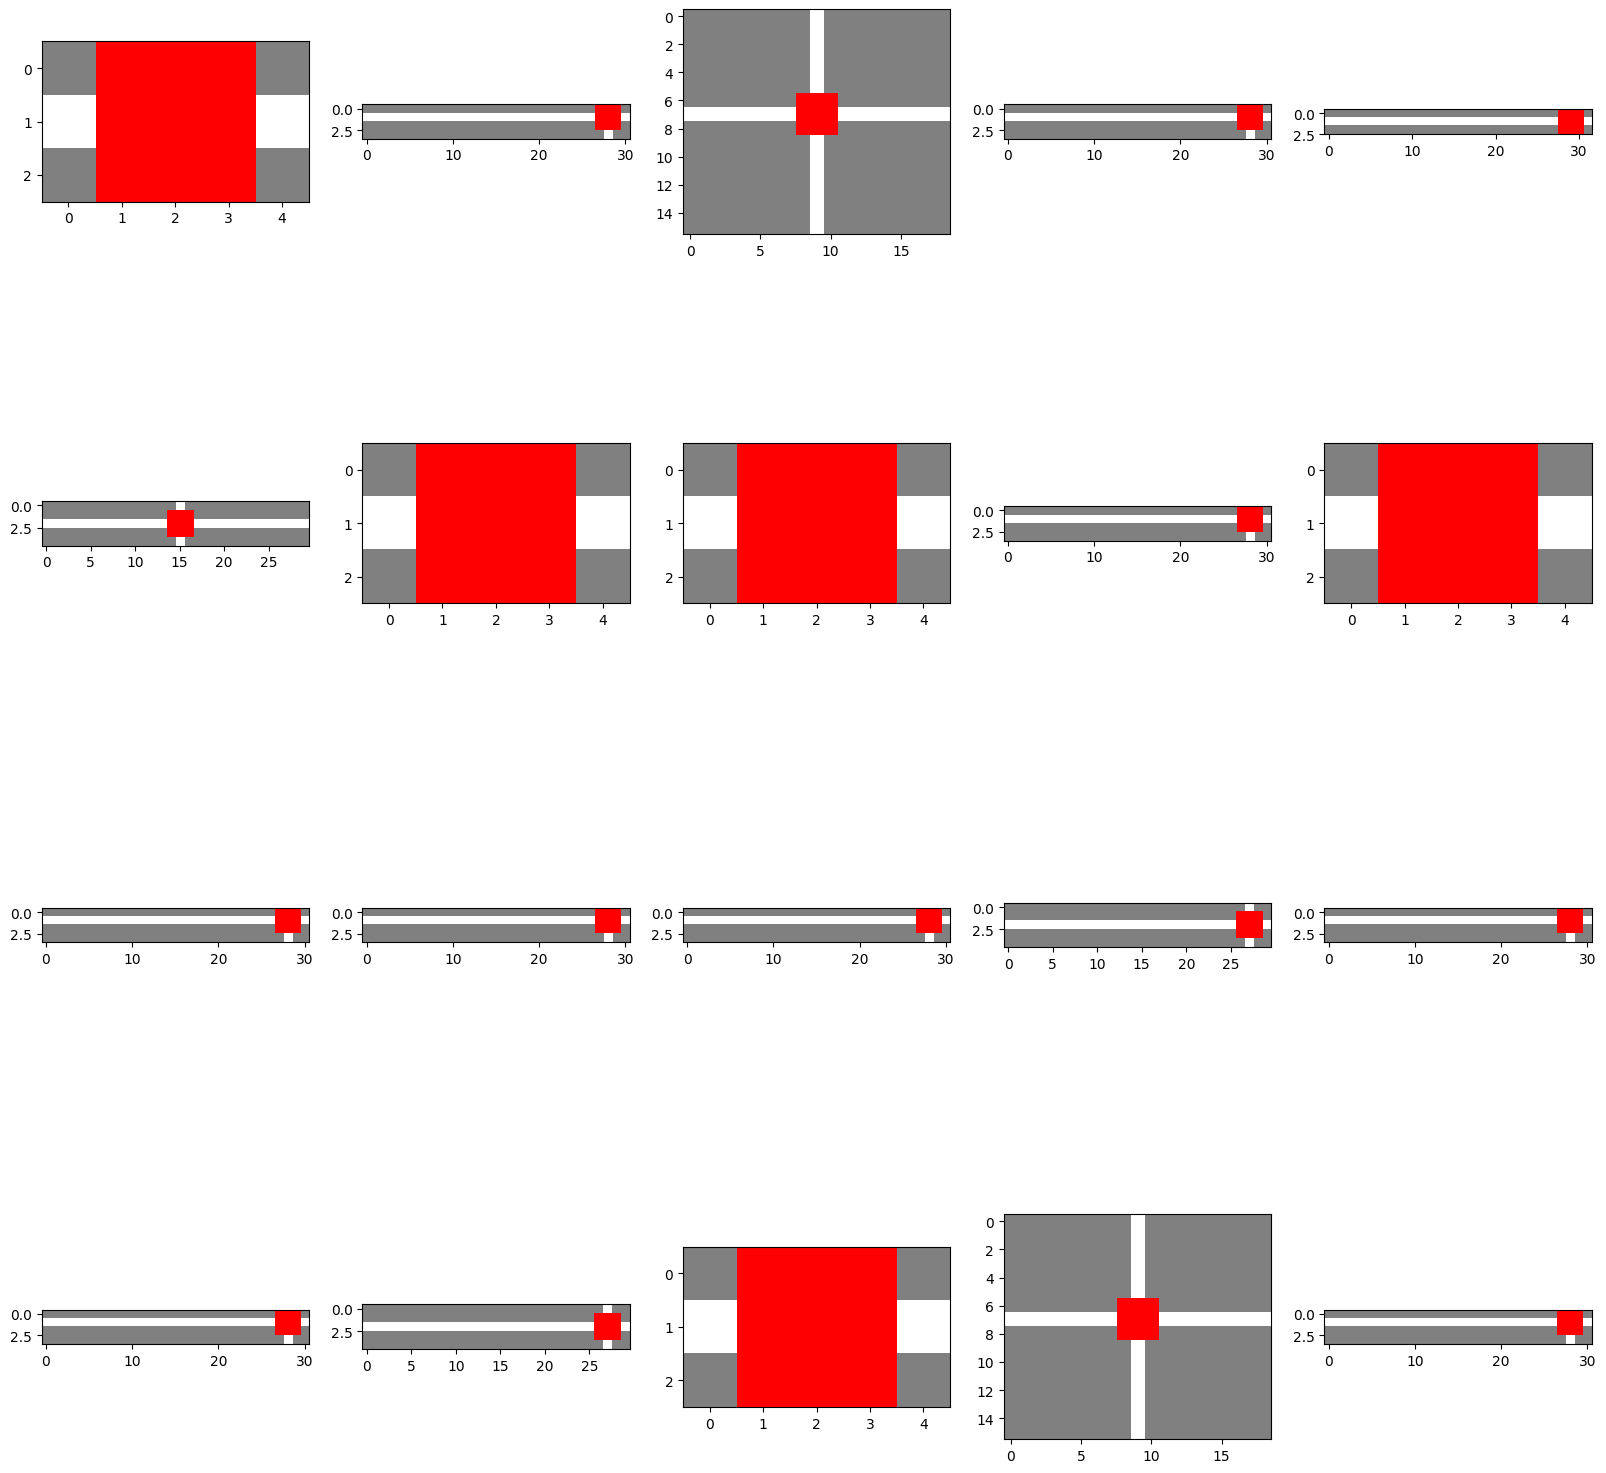

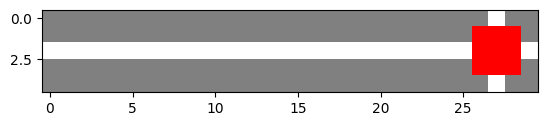

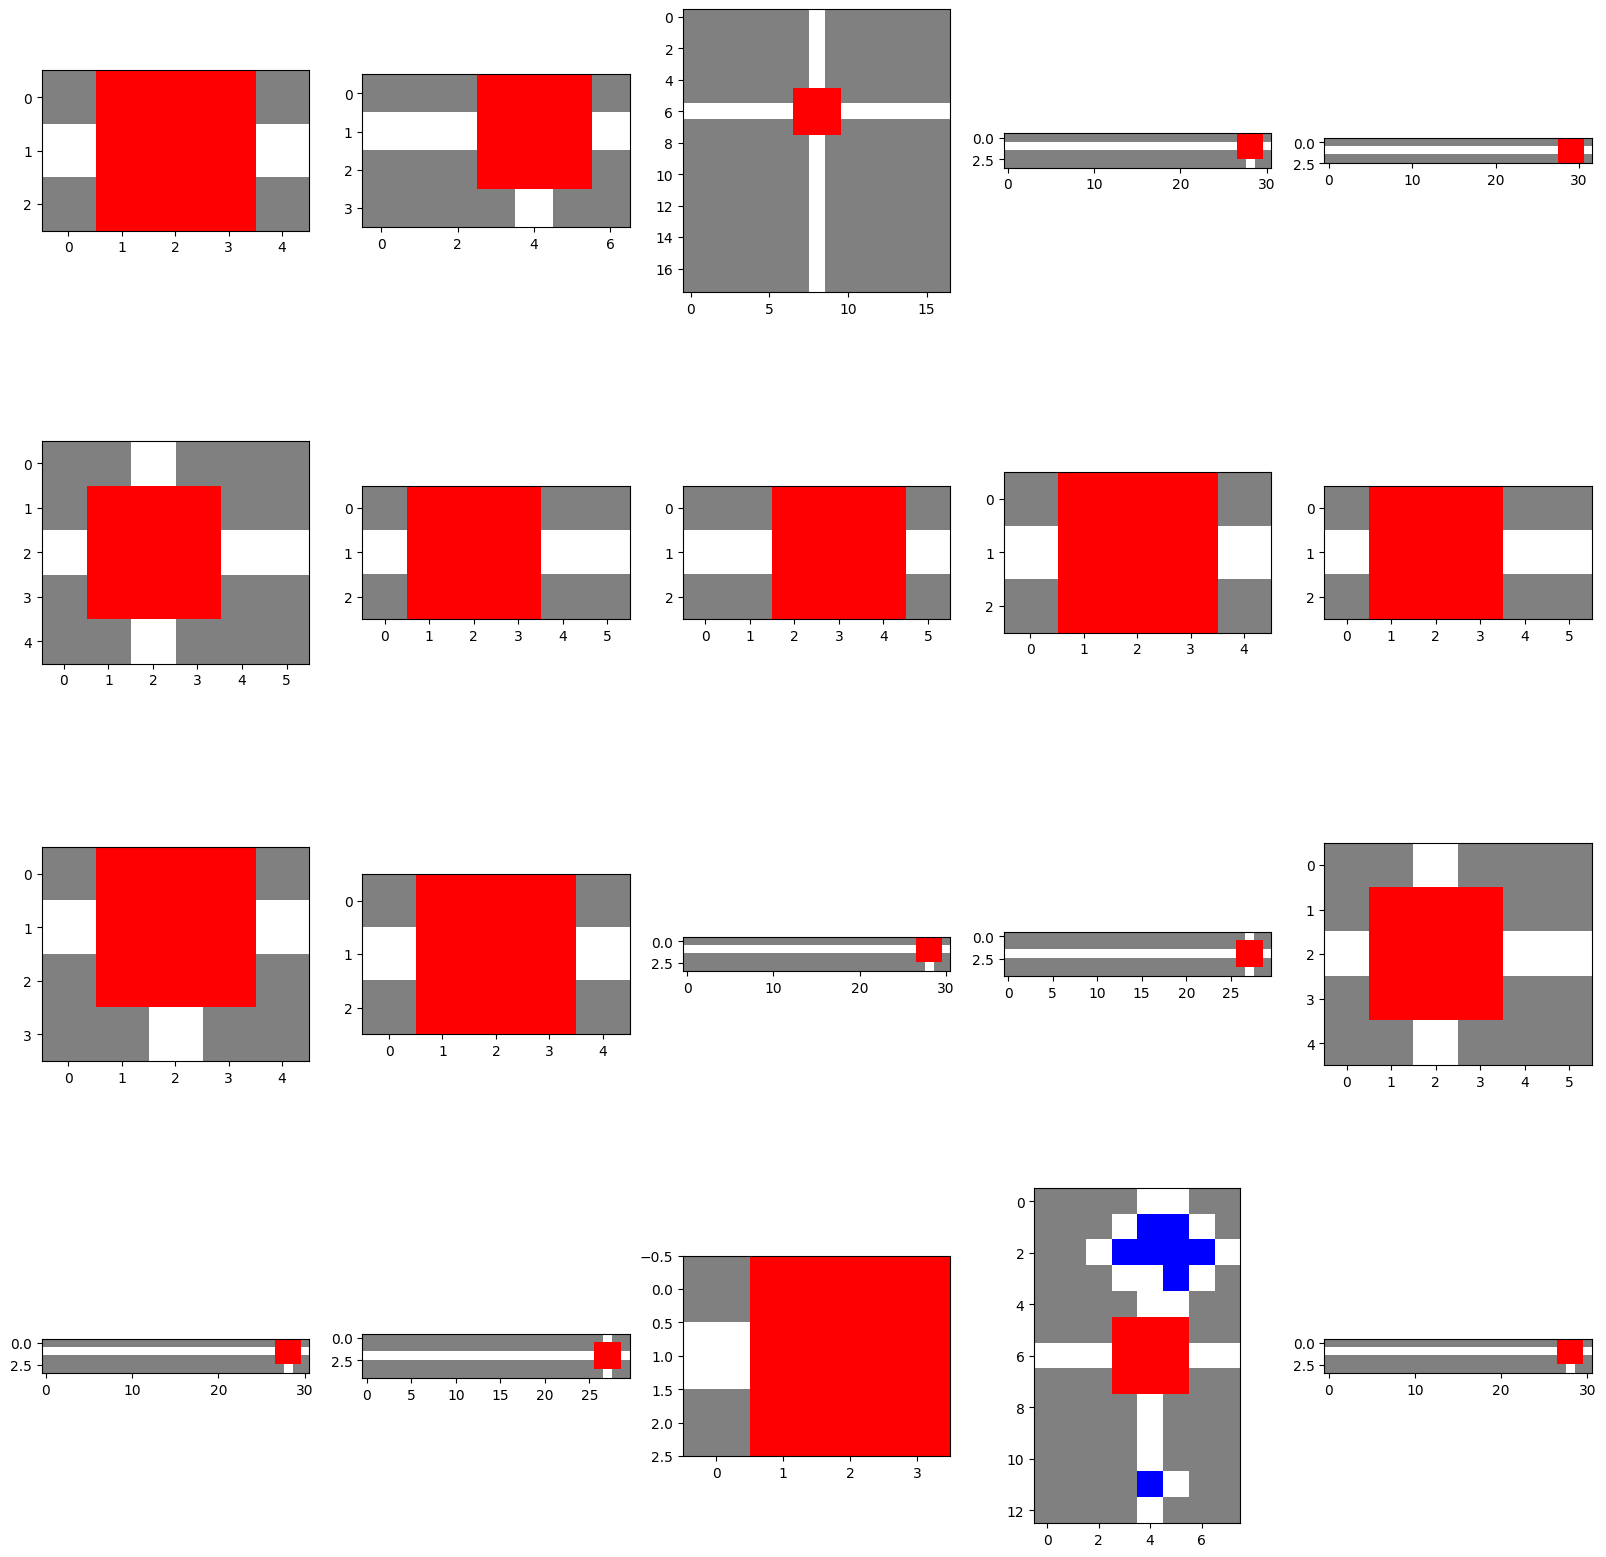

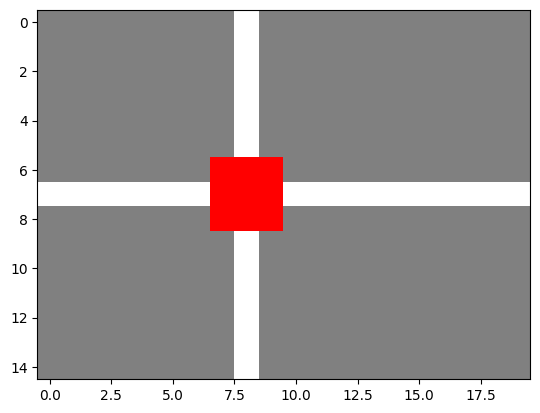

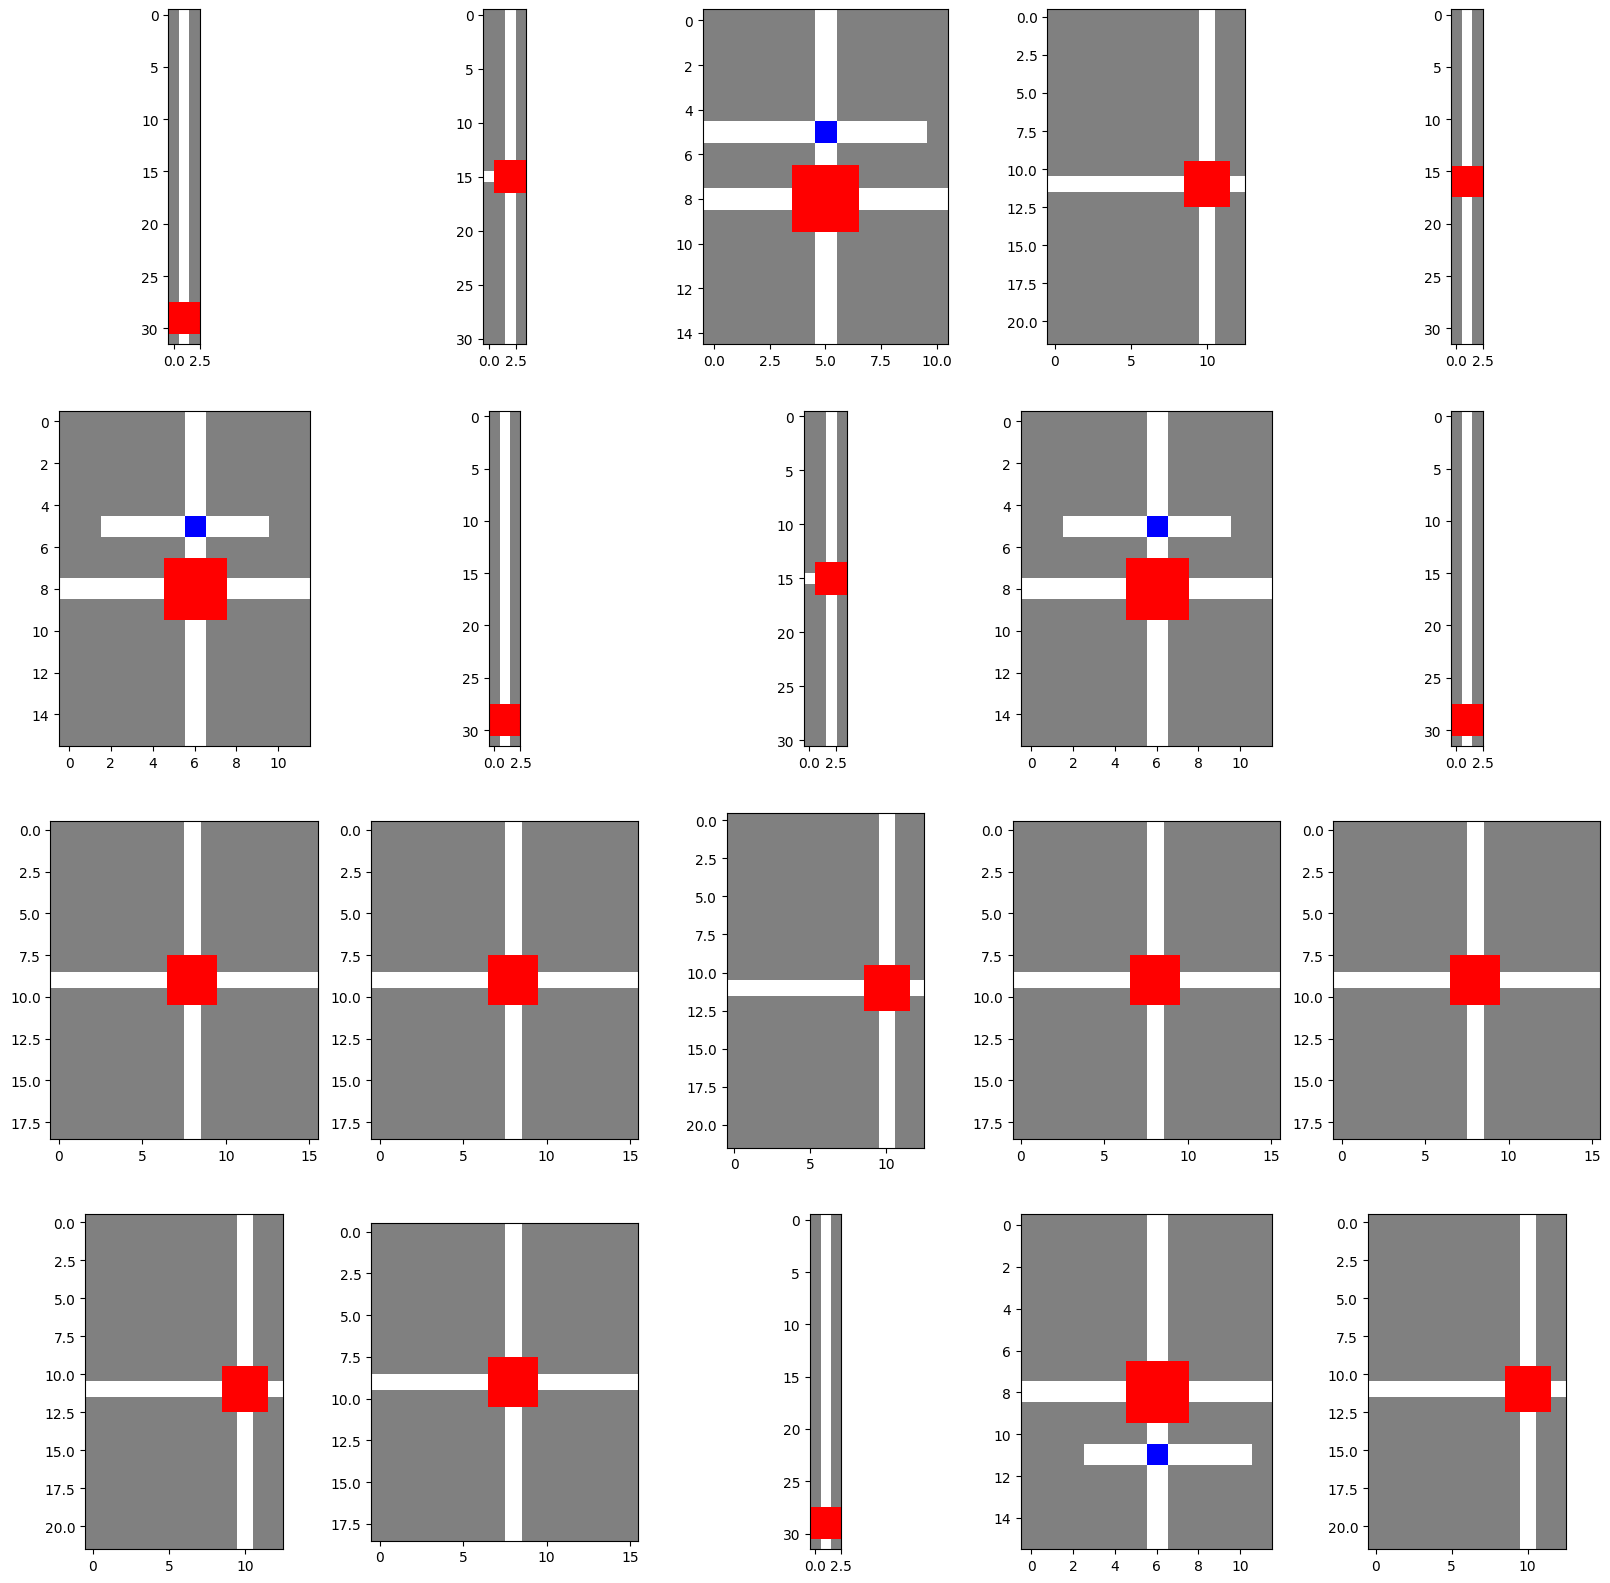

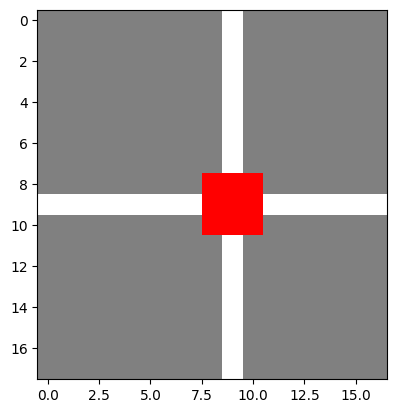

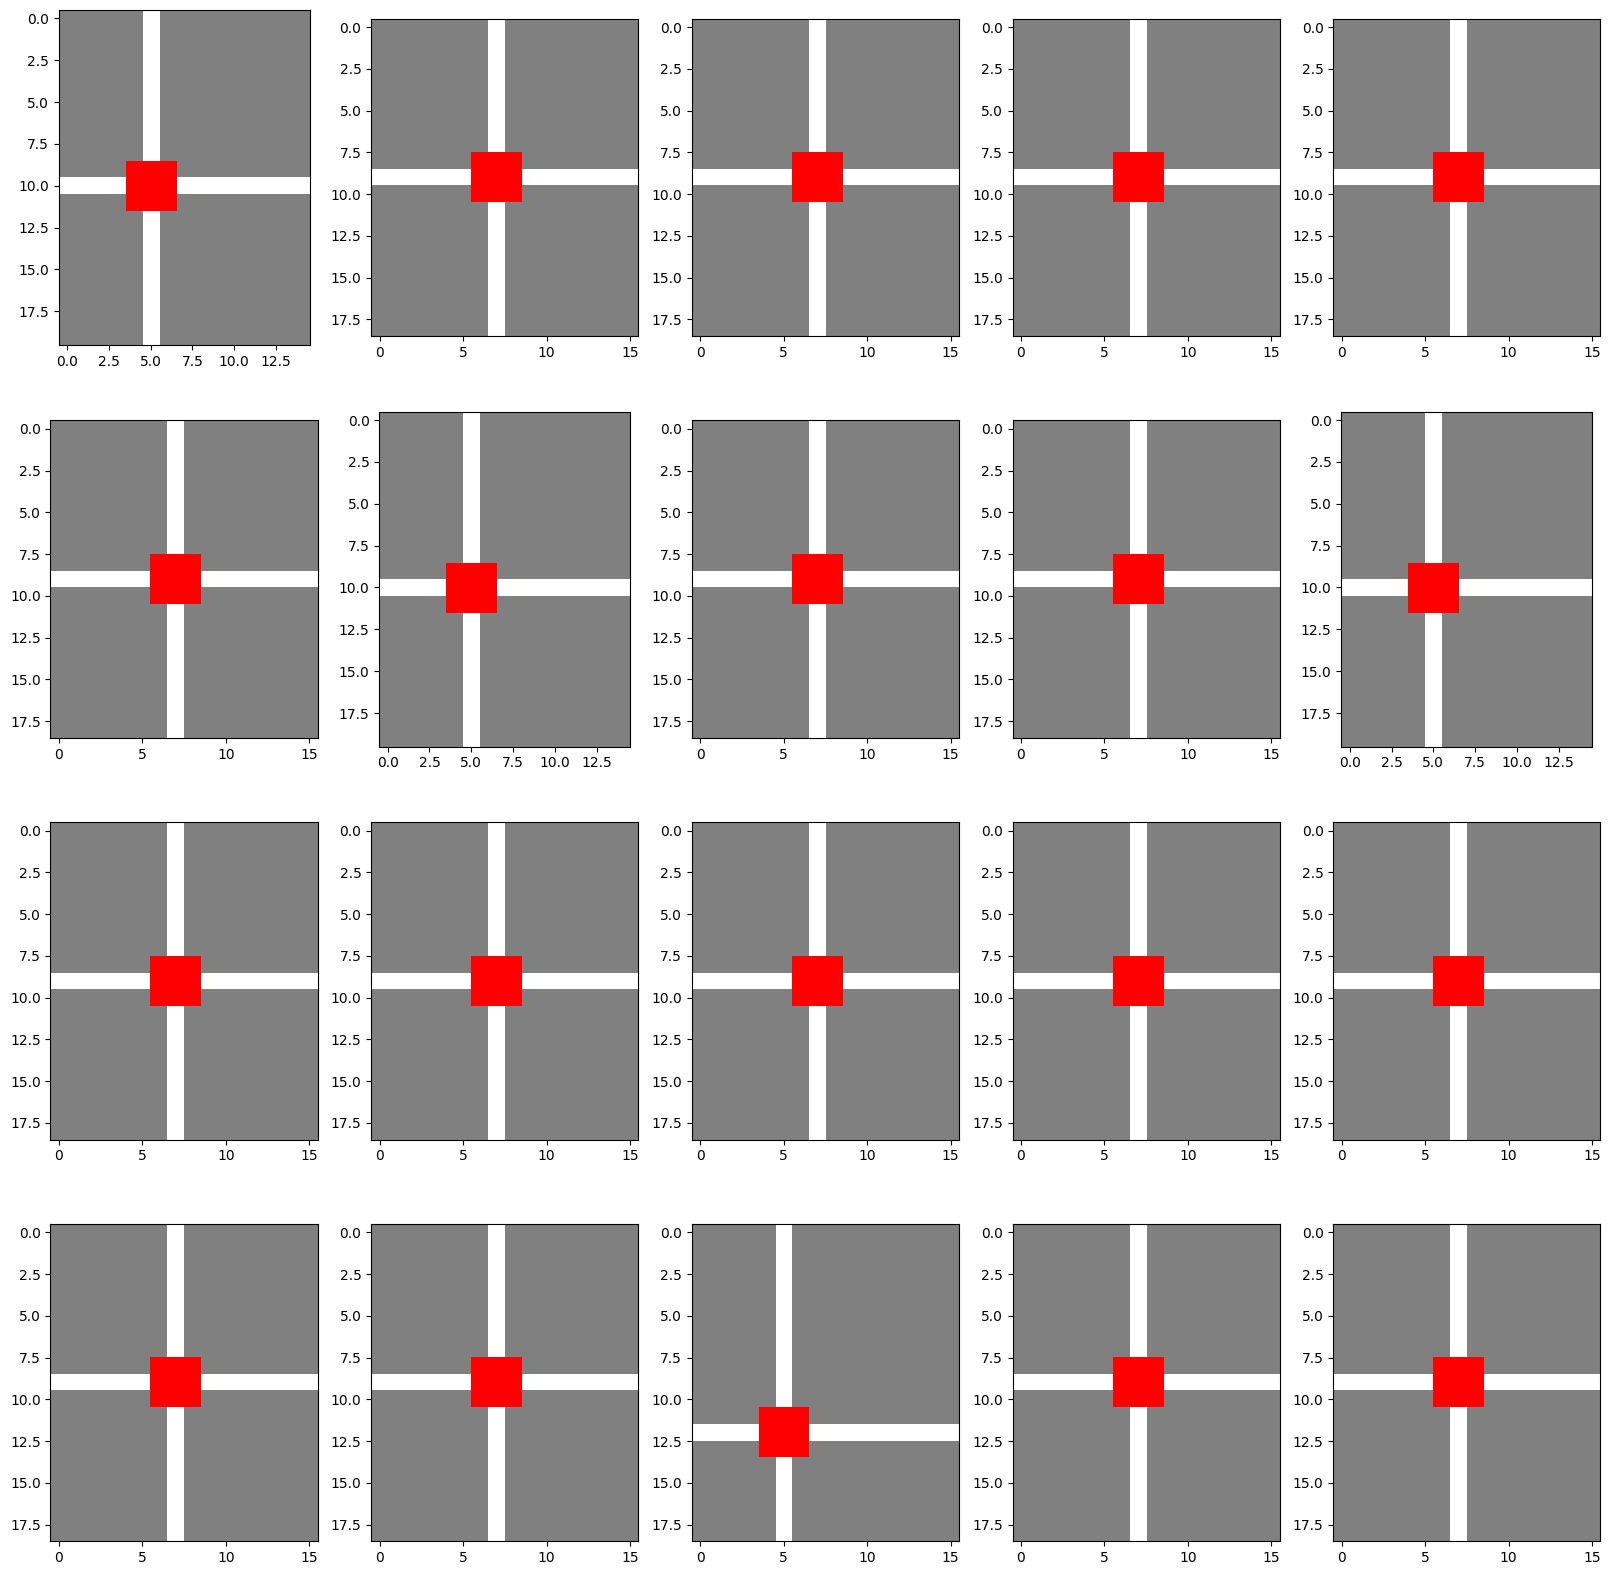

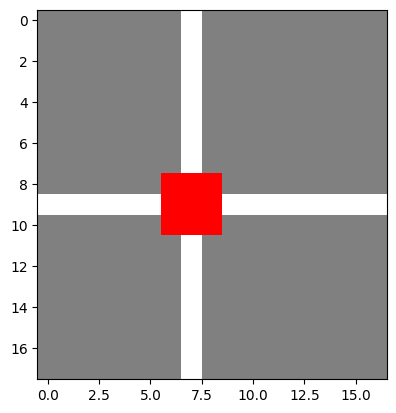

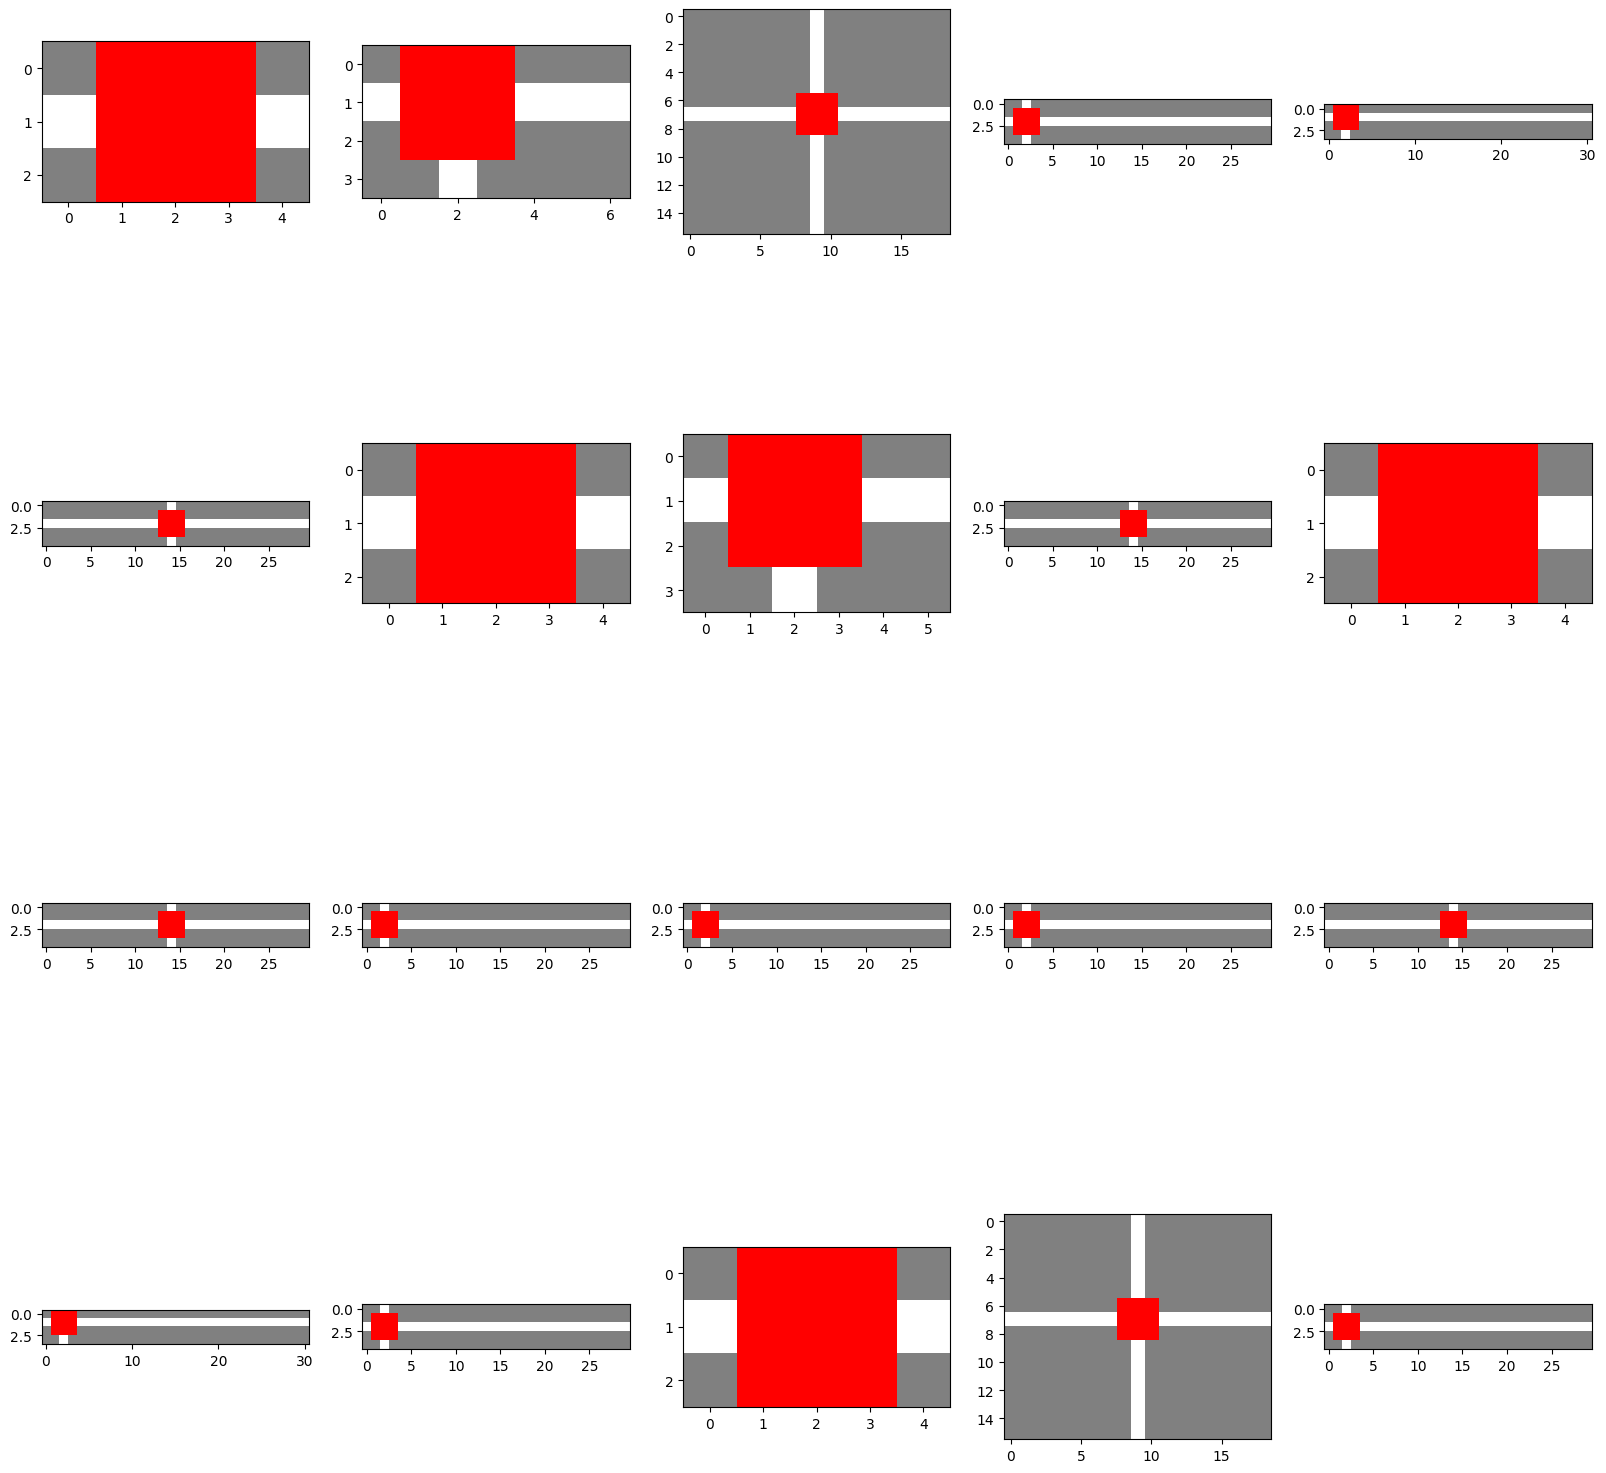

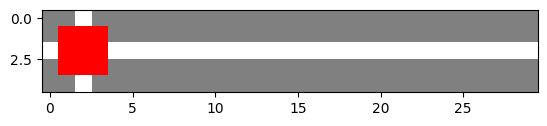

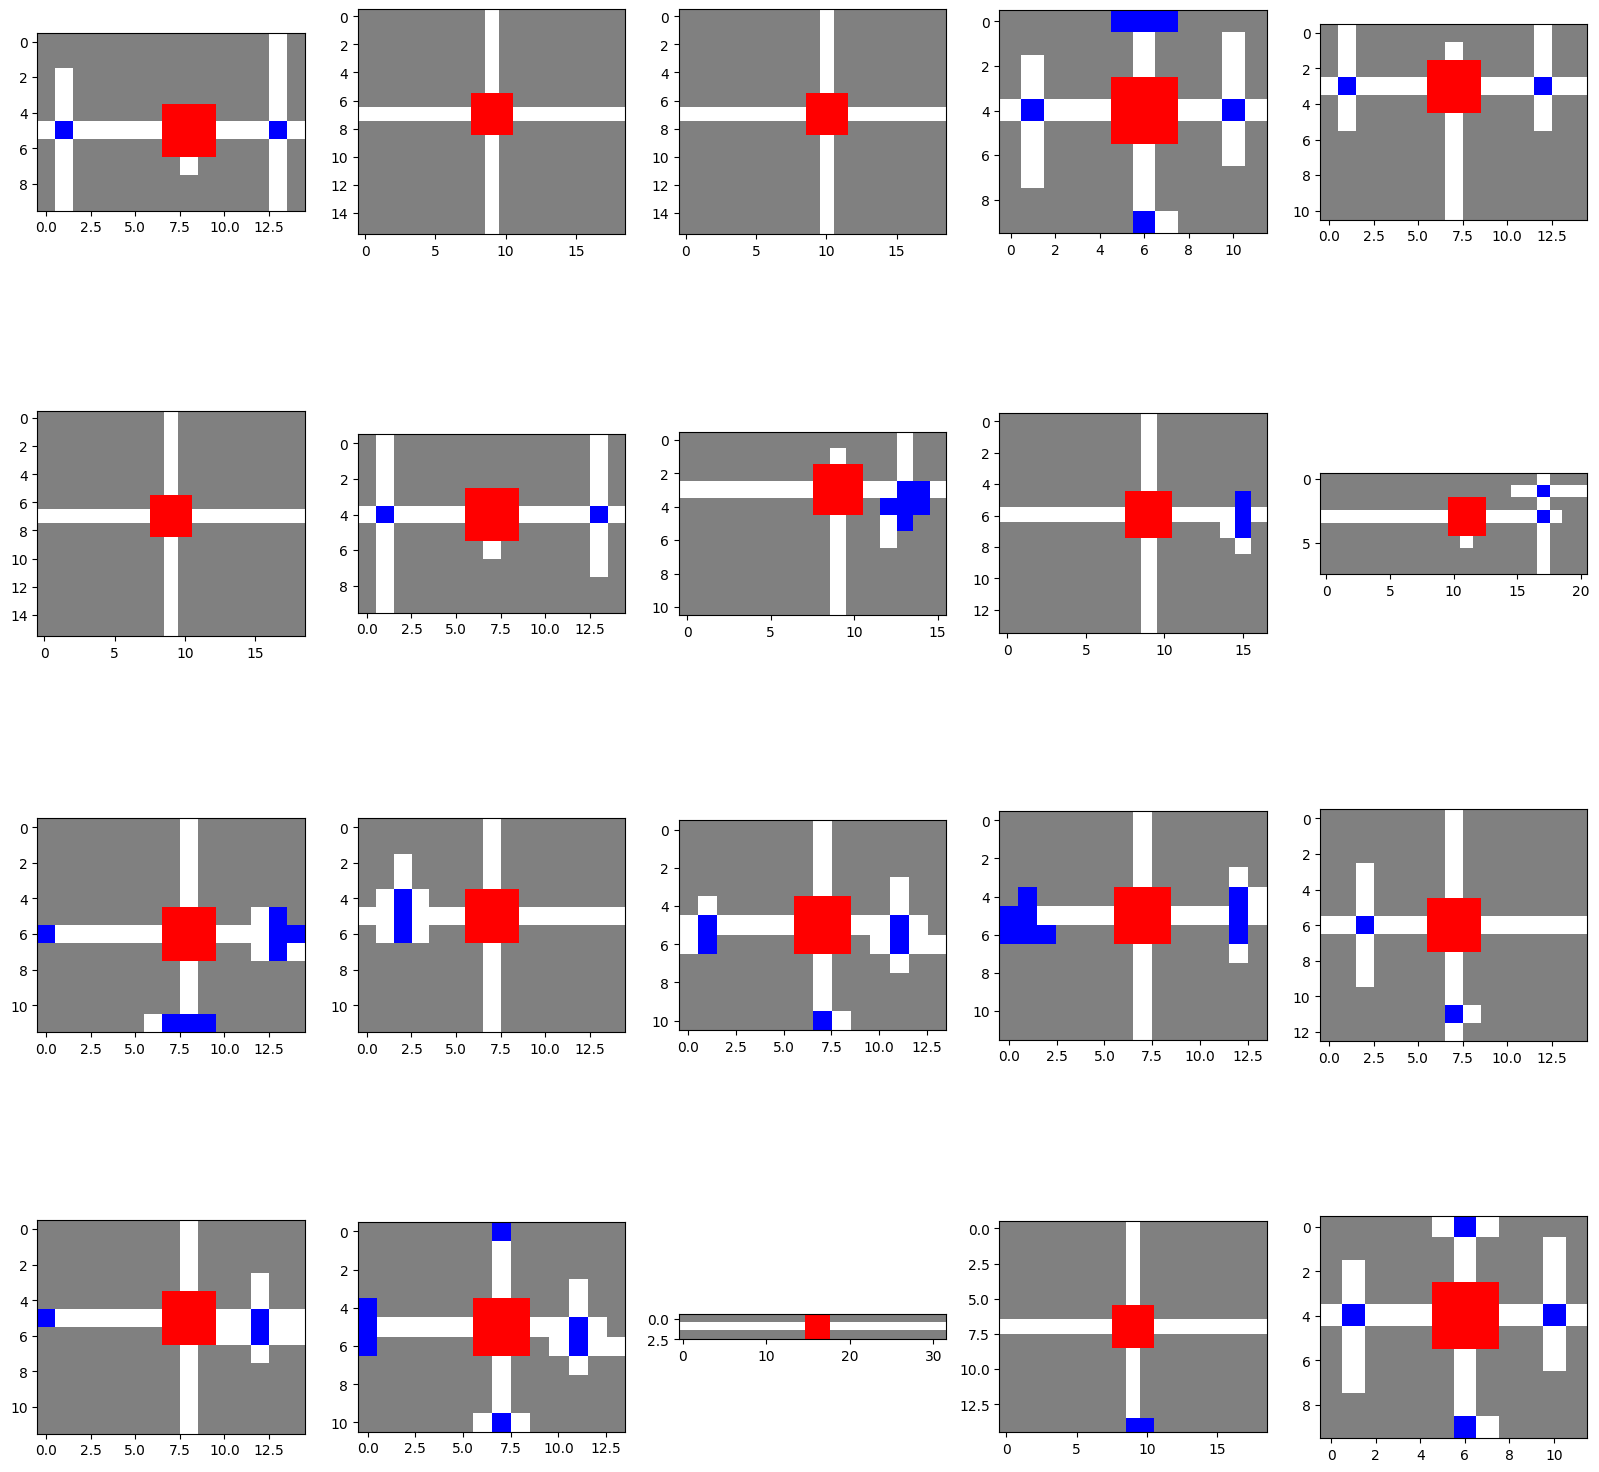

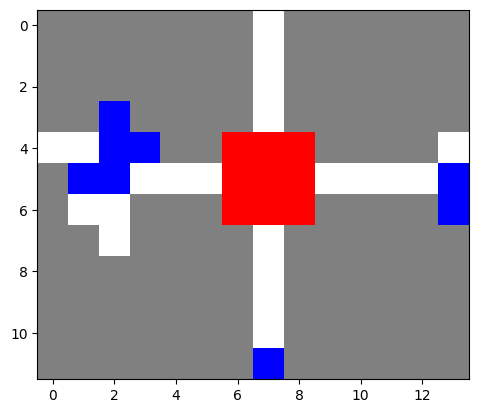

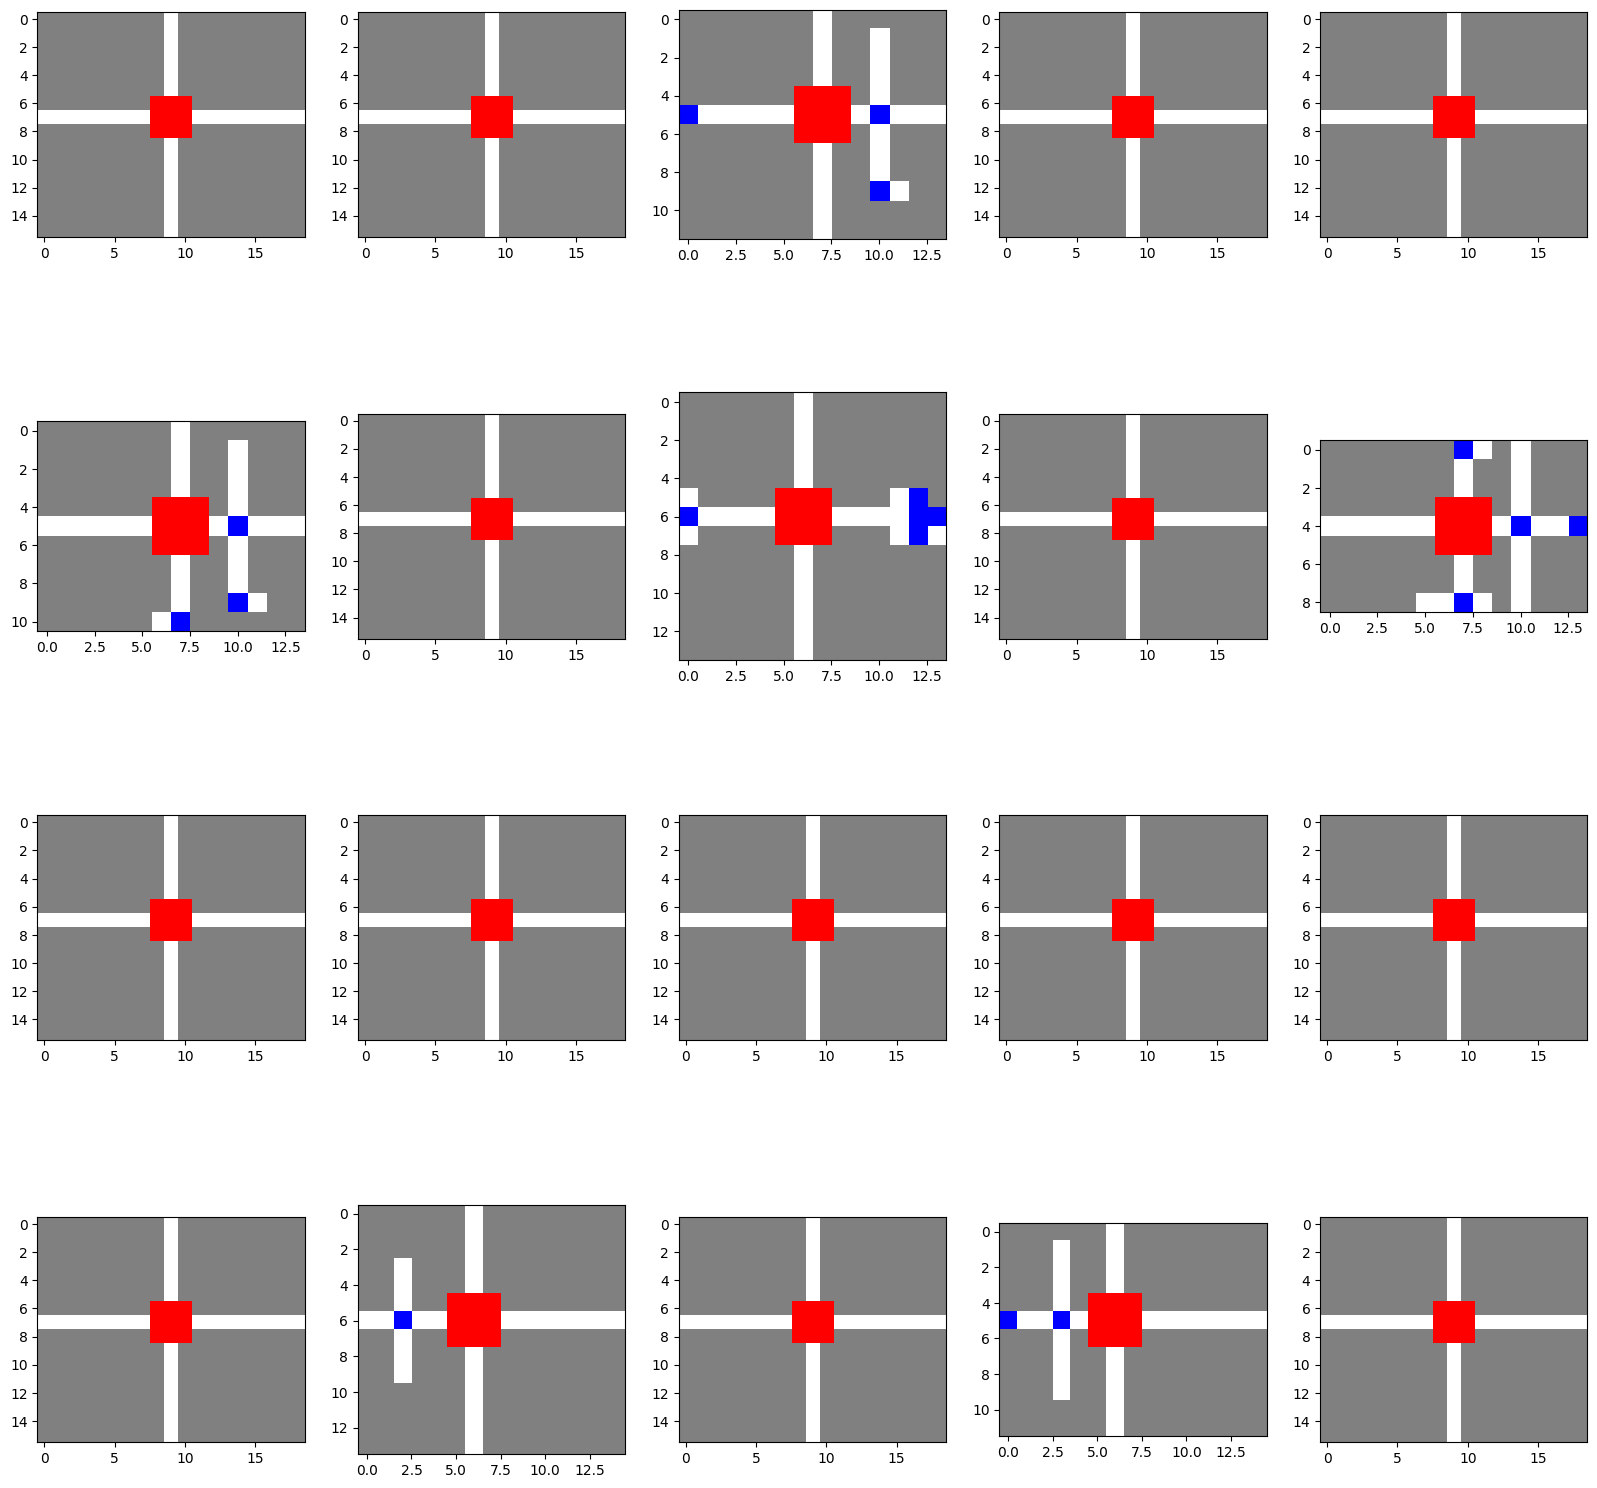

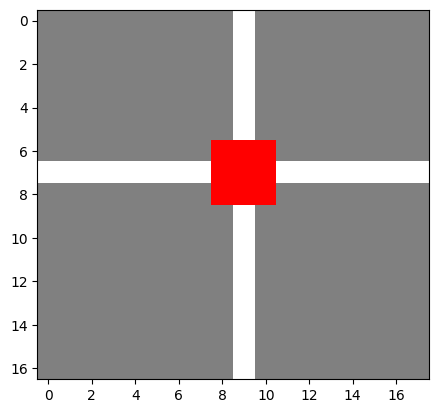

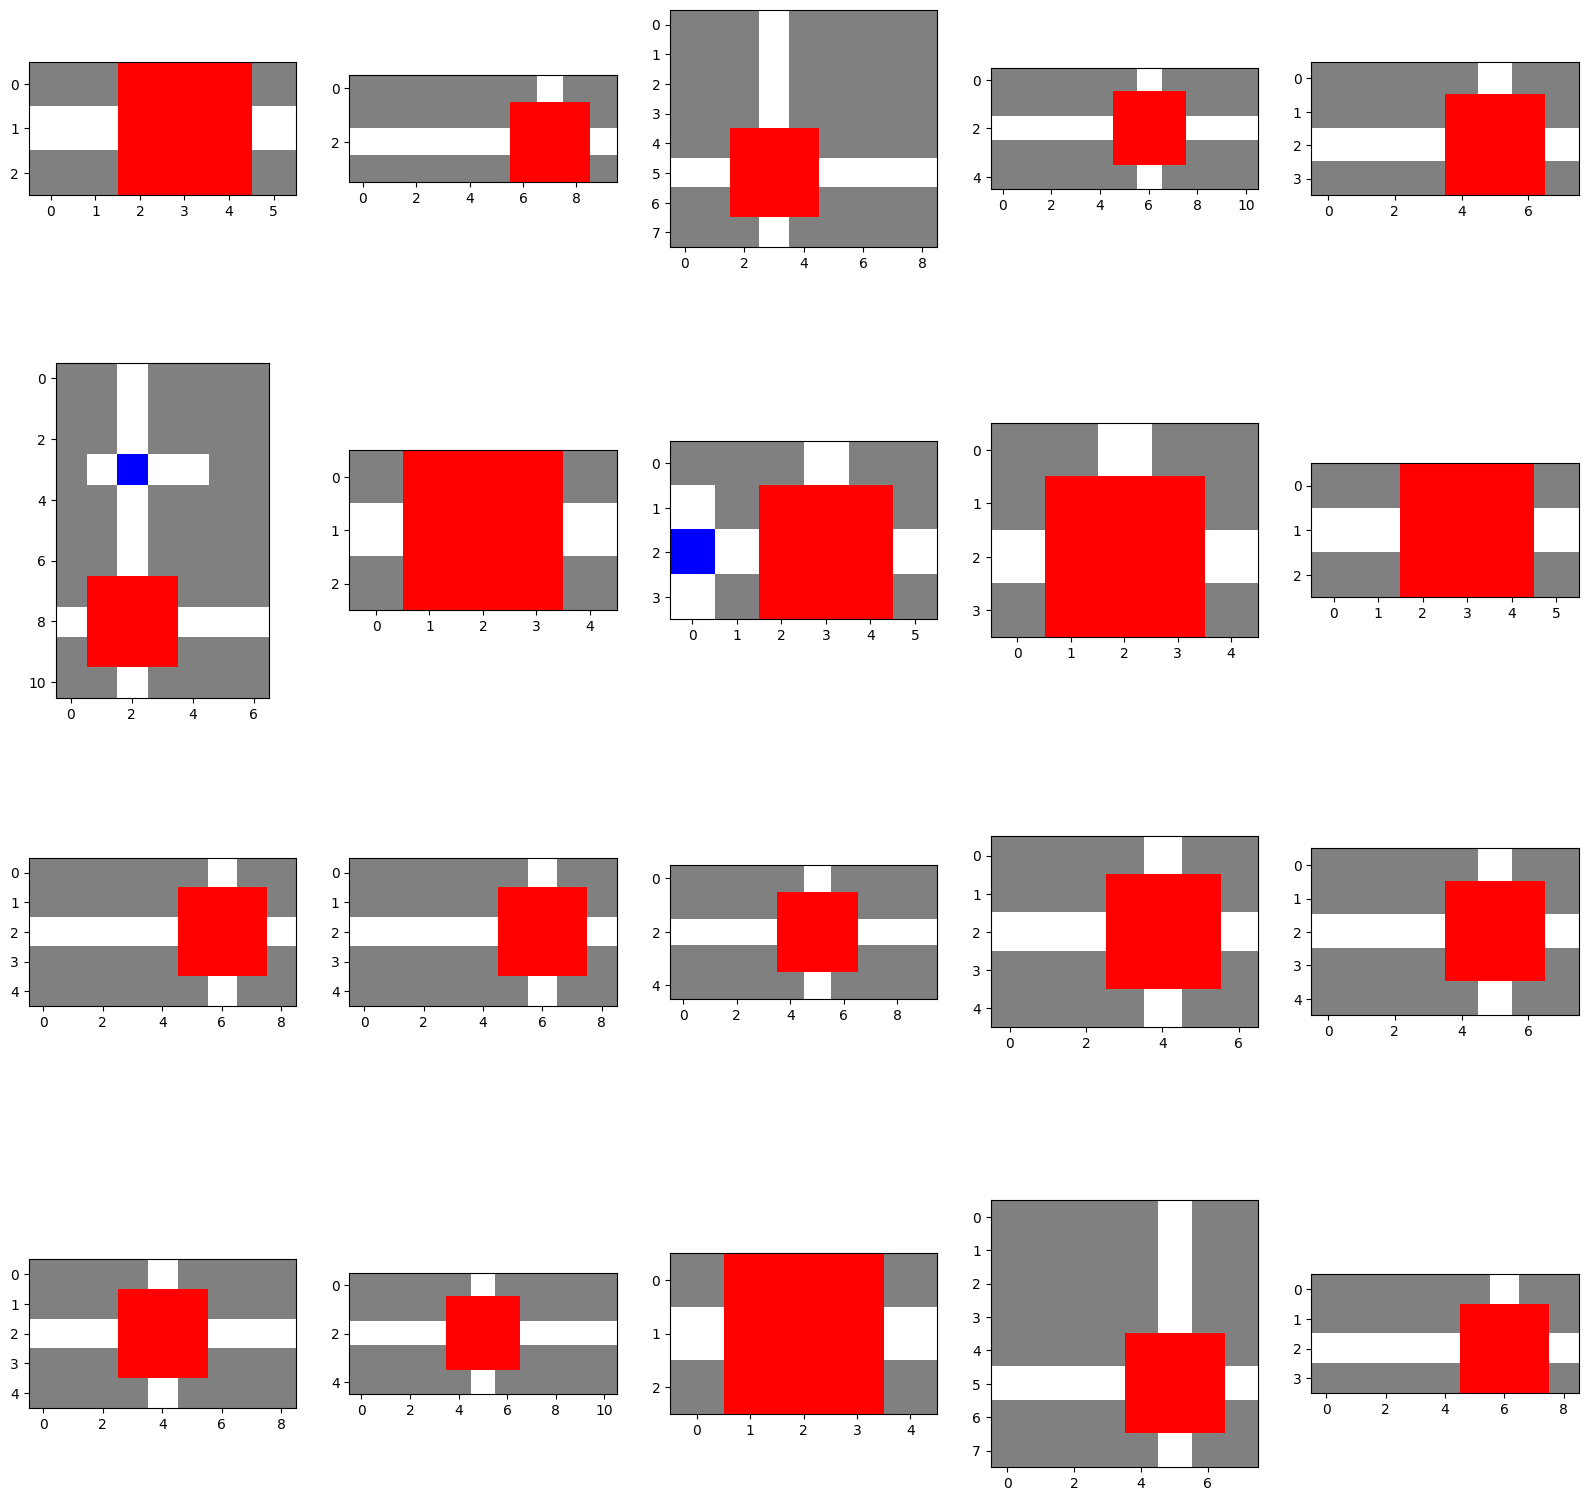

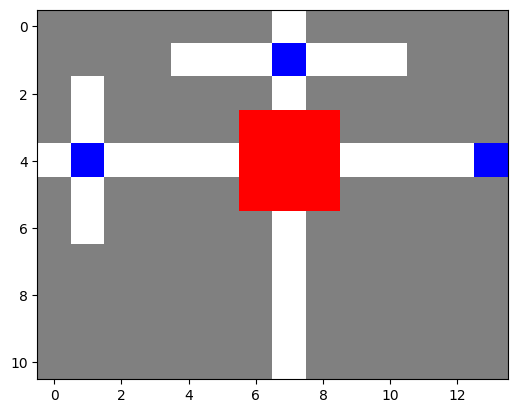

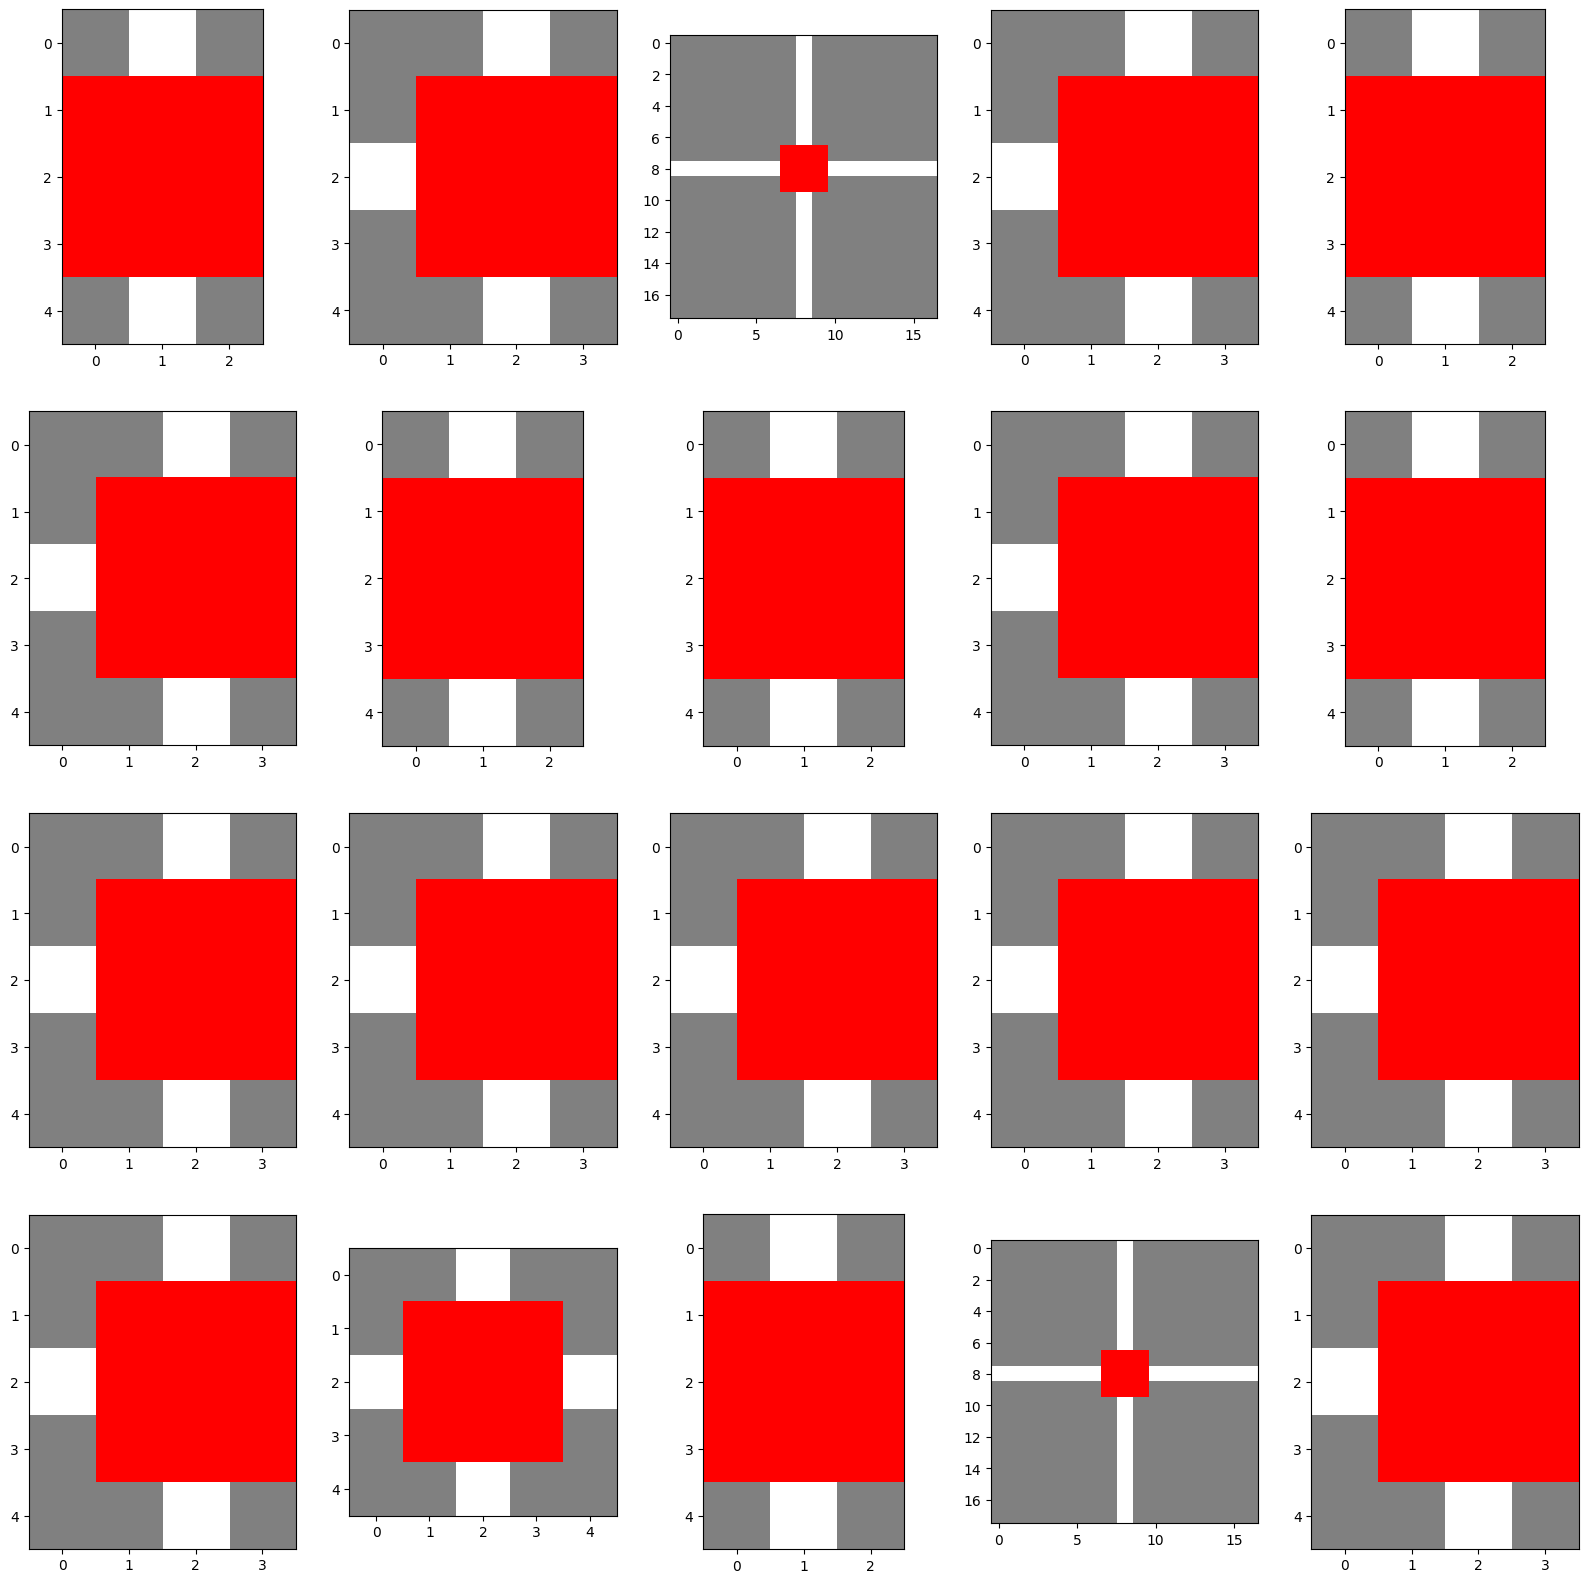

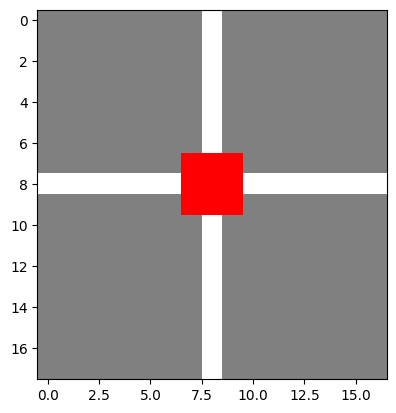

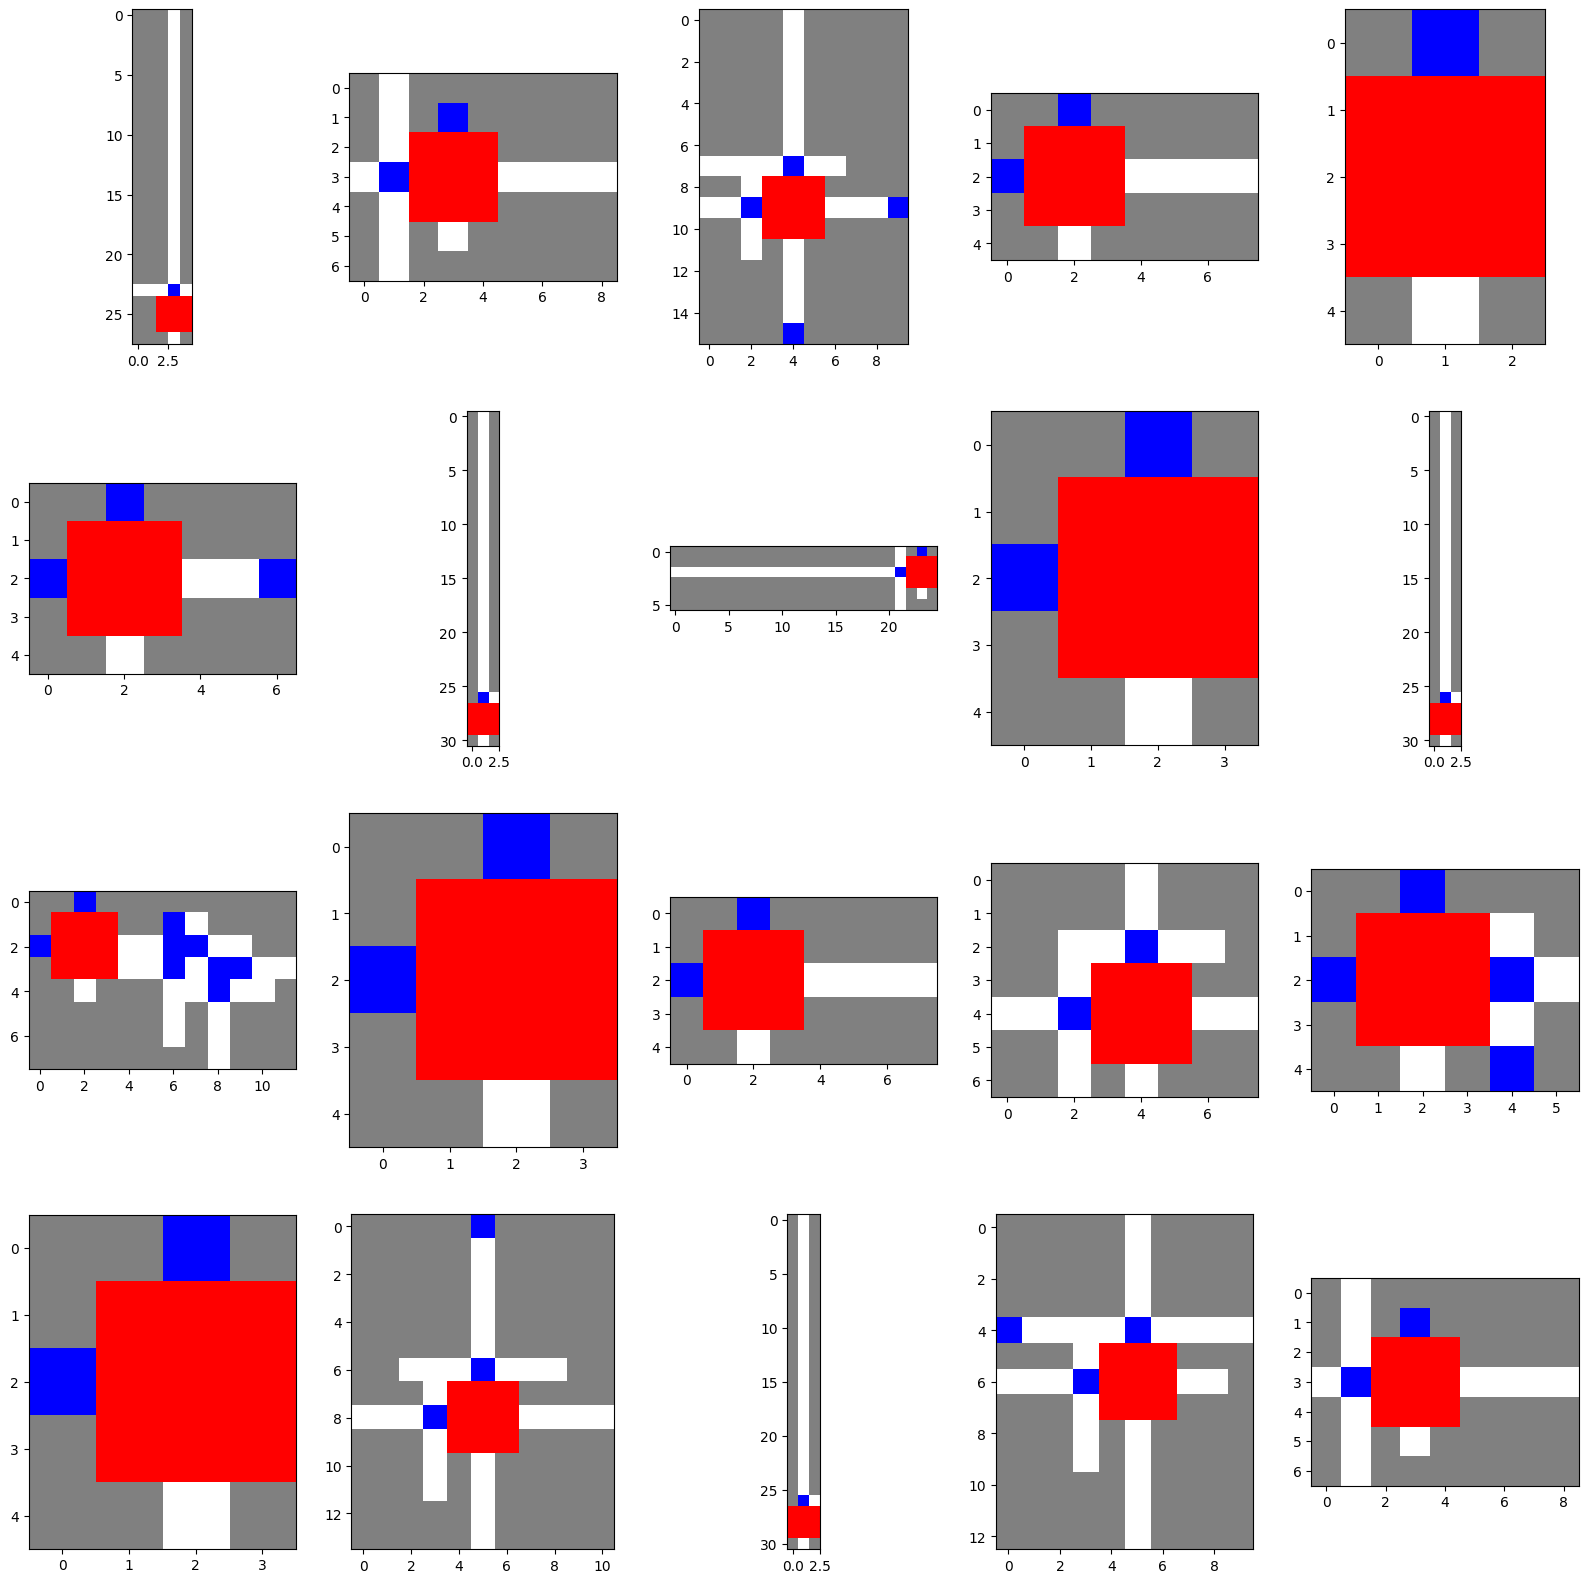

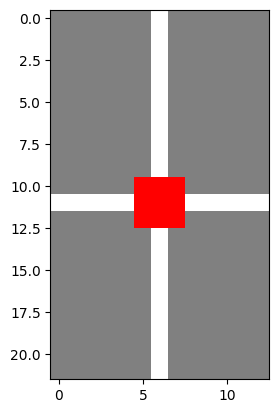

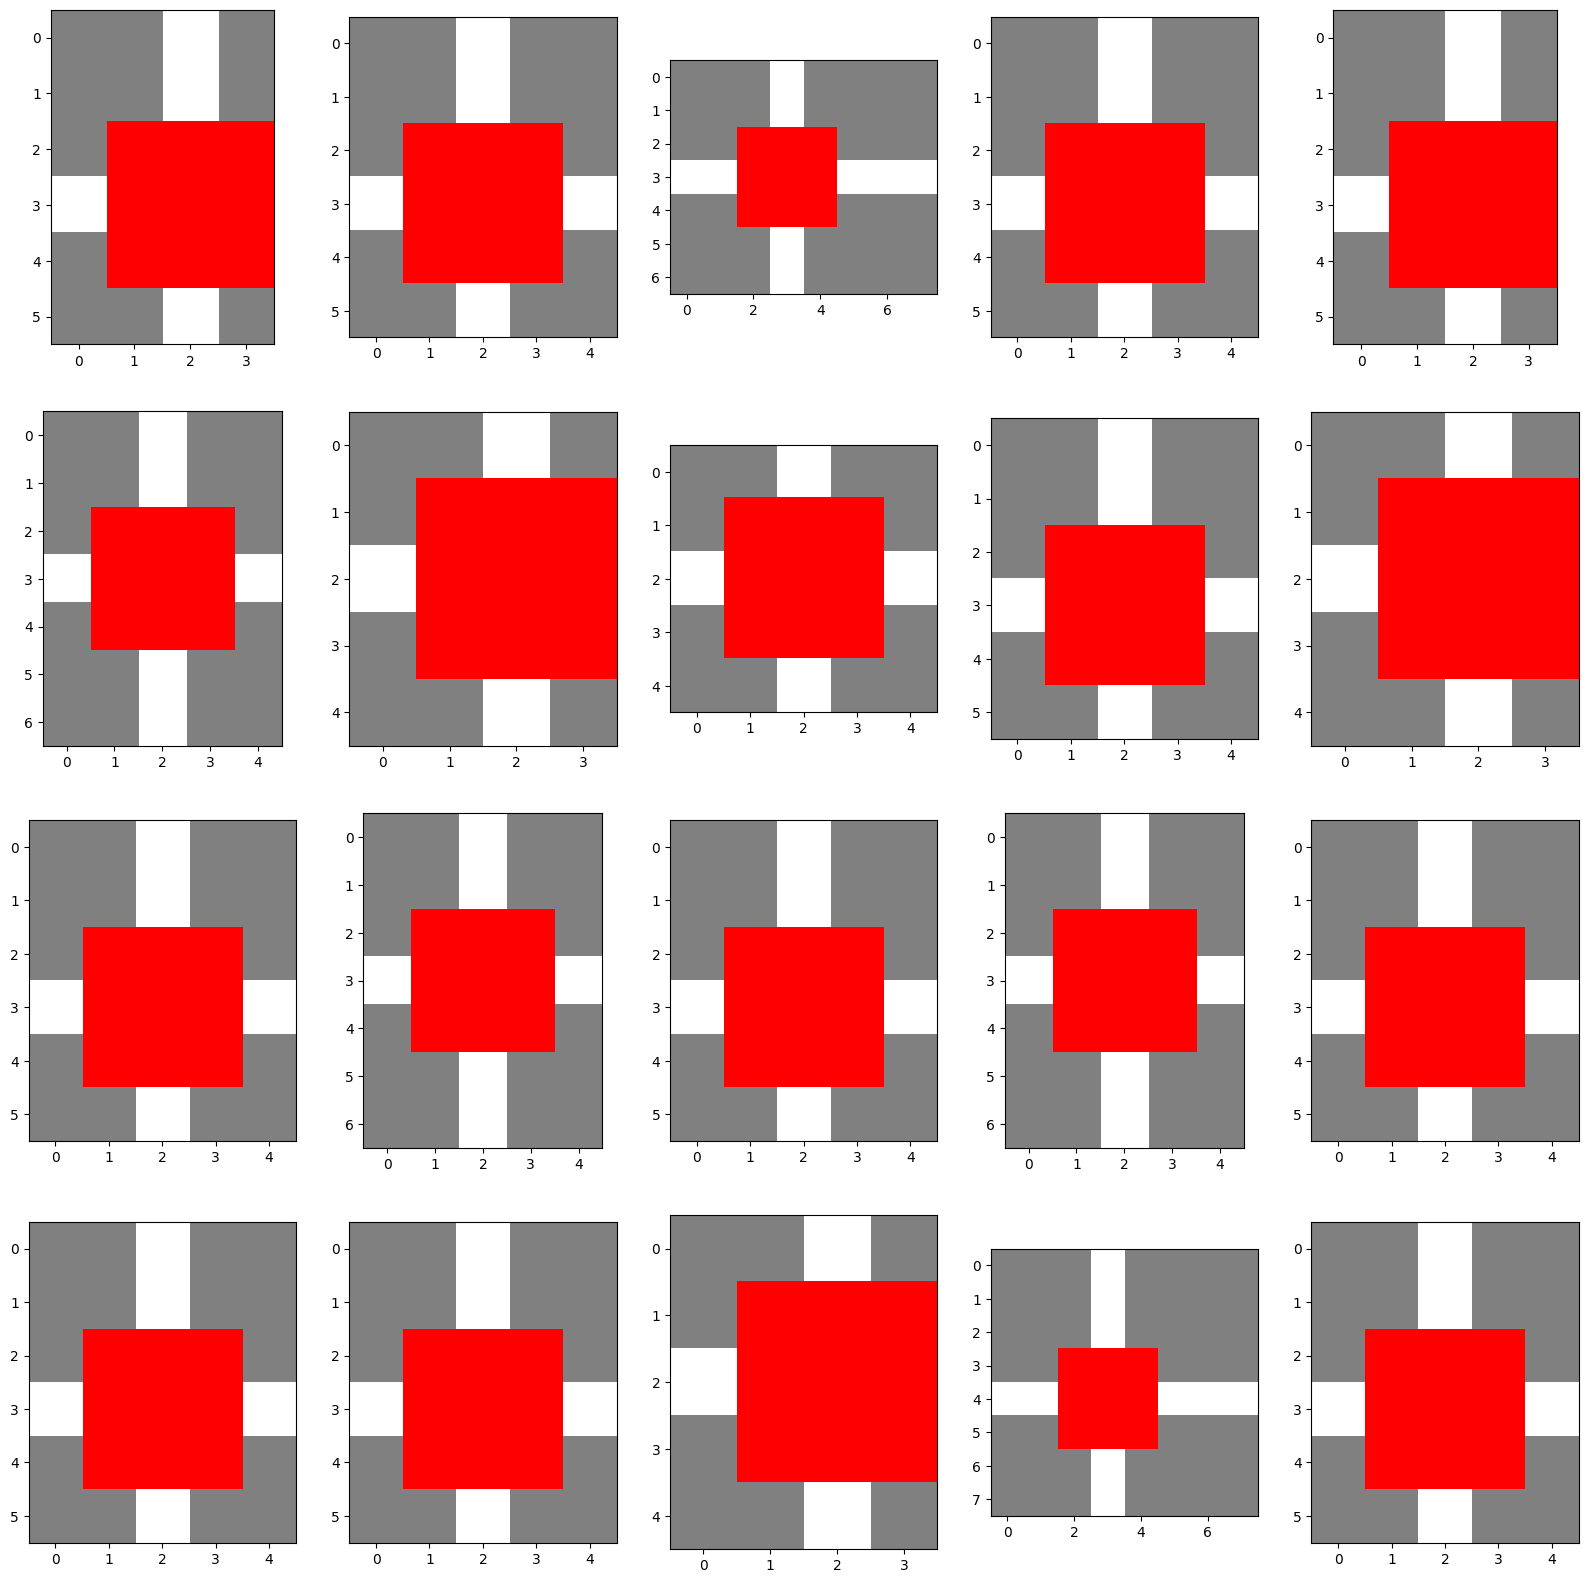

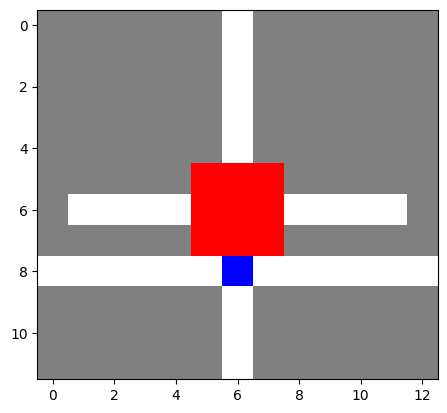

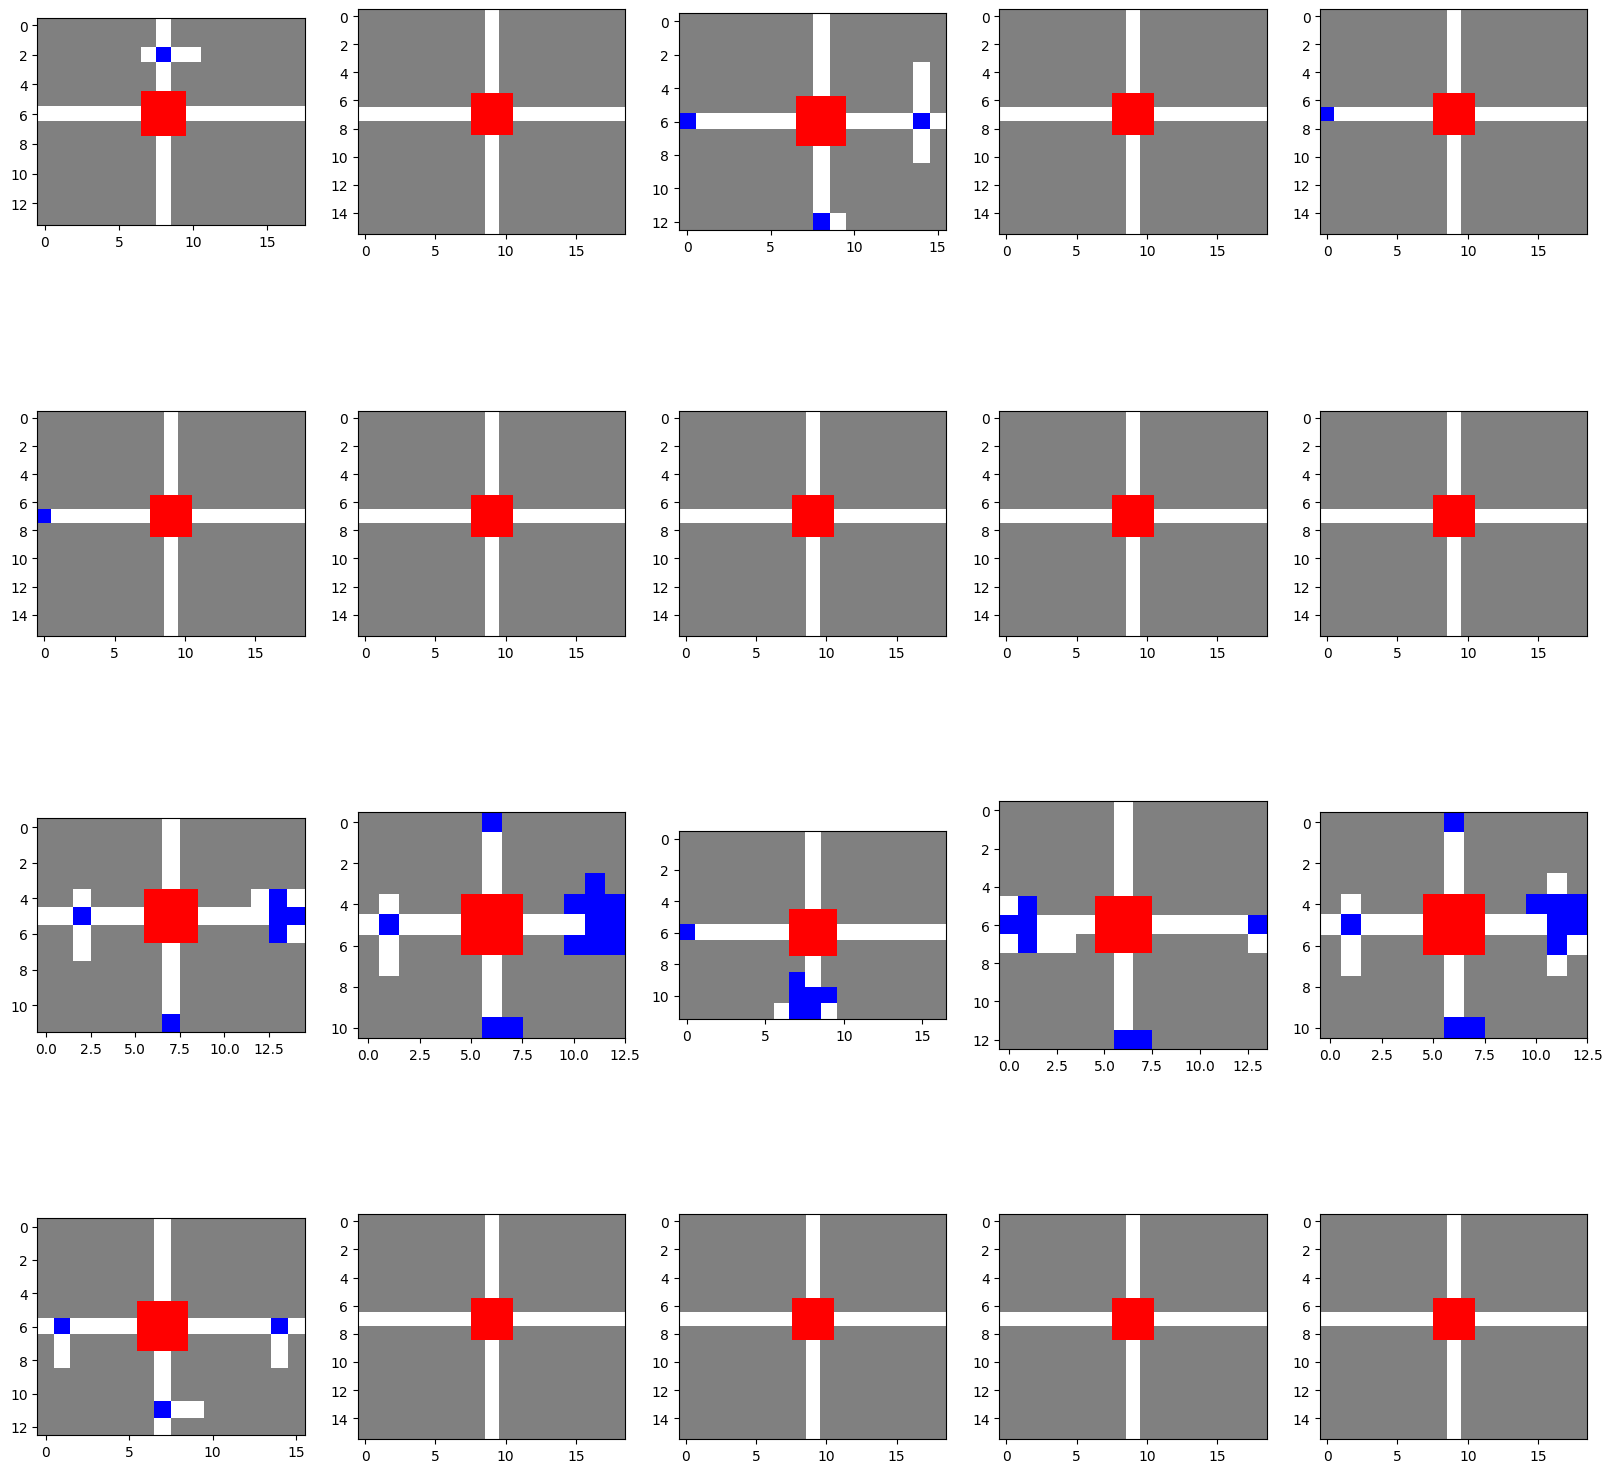

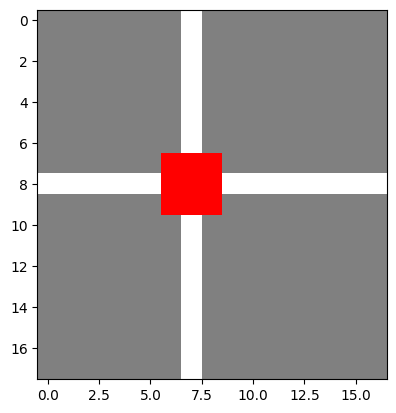

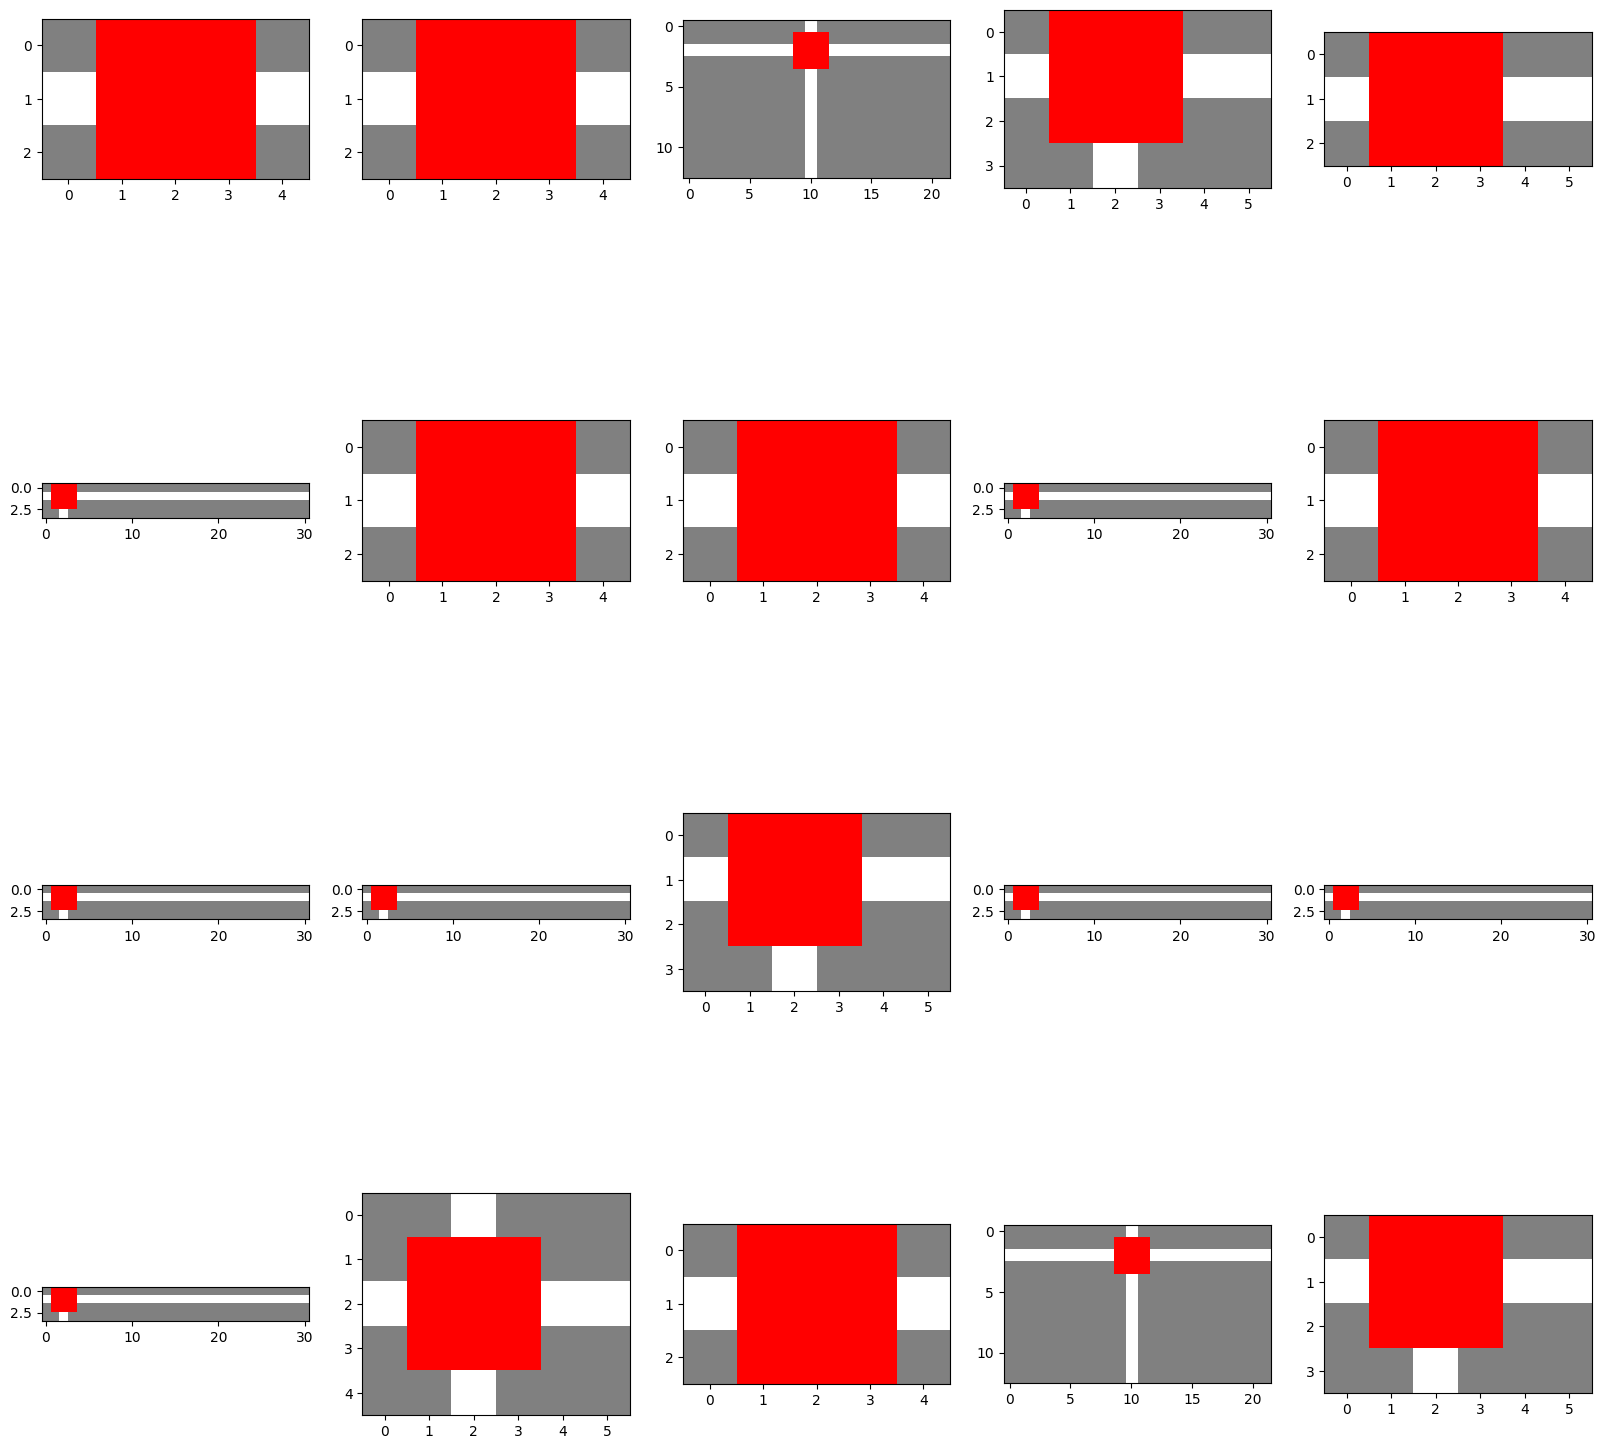

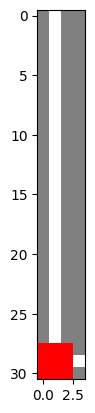

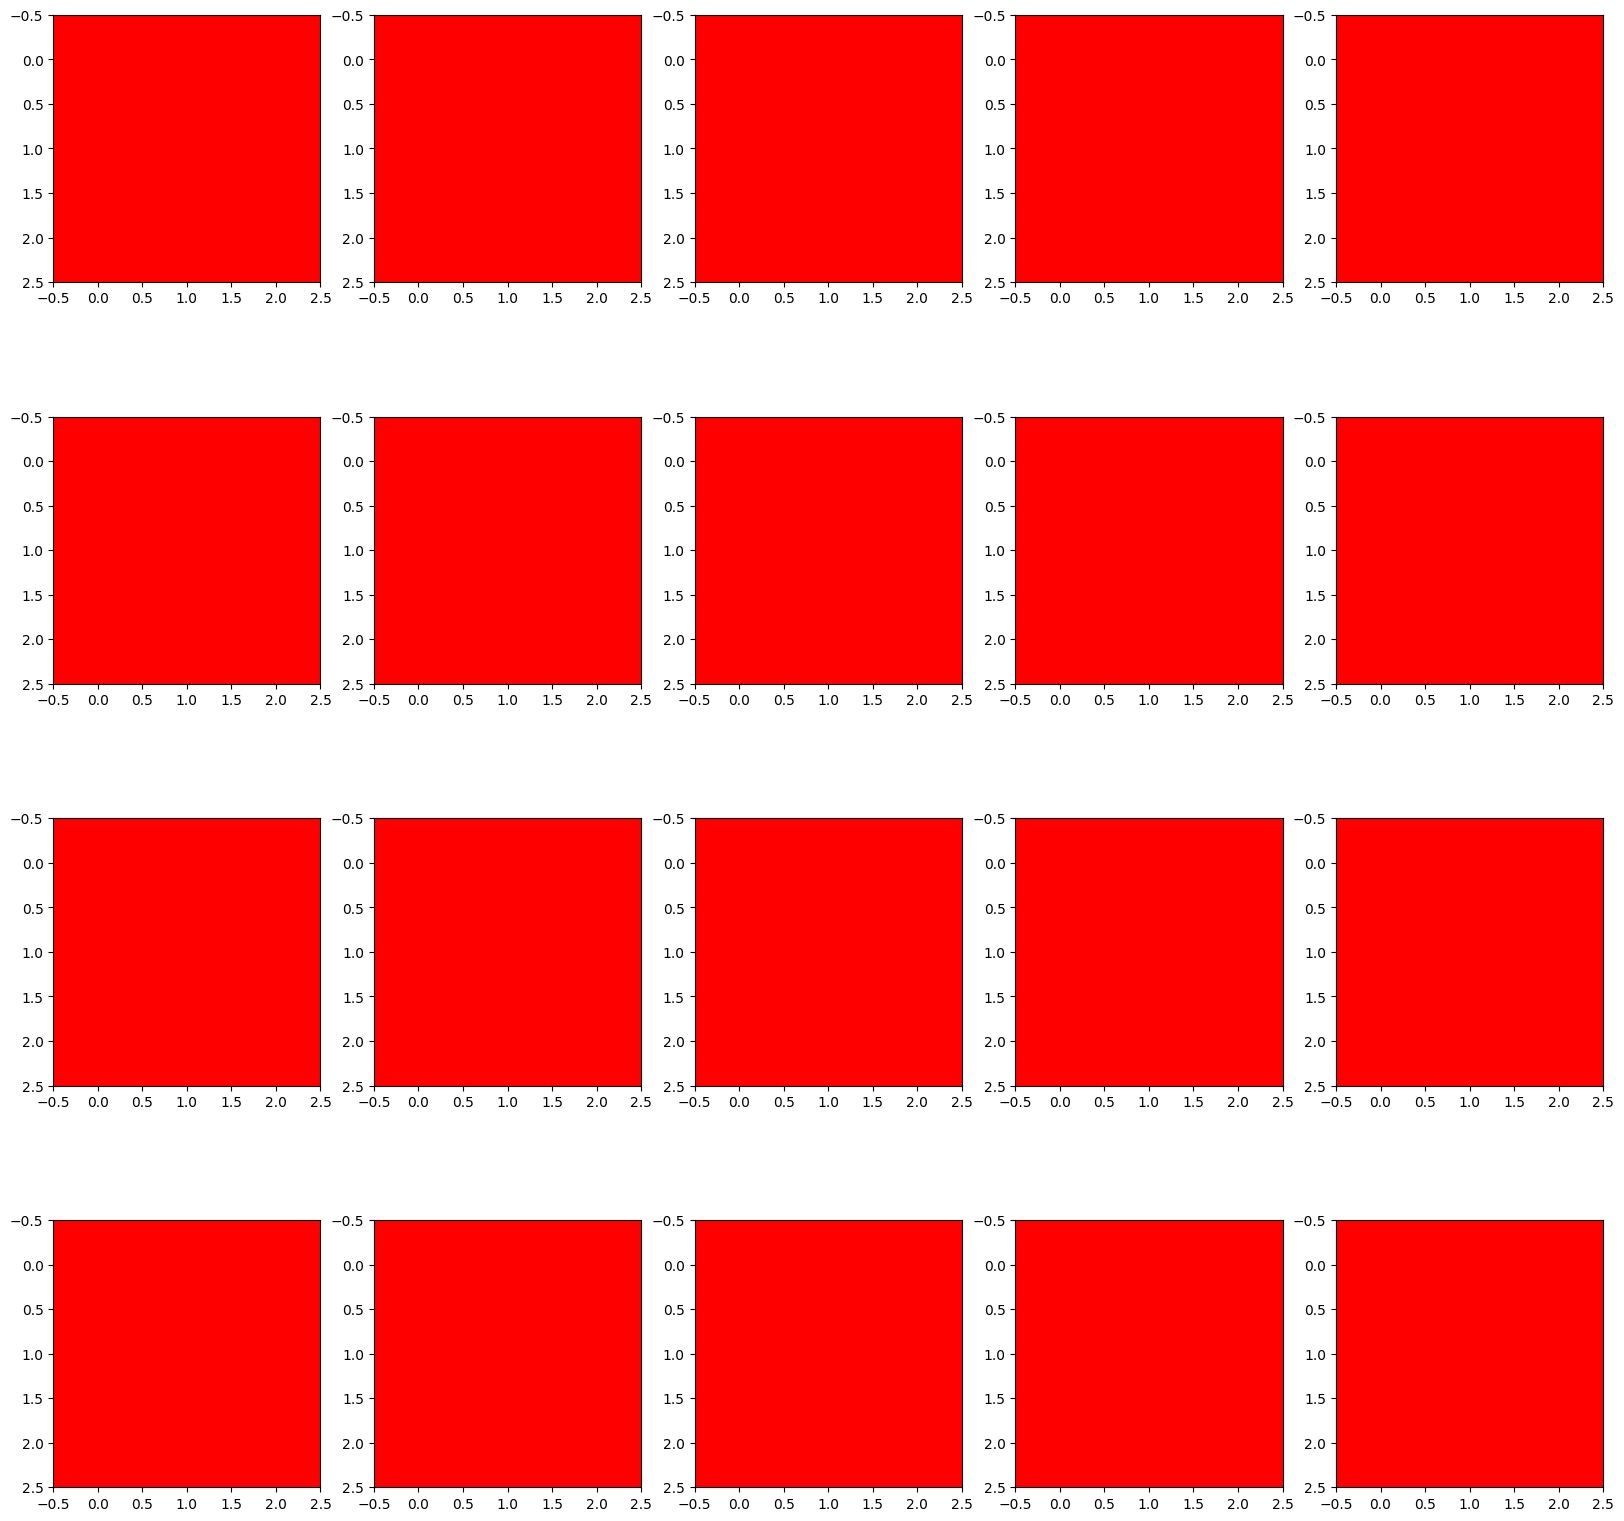

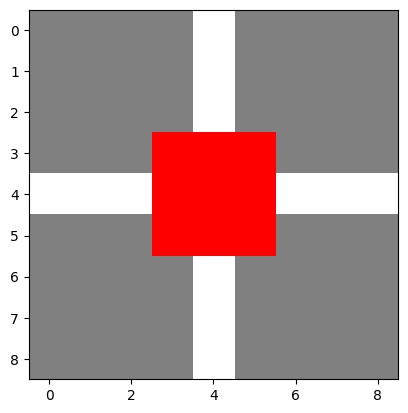

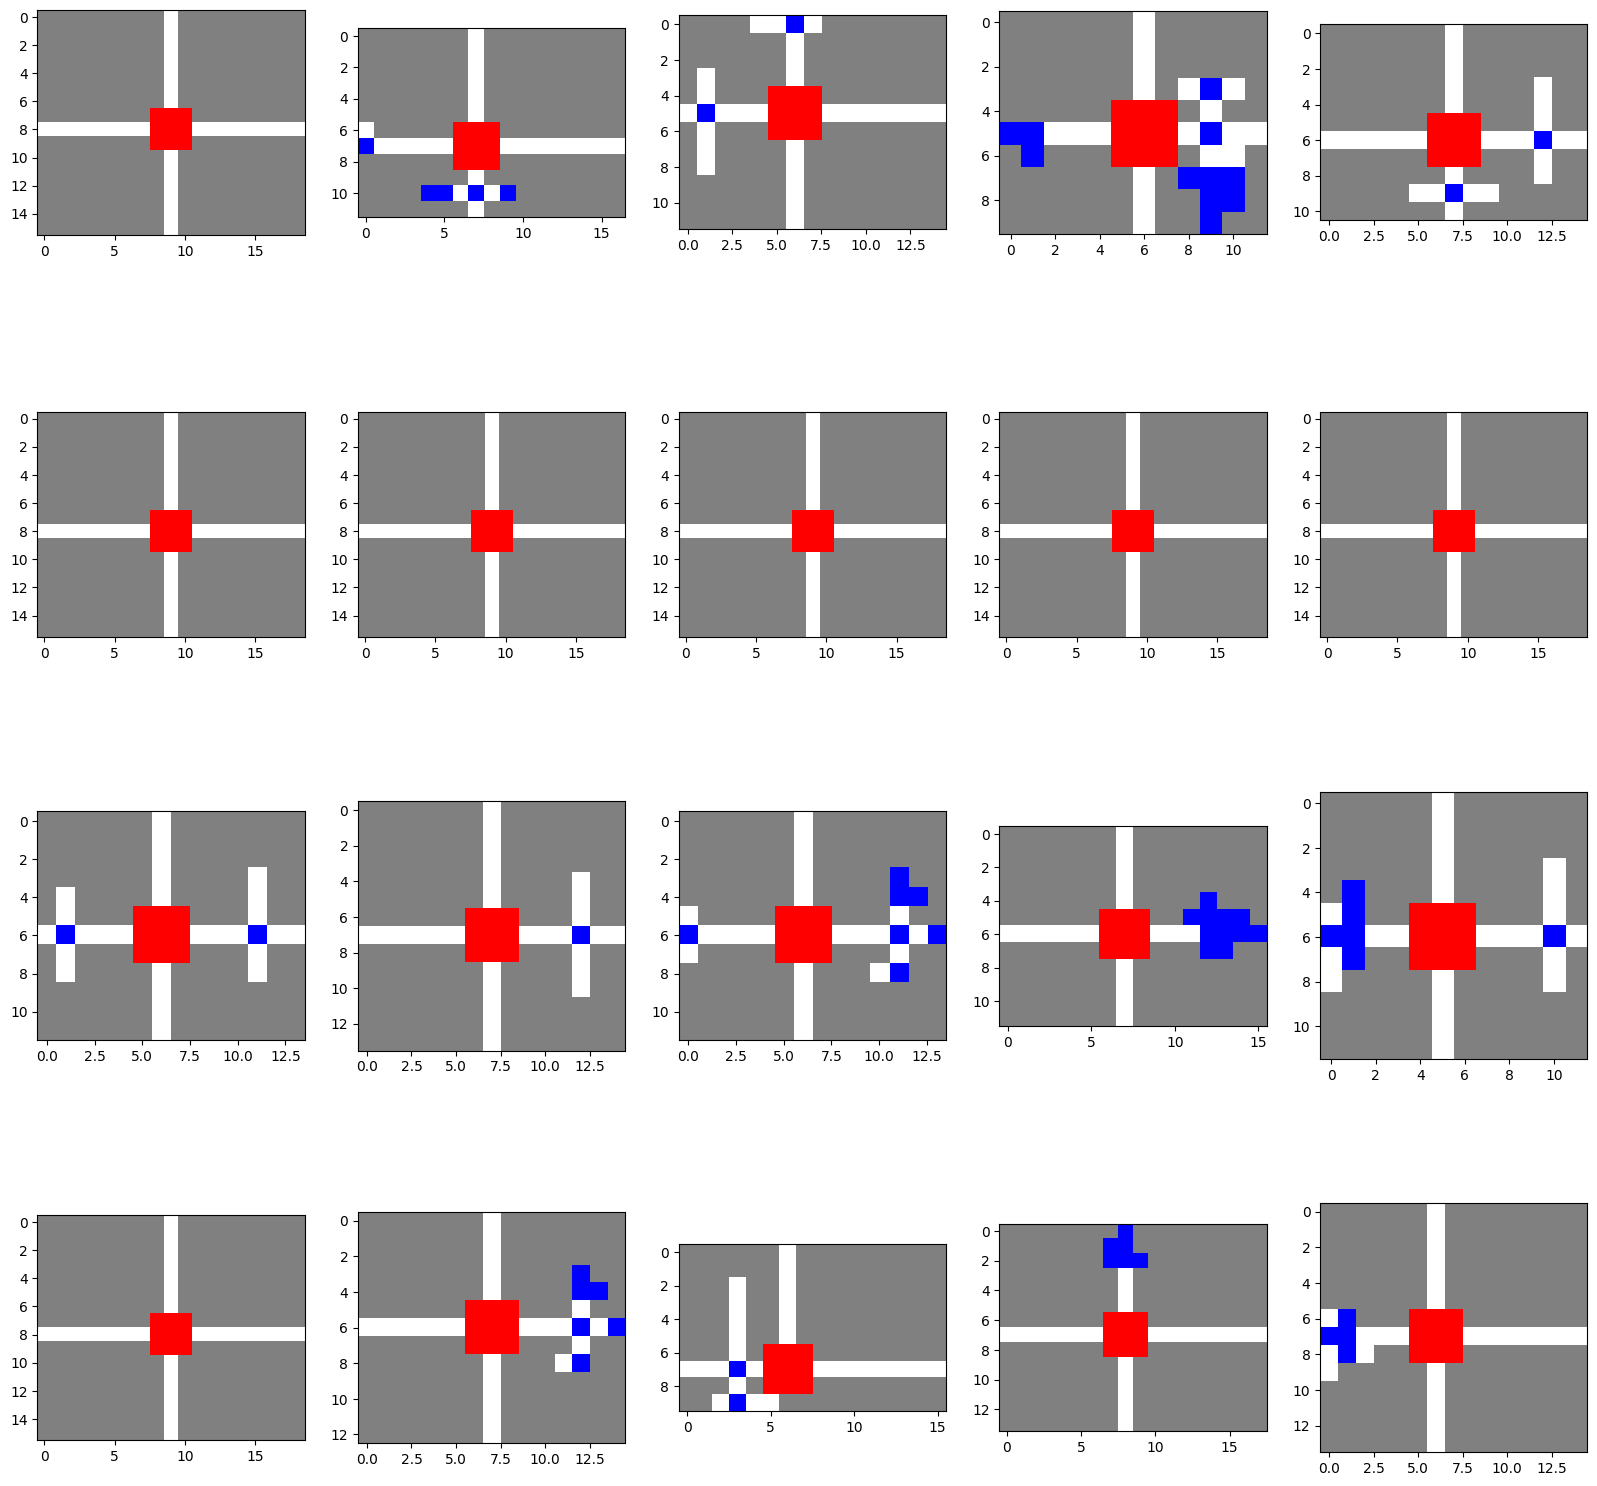

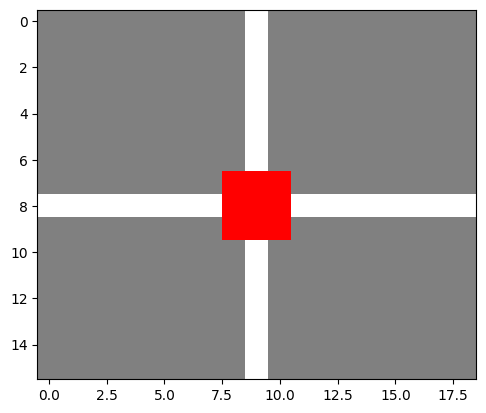

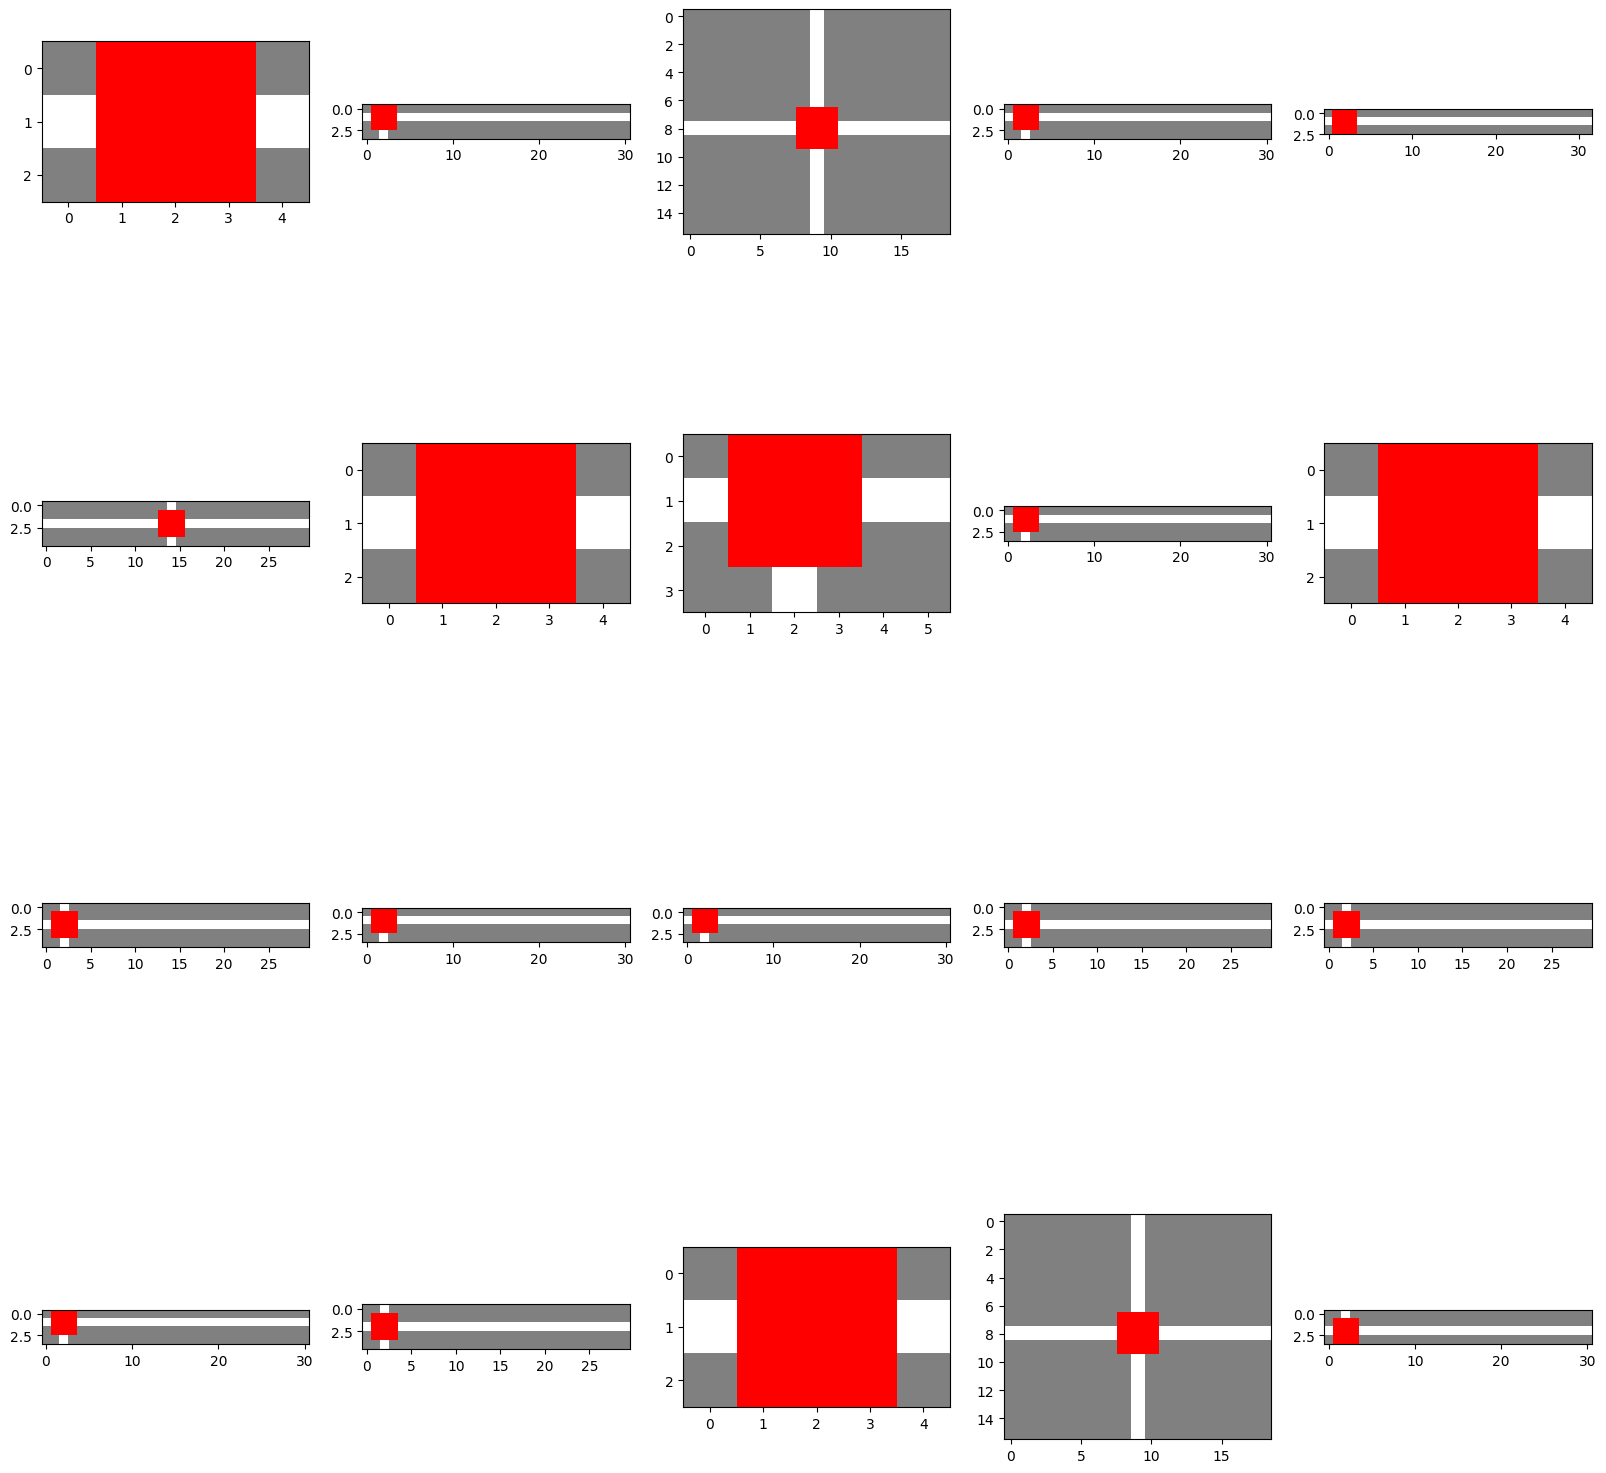

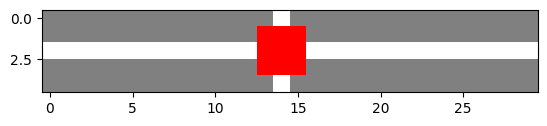

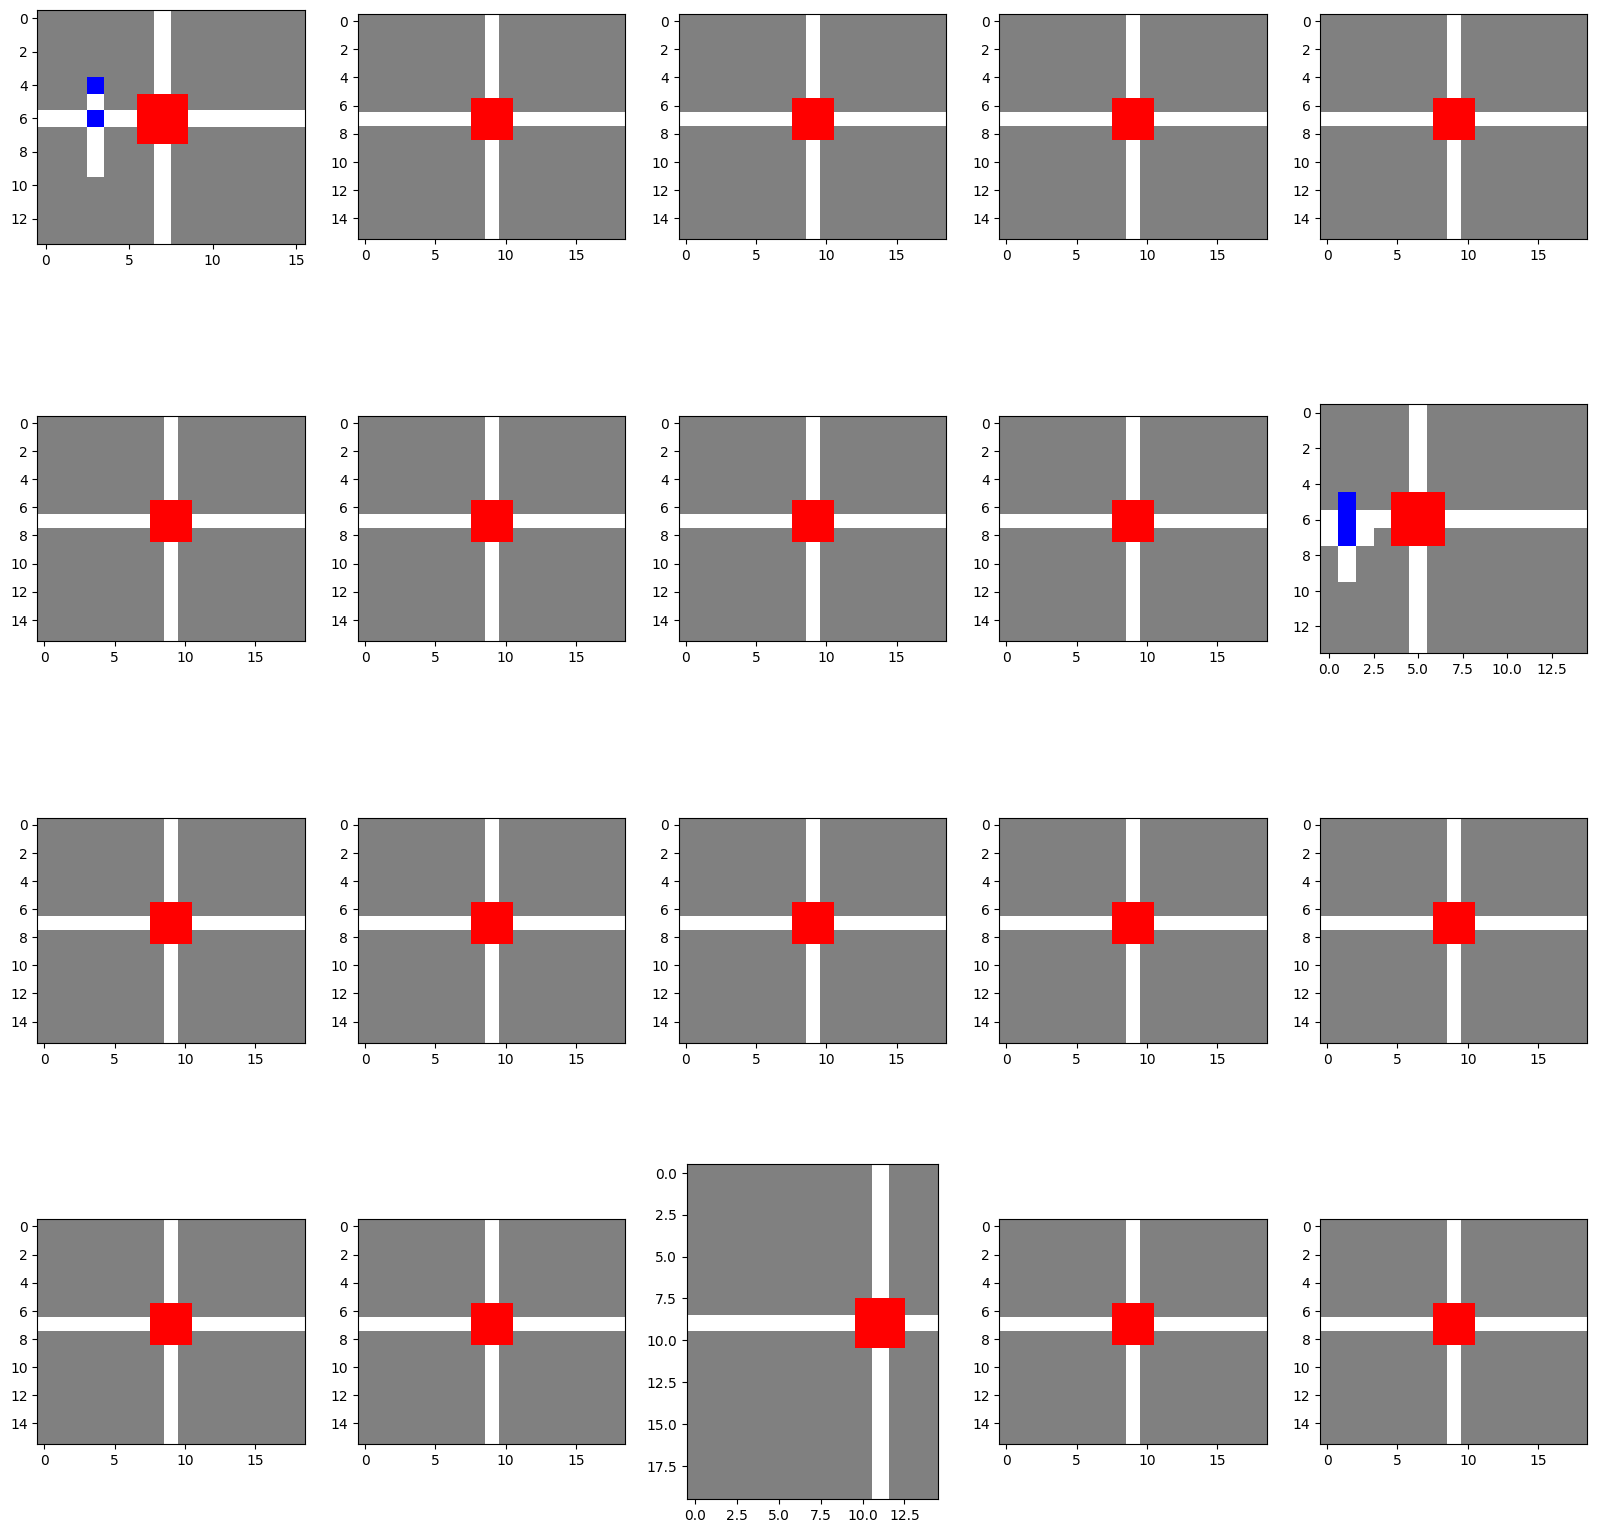

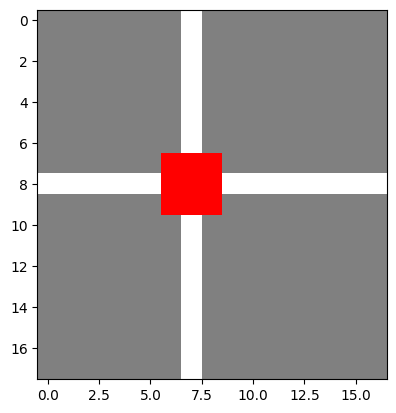

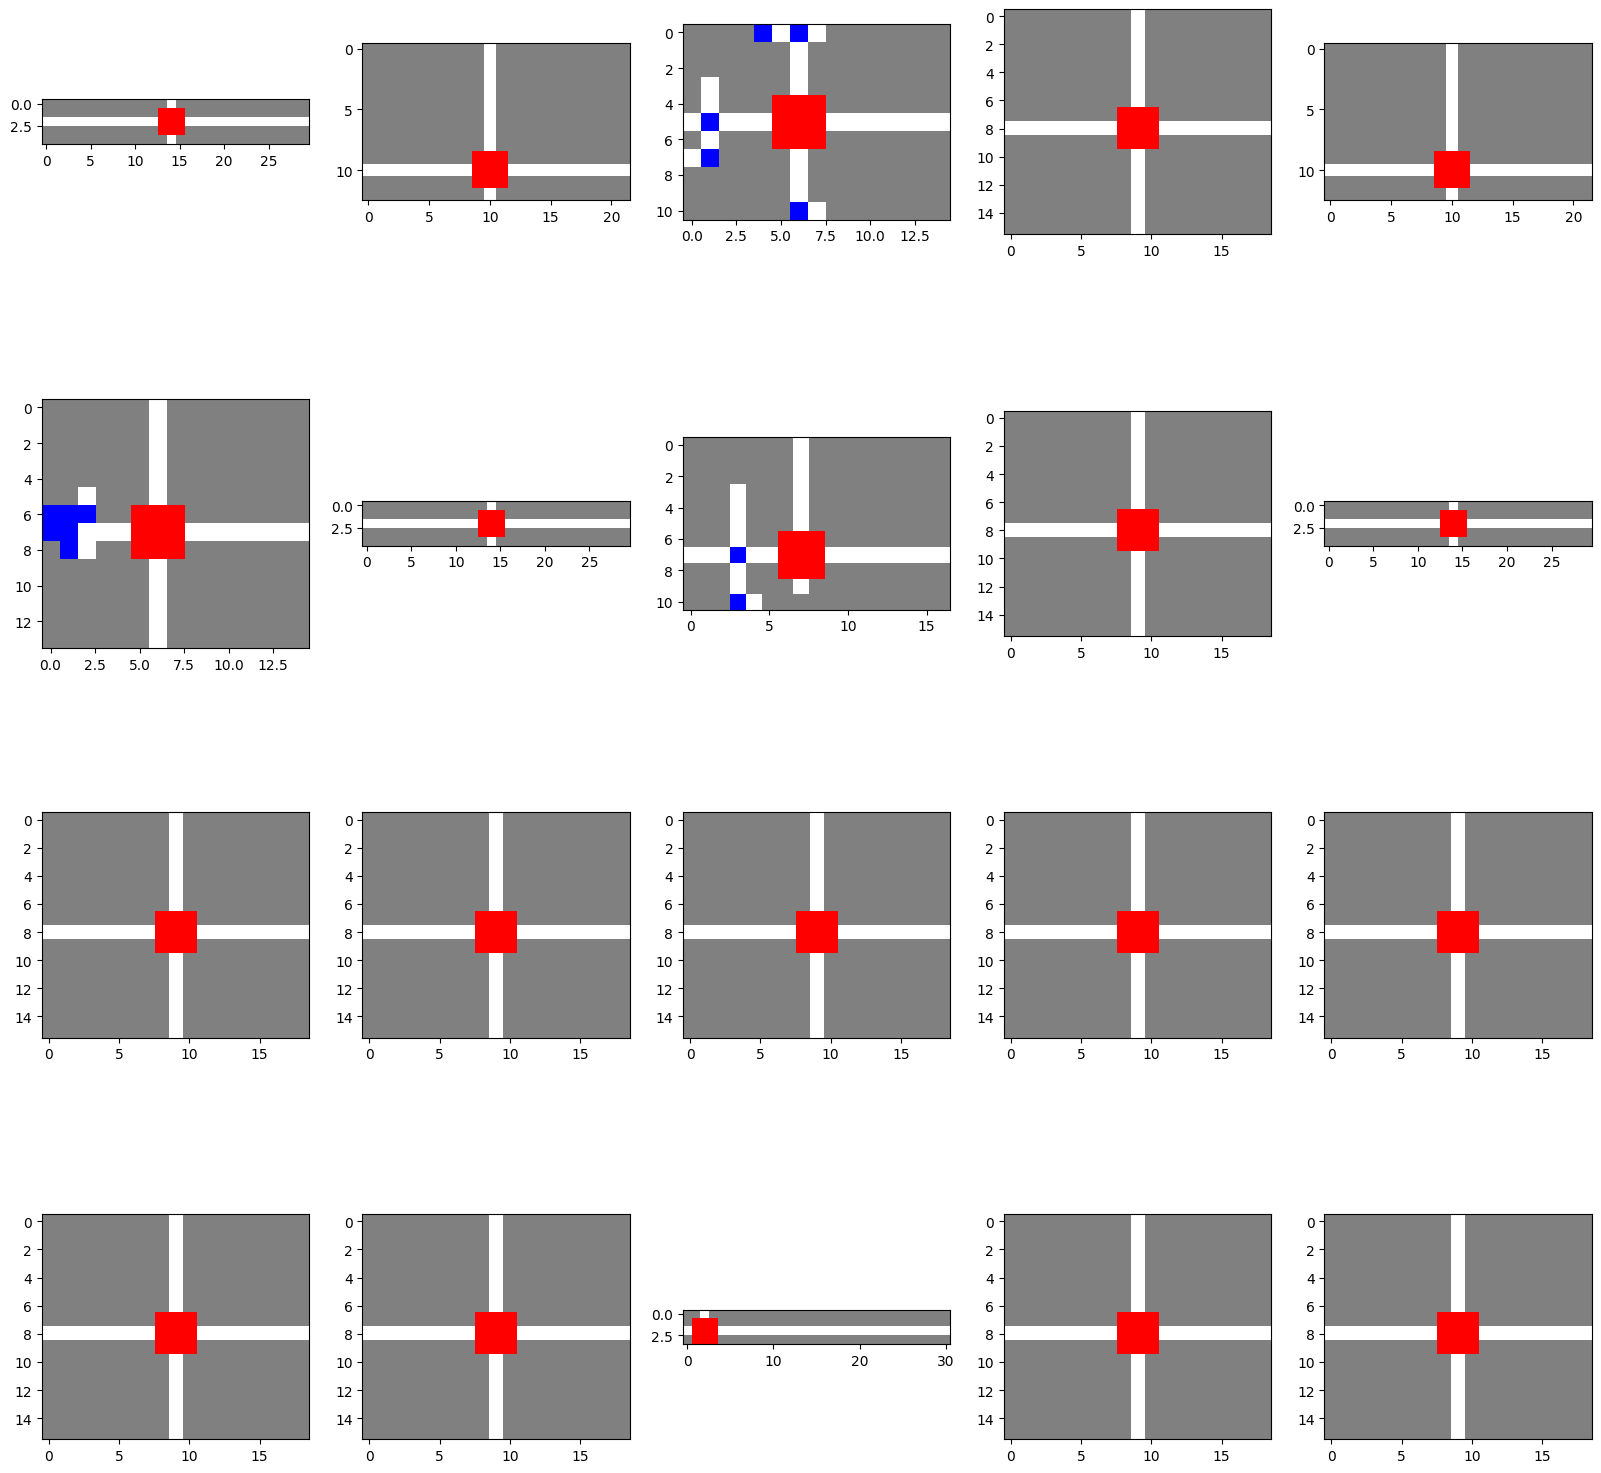

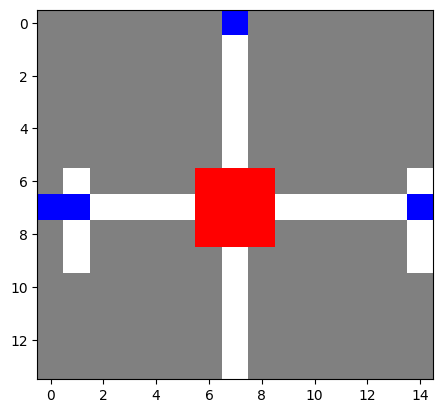

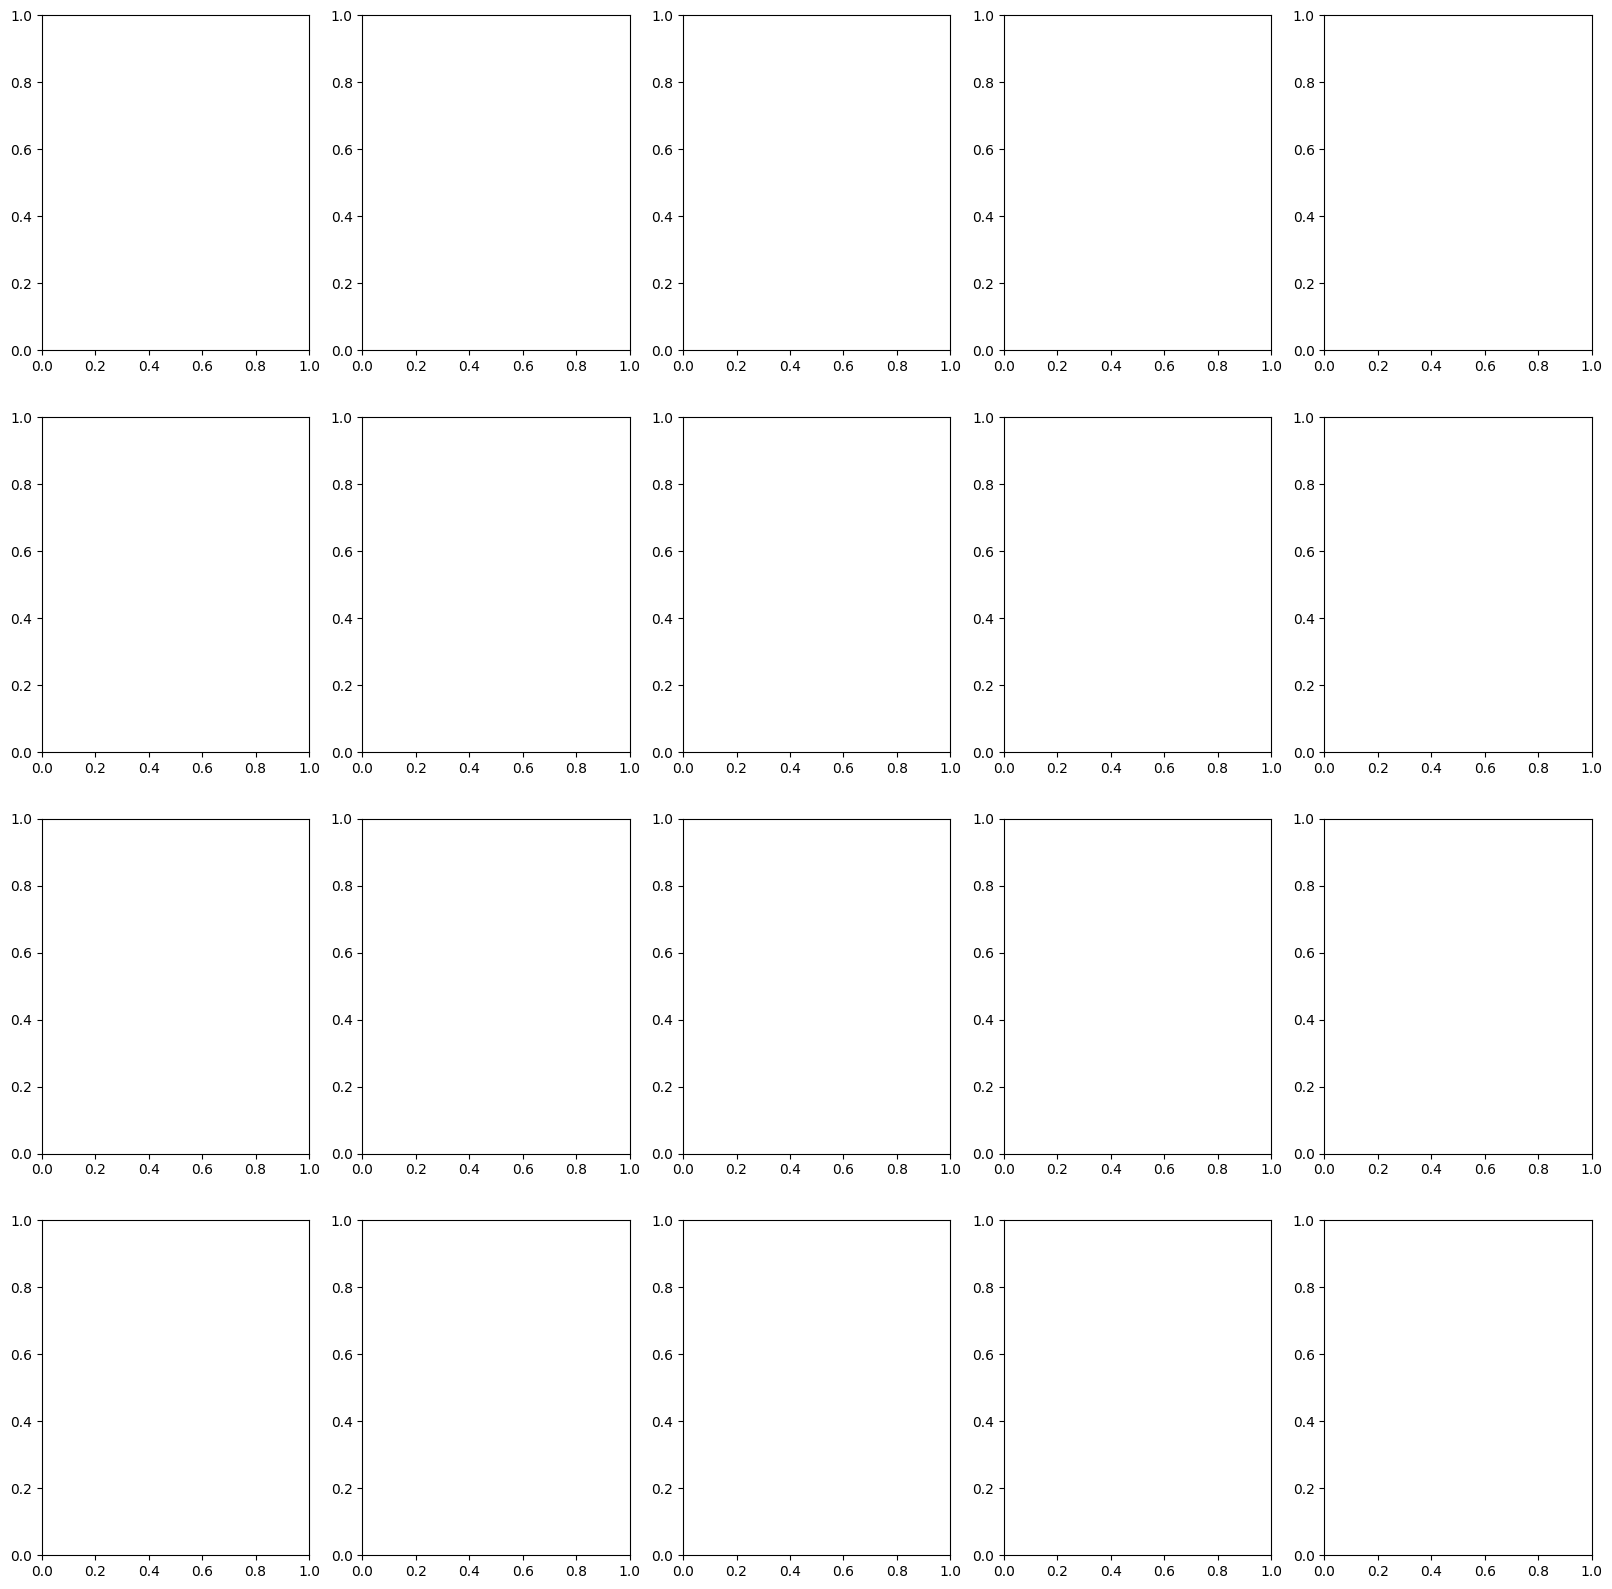

In [14]:
import json

path = "C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\mrgrn_ids.json"
path2 = "C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\grn_ids.json"

# Create a normalized color map
cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])
norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)

# Load data
with open(path, "r") as f:
    bodies = json.load(f)

with open(path2, "r") as f:
    bodies2 = json.load(f)

# Develop bodies
ibody = 0
for body, string in bodies.items():
    irow = ibody // 5
    icol = ibody % 5
    # Initalize subplots
    grid, core_grid_position = string2grid(string)
    ax[irow, icol].imshow(grid, cmap = cmap, norm = norm, aspect = "equal", interpolation = 'none') 


    if ibody == 19:
        plt.show()
        grid, core_grid_position = string2grid(bodies2[body.split("_")[0] + "_0" ])
        plt.imshow(grid, cmap = cmap, norm = norm, aspect = "equal", interpolation = 'none')
        plt.show()
        fig, ax = plt.subplots(4, 5, figsize = (20, 20))
        ibody = 0
    else:
        ibody += 1
